In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import catboost as ctb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

In [2]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [3]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days == 0
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    data["Total_Volume"] = data.groupby("Opportunity_ID", sort = False)["Total_Amount"].transform("sum")
    data["ASP_max"] = data.groupby("Opportunity_ID", sort = False)["ASP"].transform("max")
    data["ASP_converted_max"] = data.groupby("Opportunity_ID", sort = False)["ASP_converted"].transform("max")
    data.drop(["ASP", "ASP_converted"], axis = 1, inplace = True)
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates, axis = 1)
    
    if 'Stage' in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    # numeric encode de categoricals
    
    label_encoder = LabelEncoder()
    cat_vars = [x for x in data.select_dtypes('category').columns if x != 'Stage']
    for col in cat_vars:
        data[col] = label_encoder.fit_transform(data[col])
        
    # elimino nans. strategy --> mean
    #imputer = SimpleImputer(strategy='mean')
    #cols = data.columns
    #data = imputer.fit_transform(data)
    #data = pd.DataFrame(data, columns = cols)
    
    data.loc[data.Offer_Duration.isna(), "Offer_Duration"] = -100
    data.loc[data.Past_Quote.isna(), "Past_Quote"] = -100
    data.loc[data.Total_Amount.isna(), "Total_Amount"] = -100
    data.loc[data.Total_Volume.isna(), "Total_Volume"] = -100
    data.loc[data.ASP_max.isna(), "ASP_max"] = -100
    data.loc[data.ASP_converted_max.isna(), "ASP_converted_max"] = -100
    
    return (data)

In [4]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [5]:
prep = preprocess(data)

In [11]:
prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16883 entries, 0 to 16946
Data columns (total 35 columns):
Region                              16883 non-null int64
Territory                           16883 non-null int64
PricingDelivery_Terms_Quote_Appr    16883 non-null int64
PricingDelivery_Terms_Approved      16883 non-null int64
Bureaucratic_Code_0_Approval        16883 non-null int64
Bureaucratic_Code_0_Approved        16883 non-null int64
Bureaucratic_Code                   16883 non-null int64
Source                              16883 non-null int64
Billing_Country                     16883 non-null int64
Opportunity_ID                      16883 non-null int64
Sales_Contract_No                   16883 non-null int64
Account_Owner                       16883 non-null int64
Opportunity_Owner                   16883 non-null int64
Currency                            16883 non-null int64
Last_Modified_By                    16883 non-null int64
Month                               

In [6]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [7]:
clf = ctb.CatBoostClassifier(num_boost_round=5000,
                             learning_rate=0.015,
                             l2_leaf_reg=3.5,
                             depth=8, 
                             max_bin=400,
                             num_leaves=31,
                             rsm=0.98,
                             eval_metric='Logloss',
                             random_seed=42)

In [8]:
model = AdaBoostClassifier(base_estimator=clf, random_state=42, n_estimators=5)

In [9]:
model.fit(X=x_train.drop(target, axis=1), y=y_train)

0:	learn: 0.6644298	total: 169ms	remaining: 14m 5s
1:	learn: 0.6376824	total: 203ms	remaining: 8m 27s
2:	learn: 0.6114839	total: 234ms	remaining: 6m 29s
3:	learn: 0.5867257	total: 265ms	remaining: 5m 31s
4:	learn: 0.5628954	total: 295ms	remaining: 4m 55s
5:	learn: 0.5404152	total: 325ms	remaining: 4m 30s
6:	learn: 0.5196840	total: 356ms	remaining: 4m 13s
7:	learn: 0.4990589	total: 422ms	remaining: 4m 23s
8:	learn: 0.4806556	total: 453ms	remaining: 4m 11s
9:	learn: 0.4627362	total: 483ms	remaining: 4m 1s
10:	learn: 0.4453842	total: 513ms	remaining: 3m 52s
11:	learn: 0.4291400	total: 565ms	remaining: 3m 54s
12:	learn: 0.4147727	total: 636ms	remaining: 4m 3s
13:	learn: 0.4008294	total: 697ms	remaining: 4m 8s
14:	learn: 0.3860586	total: 752ms	remaining: 4m 9s
15:	learn: 0.3738663	total: 791ms	remaining: 4m 6s
16:	learn: 0.3605826	total: 825ms	remaining: 4m 1s
17:	learn: 0.3486835	total: 873ms	remaining: 4m 1s
18:	learn: 0.3367750	total: 909ms	remaining: 3m 58s
19:	learn: 0.3262208	total: 9

158:	learn: 0.0826471	total: 6.31s	remaining: 3m 12s
159:	learn: 0.0824615	total: 6.34s	remaining: 3m 11s
160:	learn: 0.0822654	total: 6.37s	remaining: 3m 11s
161:	learn: 0.0820777	total: 6.4s	remaining: 3m 11s
162:	learn: 0.0819119	total: 6.43s	remaining: 3m 10s
163:	learn: 0.0817300	total: 6.46s	remaining: 3m 10s
164:	learn: 0.0815363	total: 6.49s	remaining: 3m 10s
165:	learn: 0.0812243	total: 6.54s	remaining: 3m 10s
166:	learn: 0.0810355	total: 6.57s	remaining: 3m 10s
167:	learn: 0.0808472	total: 6.6s	remaining: 3m 9s
168:	learn: 0.0806357	total: 6.63s	remaining: 3m 9s
169:	learn: 0.0804701	total: 6.66s	remaining: 3m 9s
170:	learn: 0.0802752	total: 6.69s	remaining: 3m 8s
171:	learn: 0.0800308	total: 6.72s	remaining: 3m 8s
172:	learn: 0.0797464	total: 6.76s	remaining: 3m 8s
173:	learn: 0.0794585	total: 6.8s	remaining: 3m 8s
174:	learn: 0.0792089	total: 6.83s	remaining: 3m 8s
175:	learn: 0.0790395	total: 6.86s	remaining: 3m 8s
176:	learn: 0.0788759	total: 6.89s	remaining: 3m 7s
177:	l

316:	learn: 0.0607082	total: 11.8s	remaining: 2m 54s
317:	learn: 0.0606731	total: 11.8s	remaining: 2m 54s
318:	learn: 0.0606169	total: 11.9s	remaining: 2m 54s
319:	learn: 0.0603901	total: 11.9s	remaining: 2m 54s
320:	learn: 0.0603233	total: 12s	remaining: 2m 54s
321:	learn: 0.0602260	total: 12.1s	remaining: 2m 55s
322:	learn: 0.0601566	total: 12.1s	remaining: 2m 55s
323:	learn: 0.0600033	total: 12.2s	remaining: 2m 55s
324:	learn: 0.0598831	total: 12.2s	remaining: 2m 55s
325:	learn: 0.0598315	total: 12.2s	remaining: 2m 55s
326:	learn: 0.0597057	total: 12.3s	remaining: 2m 55s
327:	learn: 0.0595971	total: 12.3s	remaining: 2m 55s
328:	learn: 0.0595619	total: 12.3s	remaining: 2m 54s
329:	learn: 0.0594669	total: 12.4s	remaining: 2m 54s
330:	learn: 0.0593355	total: 12.4s	remaining: 2m 54s
331:	learn: 0.0592837	total: 12.4s	remaining: 2m 54s
332:	learn: 0.0591962	total: 12.5s	remaining: 2m 54s
333:	learn: 0.0591114	total: 12.5s	remaining: 2m 54s
334:	learn: 0.0589911	total: 12.5s	remaining: 2m

477:	learn: 0.0484410	total: 17.7s	remaining: 2m 47s
478:	learn: 0.0483630	total: 17.7s	remaining: 2m 47s
479:	learn: 0.0483115	total: 17.8s	remaining: 2m 47s
480:	learn: 0.0482300	total: 17.8s	remaining: 2m 47s
481:	learn: 0.0481847	total: 17.8s	remaining: 2m 47s
482:	learn: 0.0481619	total: 17.9s	remaining: 2m 47s
483:	learn: 0.0481022	total: 17.9s	remaining: 2m 47s
484:	learn: 0.0480313	total: 17.9s	remaining: 2m 47s
485:	learn: 0.0480093	total: 18s	remaining: 2m 47s
486:	learn: 0.0479181	total: 18s	remaining: 2m 46s
487:	learn: 0.0478444	total: 18s	remaining: 2m 46s
488:	learn: 0.0477598	total: 18.1s	remaining: 2m 46s
489:	learn: 0.0476442	total: 18.1s	remaining: 2m 46s
490:	learn: 0.0475650	total: 18.1s	remaining: 2m 46s
491:	learn: 0.0475129	total: 18.2s	remaining: 2m 46s
492:	learn: 0.0474257	total: 18.2s	remaining: 2m 46s
493:	learn: 0.0473820	total: 18.2s	remaining: 2m 46s
494:	learn: 0.0473133	total: 18.3s	remaining: 2m 46s
495:	learn: 0.0472727	total: 18.3s	remaining: 2m 46s

636:	learn: 0.0392979	total: 23.1s	remaining: 2m 38s
637:	learn: 0.0392853	total: 23.2s	remaining: 2m 38s
638:	learn: 0.0392333	total: 23.2s	remaining: 2m 38s
639:	learn: 0.0391725	total: 23.2s	remaining: 2m 38s
640:	learn: 0.0391022	total: 23.3s	remaining: 2m 38s
641:	learn: 0.0390288	total: 23.3s	remaining: 2m 38s
642:	learn: 0.0389841	total: 23.3s	remaining: 2m 38s
643:	learn: 0.0389302	total: 23.4s	remaining: 2m 38s
644:	learn: 0.0388804	total: 23.4s	remaining: 2m 38s
645:	learn: 0.0388319	total: 23.4s	remaining: 2m 37s
646:	learn: 0.0387775	total: 23.5s	remaining: 2m 37s
647:	learn: 0.0387189	total: 23.5s	remaining: 2m 37s
648:	learn: 0.0386557	total: 23.5s	remaining: 2m 37s
649:	learn: 0.0386128	total: 23.6s	remaining: 2m 37s
650:	learn: 0.0385692	total: 23.6s	remaining: 2m 37s
651:	learn: 0.0385050	total: 23.6s	remaining: 2m 37s
652:	learn: 0.0384647	total: 23.7s	remaining: 2m 37s
653:	learn: 0.0383829	total: 23.7s	remaining: 2m 37s
654:	learn: 0.0383316	total: 23.7s	remaining: 

793:	learn: 0.0329361	total: 28.5s	remaining: 2m 30s
794:	learn: 0.0328937	total: 28.5s	remaining: 2m 30s
795:	learn: 0.0328666	total: 28.5s	remaining: 2m 30s
796:	learn: 0.0328199	total: 28.5s	remaining: 2m 30s
797:	learn: 0.0327697	total: 28.6s	remaining: 2m 30s
798:	learn: 0.0327525	total: 28.6s	remaining: 2m 30s
799:	learn: 0.0327376	total: 28.6s	remaining: 2m 30s
800:	learn: 0.0327277	total: 28.7s	remaining: 2m 30s
801:	learn: 0.0326395	total: 28.7s	remaining: 2m 30s
802:	learn: 0.0326332	total: 28.7s	remaining: 2m 30s
803:	learn: 0.0325766	total: 28.8s	remaining: 2m 30s
804:	learn: 0.0325292	total: 28.8s	remaining: 2m 30s
805:	learn: 0.0324863	total: 28.8s	remaining: 2m 29s
806:	learn: 0.0324447	total: 28.9s	remaining: 2m 29s
807:	learn: 0.0324049	total: 28.9s	remaining: 2m 29s
808:	learn: 0.0323979	total: 28.9s	remaining: 2m 29s
809:	learn: 0.0323556	total: 29s	remaining: 2m 29s
810:	learn: 0.0323096	total: 29s	remaining: 2m 29s
811:	learn: 0.0322676	total: 29s	remaining: 2m 29s

952:	learn: 0.0275929	total: 33.8s	remaining: 2m 23s
953:	learn: 0.0275670	total: 33.8s	remaining: 2m 23s
954:	learn: 0.0275299	total: 33.9s	remaining: 2m 23s
955:	learn: 0.0274898	total: 33.9s	remaining: 2m 23s
956:	learn: 0.0274397	total: 33.9s	remaining: 2m 23s
957:	learn: 0.0274353	total: 34s	remaining: 2m 23s
958:	learn: 0.0274323	total: 34s	remaining: 2m 23s
959:	learn: 0.0273965	total: 34s	remaining: 2m 23s
960:	learn: 0.0273883	total: 34.1s	remaining: 2m 23s
961:	learn: 0.0273503	total: 34.1s	remaining: 2m 23s
962:	learn: 0.0273385	total: 34.1s	remaining: 2m 23s
963:	learn: 0.0273018	total: 34.2s	remaining: 2m 23s
964:	learn: 0.0272807	total: 34.2s	remaining: 2m 22s
965:	learn: 0.0272336	total: 34.2s	remaining: 2m 22s
966:	learn: 0.0271737	total: 34.3s	remaining: 2m 22s
967:	learn: 0.0271470	total: 34.3s	remaining: 2m 22s
968:	learn: 0.0271207	total: 34.3s	remaining: 2m 22s
969:	learn: 0.0271174	total: 34.4s	remaining: 2m 22s
970:	learn: 0.0270866	total: 34.4s	remaining: 2m 22s

1107:	learn: 0.0236139	total: 39.9s	remaining: 2m 20s
1108:	learn: 0.0236083	total: 39.9s	remaining: 2m 20s
1109:	learn: 0.0235875	total: 40s	remaining: 2m 20s
1110:	learn: 0.0235863	total: 40s	remaining: 2m 20s
1111:	learn: 0.0235434	total: 40s	remaining: 2m 19s
1112:	learn: 0.0235400	total: 40.1s	remaining: 2m 19s
1113:	learn: 0.0235139	total: 40.1s	remaining: 2m 19s
1114:	learn: 0.0234946	total: 40.1s	remaining: 2m 19s
1115:	learn: 0.0234834	total: 40.2s	remaining: 2m 19s
1116:	learn: 0.0234511	total: 40.2s	remaining: 2m 19s
1117:	learn: 0.0234140	total: 40.2s	remaining: 2m 19s
1118:	learn: 0.0233984	total: 40.2s	remaining: 2m 19s
1119:	learn: 0.0233736	total: 40.3s	remaining: 2m 19s
1120:	learn: 0.0233337	total: 40.3s	remaining: 2m 19s
1121:	learn: 0.0233022	total: 40.3s	remaining: 2m 19s
1122:	learn: 0.0232713	total: 40.4s	remaining: 2m 19s
1123:	learn: 0.0232449	total: 40.4s	remaining: 2m 19s
1124:	learn: 0.0232325	total: 40.4s	remaining: 2m 19s
1125:	learn: 0.0231986	total: 40.5

1261:	learn: 0.0204965	total: 45.7s	remaining: 2m 15s
1262:	learn: 0.0204747	total: 45.7s	remaining: 2m 15s
1263:	learn: 0.0204464	total: 45.7s	remaining: 2m 15s
1264:	learn: 0.0204116	total: 45.8s	remaining: 2m 15s
1265:	learn: 0.0204092	total: 45.8s	remaining: 2m 15s
1266:	learn: 0.0203876	total: 45.8s	remaining: 2m 15s
1267:	learn: 0.0203691	total: 45.9s	remaining: 2m 15s
1268:	learn: 0.0203561	total: 46s	remaining: 2m 15s
1269:	learn: 0.0203451	total: 46s	remaining: 2m 15s
1270:	learn: 0.0203339	total: 46s	remaining: 2m 15s
1271:	learn: 0.0203071	total: 46.1s	remaining: 2m 15s
1272:	learn: 0.0202868	total: 46.1s	remaining: 2m 14s
1273:	learn: 0.0202536	total: 46.1s	remaining: 2m 14s
1274:	learn: 0.0202116	total: 46.2s	remaining: 2m 14s
1275:	learn: 0.0201929	total: 46.2s	remaining: 2m 14s
1276:	learn: 0.0201894	total: 46.2s	remaining: 2m 14s
1277:	learn: 0.0201759	total: 46.3s	remaining: 2m 14s
1278:	learn: 0.0201716	total: 46.3s	remaining: 2m 14s
1279:	learn: 0.0201663	total: 46.3

1418:	learn: 0.0179571	total: 51.5s	remaining: 2m 9s
1419:	learn: 0.0179483	total: 51.5s	remaining: 2m 9s
1420:	learn: 0.0179288	total: 51.6s	remaining: 2m 9s
1421:	learn: 0.0179005	total: 51.6s	remaining: 2m 9s
1422:	learn: 0.0178878	total: 51.6s	remaining: 2m 9s
1423:	learn: 0.0178692	total: 51.7s	remaining: 2m 9s
1424:	learn: 0.0178573	total: 51.7s	remaining: 2m 9s
1425:	learn: 0.0178375	total: 51.8s	remaining: 2m 9s
1426:	learn: 0.0178237	total: 51.8s	remaining: 2m 9s
1427:	learn: 0.0177812	total: 51.8s	remaining: 2m 9s
1428:	learn: 0.0177594	total: 51.9s	remaining: 2m 9s
1429:	learn: 0.0177326	total: 51.9s	remaining: 2m 9s
1430:	learn: 0.0177214	total: 51.9s	remaining: 2m 9s
1431:	learn: 0.0177165	total: 52s	remaining: 2m 9s
1432:	learn: 0.0177022	total: 52s	remaining: 2m 9s
1433:	learn: 0.0176924	total: 52.1s	remaining: 2m 9s
1434:	learn: 0.0176706	total: 52.1s	remaining: 2m 9s
1435:	learn: 0.0176560	total: 52.2s	remaining: 2m 9s
1436:	learn: 0.0176453	total: 52.2s	remaining: 2m 

1574:	learn: 0.0158041	total: 57.6s	remaining: 2m 5s
1575:	learn: 0.0157866	total: 57.6s	remaining: 2m 5s
1576:	learn: 0.0157618	total: 57.7s	remaining: 2m 5s
1577:	learn: 0.0157618	total: 57.7s	remaining: 2m 5s
1578:	learn: 0.0157524	total: 57.8s	remaining: 2m 5s
1579:	learn: 0.0157325	total: 57.8s	remaining: 2m 5s
1580:	learn: 0.0157052	total: 57.9s	remaining: 2m 5s
1581:	learn: 0.0156930	total: 57.9s	remaining: 2m 5s
1582:	learn: 0.0156868	total: 58s	remaining: 2m 5s
1583:	learn: 0.0156769	total: 58s	remaining: 2m 5s
1584:	learn: 0.0156687	total: 58.1s	remaining: 2m 5s
1585:	learn: 0.0156643	total: 58.1s	remaining: 2m 5s
1586:	learn: 0.0156602	total: 58.2s	remaining: 2m 5s
1587:	learn: 0.0156281	total: 58.2s	remaining: 2m 5s
1588:	learn: 0.0155999	total: 58.3s	remaining: 2m 5s
1589:	learn: 0.0155893	total: 58.4s	remaining: 2m 5s
1590:	learn: 0.0155721	total: 58.4s	remaining: 2m 5s
1591:	learn: 0.0155544	total: 58.4s	remaining: 2m 5s
1592:	learn: 0.0155227	total: 58.5s	remaining: 2m 

1734:	learn: 0.0139497	total: 1m 4s	remaining: 2m 1s
1735:	learn: 0.0139347	total: 1m 4s	remaining: 2m 1s
1736:	learn: 0.0139249	total: 1m 4s	remaining: 2m 1s
1737:	learn: 0.0139150	total: 1m 4s	remaining: 2m
1738:	learn: 0.0138977	total: 1m 4s	remaining: 2m
1739:	learn: 0.0138876	total: 1m 4s	remaining: 2m
1740:	learn: 0.0138823	total: 1m 4s	remaining: 2m
1741:	learn: 0.0138602	total: 1m 4s	remaining: 2m
1742:	learn: 0.0138557	total: 1m 4s	remaining: 2m
1743:	learn: 0.0138479	total: 1m 4s	remaining: 2m
1744:	learn: 0.0138400	total: 1m 4s	remaining: 2m
1745:	learn: 0.0138311	total: 1m 4s	remaining: 2m
1746:	learn: 0.0138294	total: 1m 4s	remaining: 2m
1747:	learn: 0.0138219	total: 1m 4s	remaining: 2m
1748:	learn: 0.0138047	total: 1m 4s	remaining: 2m
1749:	learn: 0.0137860	total: 1m 4s	remaining: 2m
1750:	learn: 0.0137783	total: 1m 4s	remaining: 2m
1751:	learn: 0.0137658	total: 1m 4s	remaining: 2m
1752:	learn: 0.0137577	total: 1m 4s	remaining: 2m
1753:	learn: 0.0137490	total: 1m 4s	remai

1889:	learn: 0.0126294	total: 1m 10s	remaining: 1m 55s
1890:	learn: 0.0126217	total: 1m 10s	remaining: 1m 55s
1891:	learn: 0.0126145	total: 1m 10s	remaining: 1m 55s
1892:	learn: 0.0126044	total: 1m 10s	remaining: 1m 55s
1893:	learn: 0.0126005	total: 1m 10s	remaining: 1m 55s
1894:	learn: 0.0126005	total: 1m 10s	remaining: 1m 55s
1895:	learn: 0.0125943	total: 1m 10s	remaining: 1m 55s
1896:	learn: 0.0125880	total: 1m 10s	remaining: 1m 55s
1897:	learn: 0.0125775	total: 1m 10s	remaining: 1m 55s
1898:	learn: 0.0125728	total: 1m 10s	remaining: 1m 55s
1899:	learn: 0.0125515	total: 1m 10s	remaining: 1m 55s
1900:	learn: 0.0125489	total: 1m 10s	remaining: 1m 55s
1901:	learn: 0.0125442	total: 1m 10s	remaining: 1m 55s
1902:	learn: 0.0125365	total: 1m 10s	remaining: 1m 55s
1903:	learn: 0.0125332	total: 1m 10s	remaining: 1m 55s
1904:	learn: 0.0125332	total: 1m 10s	remaining: 1m 55s
1905:	learn: 0.0125332	total: 1m 10s	remaining: 1m 55s
1906:	learn: 0.0125320	total: 1m 10s	remaining: 1m 55s
1907:	lear

2039:	learn: 0.0116049	total: 1m 18s	remaining: 1m 53s
2040:	learn: 0.0115955	total: 1m 18s	remaining: 1m 53s
2041:	learn: 0.0115904	total: 1m 18s	remaining: 1m 53s
2042:	learn: 0.0115751	total: 1m 18s	remaining: 1m 53s
2043:	learn: 0.0115618	total: 1m 18s	remaining: 1m 53s
2044:	learn: 0.0115494	total: 1m 18s	remaining: 1m 53s
2045:	learn: 0.0115321	total: 1m 18s	remaining: 1m 53s
2046:	learn: 0.0115290	total: 1m 18s	remaining: 1m 53s
2047:	learn: 0.0115290	total: 1m 18s	remaining: 1m 53s
2048:	learn: 0.0115268	total: 1m 18s	remaining: 1m 53s
2049:	learn: 0.0115197	total: 1m 18s	remaining: 1m 53s
2050:	learn: 0.0115107	total: 1m 19s	remaining: 1m 53s
2051:	learn: 0.0115050	total: 1m 19s	remaining: 1m 53s
2052:	learn: 0.0115000	total: 1m 19s	remaining: 1m 53s
2053:	learn: 0.0114972	total: 1m 19s	remaining: 1m 53s
2054:	learn: 0.0114901	total: 1m 19s	remaining: 1m 53s
2055:	learn: 0.0114792	total: 1m 19s	remaining: 1m 53s
2056:	learn: 0.0114747	total: 1m 19s	remaining: 1m 53s
2057:	lear

2189:	learn: 0.0107376	total: 1m 26s	remaining: 1m 50s
2190:	learn: 0.0107350	total: 1m 26s	remaining: 1m 50s
2191:	learn: 0.0107273	total: 1m 26s	remaining: 1m 50s
2192:	learn: 0.0107139	total: 1m 26s	remaining: 1m 50s
2193:	learn: 0.0107072	total: 1m 26s	remaining: 1m 50s
2194:	learn: 0.0106999	total: 1m 26s	remaining: 1m 50s
2195:	learn: 0.0106856	total: 1m 26s	remaining: 1m 50s
2196:	learn: 0.0106774	total: 1m 26s	remaining: 1m 50s
2197:	learn: 0.0106774	total: 1m 26s	remaining: 1m 50s
2198:	learn: 0.0106774	total: 1m 26s	remaining: 1m 50s
2199:	learn: 0.0106774	total: 1m 26s	remaining: 1m 50s
2200:	learn: 0.0106760	total: 1m 27s	remaining: 1m 50s
2201:	learn: 0.0106645	total: 1m 27s	remaining: 1m 50s
2202:	learn: 0.0106586	total: 1m 27s	remaining: 1m 50s
2203:	learn: 0.0106501	total: 1m 27s	remaining: 1m 50s
2204:	learn: 0.0106468	total: 1m 27s	remaining: 1m 50s
2205:	learn: 0.0106374	total: 1m 27s	remaining: 1m 50s
2206:	learn: 0.0106266	total: 1m 27s	remaining: 1m 50s
2207:	lear

2339:	learn: 0.0099045	total: 1m 33s	remaining: 1m 46s
2340:	learn: 0.0099016	total: 1m 33s	remaining: 1m 46s
2341:	learn: 0.0099003	total: 1m 33s	remaining: 1m 46s
2342:	learn: 0.0098945	total: 1m 33s	remaining: 1m 46s
2343:	learn: 0.0098900	total: 1m 33s	remaining: 1m 46s
2344:	learn: 0.0098812	total: 1m 33s	remaining: 1m 46s
2345:	learn: 0.0098746	total: 1m 33s	remaining: 1m 45s
2346:	learn: 0.0098730	total: 1m 33s	remaining: 1m 45s
2347:	learn: 0.0098704	total: 1m 33s	remaining: 1m 45s
2348:	learn: 0.0098595	total: 1m 33s	remaining: 1m 45s
2349:	learn: 0.0098525	total: 1m 33s	remaining: 1m 45s
2350:	learn: 0.0098464	total: 1m 33s	remaining: 1m 45s
2351:	learn: 0.0098349	total: 1m 34s	remaining: 1m 45s
2352:	learn: 0.0098270	total: 1m 34s	remaining: 1m 45s
2353:	learn: 0.0098234	total: 1m 34s	remaining: 1m 45s
2354:	learn: 0.0098132	total: 1m 34s	remaining: 1m 45s
2355:	learn: 0.0098132	total: 1m 34s	remaining: 1m 45s
2356:	learn: 0.0098116	total: 1m 34s	remaining: 1m 45s
2357:	lear

2494:	learn: 0.0092037	total: 1m 39s	remaining: 1m 39s
2495:	learn: 0.0091954	total: 1m 39s	remaining: 1m 39s
2496:	learn: 0.0091954	total: 1m 39s	remaining: 1m 39s
2497:	learn: 0.0091906	total: 1m 39s	remaining: 1m 39s
2498:	learn: 0.0091869	total: 1m 39s	remaining: 1m 39s
2499:	learn: 0.0091809	total: 1m 39s	remaining: 1m 39s
2500:	learn: 0.0091809	total: 1m 39s	remaining: 1m 39s
2501:	learn: 0.0091786	total: 1m 39s	remaining: 1m 39s
2502:	learn: 0.0091731	total: 1m 39s	remaining: 1m 39s
2503:	learn: 0.0091731	total: 1m 39s	remaining: 1m 39s
2504:	learn: 0.0091731	total: 1m 39s	remaining: 1m 39s
2505:	learn: 0.0091731	total: 1m 39s	remaining: 1m 39s
2506:	learn: 0.0091731	total: 1m 39s	remaining: 1m 39s
2507:	learn: 0.0091694	total: 1m 39s	remaining: 1m 39s
2508:	learn: 0.0091611	total: 1m 39s	remaining: 1m 39s
2509:	learn: 0.0091554	total: 1m 39s	remaining: 1m 38s
2510:	learn: 0.0091554	total: 1m 39s	remaining: 1m 38s
2511:	learn: 0.0091554	total: 1m 39s	remaining: 1m 38s
2512:	lear

2647:	learn: 0.0087876	total: 1m 44s	remaining: 1m 32s
2648:	learn: 0.0087817	total: 1m 44s	remaining: 1m 32s
2649:	learn: 0.0087817	total: 1m 44s	remaining: 1m 32s
2650:	learn: 0.0087816	total: 1m 44s	remaining: 1m 32s
2651:	learn: 0.0087816	total: 1m 44s	remaining: 1m 32s
2652:	learn: 0.0087774	total: 1m 44s	remaining: 1m 32s
2653:	learn: 0.0087774	total: 1m 44s	remaining: 1m 32s
2654:	learn: 0.0087774	total: 1m 44s	remaining: 1m 32s
2655:	learn: 0.0087774	total: 1m 44s	remaining: 1m 32s
2656:	learn: 0.0087753	total: 1m 44s	remaining: 1m 32s
2657:	learn: 0.0087667	total: 1m 44s	remaining: 1m 32s
2658:	learn: 0.0087528	total: 1m 44s	remaining: 1m 32s
2659:	learn: 0.0087480	total: 1m 44s	remaining: 1m 32s
2660:	learn: 0.0087398	total: 1m 44s	remaining: 1m 32s
2661:	learn: 0.0087310	total: 1m 44s	remaining: 1m 32s
2662:	learn: 0.0087251	total: 1m 44s	remaining: 1m 32s
2663:	learn: 0.0087168	total: 1m 44s	remaining: 1m 32s
2664:	learn: 0.0087141	total: 1m 44s	remaining: 1m 31s
2665:	lear

2798:	learn: 0.0082165	total: 1m 49s	remaining: 1m 25s
2799:	learn: 0.0082119	total: 1m 49s	remaining: 1m 25s
2800:	learn: 0.0082042	total: 1m 49s	remaining: 1m 25s
2801:	learn: 0.0082026	total: 1m 49s	remaining: 1m 25s
2802:	learn: 0.0081972	total: 1m 49s	remaining: 1m 25s
2803:	learn: 0.0081883	total: 1m 49s	remaining: 1m 25s
2804:	learn: 0.0081883	total: 1m 49s	remaining: 1m 25s
2805:	learn: 0.0081883	total: 1m 49s	remaining: 1m 25s
2806:	learn: 0.0081861	total: 1m 49s	remaining: 1m 25s
2807:	learn: 0.0081833	total: 1m 49s	remaining: 1m 25s
2808:	learn: 0.0081795	total: 1m 49s	remaining: 1m 25s
2809:	learn: 0.0081795	total: 1m 49s	remaining: 1m 25s
2810:	learn: 0.0081774	total: 1m 49s	remaining: 1m 25s
2811:	learn: 0.0081774	total: 1m 49s	remaining: 1m 25s
2812:	learn: 0.0081744	total: 1m 49s	remaining: 1m 25s
2813:	learn: 0.0081671	total: 1m 49s	remaining: 1m 25s
2814:	learn: 0.0081616	total: 1m 49s	remaining: 1m 25s
2815:	learn: 0.0081513	total: 1m 49s	remaining: 1m 25s
2816:	lear

2948:	learn: 0.0079028	total: 1m 53s	remaining: 1m 18s
2949:	learn: 0.0079028	total: 1m 53s	remaining: 1m 18s
2950:	learn: 0.0079028	total: 1m 53s	remaining: 1m 18s
2951:	learn: 0.0079028	total: 1m 53s	remaining: 1m 18s
2952:	learn: 0.0078999	total: 1m 53s	remaining: 1m 18s
2953:	learn: 0.0078968	total: 1m 53s	remaining: 1m 18s
2954:	learn: 0.0078968	total: 1m 53s	remaining: 1m 18s
2955:	learn: 0.0078968	total: 1m 53s	remaining: 1m 18s
2956:	learn: 0.0078968	total: 1m 53s	remaining: 1m 18s
2957:	learn: 0.0078968	total: 1m 53s	remaining: 1m 18s
2958:	learn: 0.0078968	total: 1m 53s	remaining: 1m 18s
2959:	learn: 0.0078950	total: 1m 53s	remaining: 1m 18s
2960:	learn: 0.0078918	total: 1m 53s	remaining: 1m 18s
2961:	learn: 0.0078864	total: 1m 53s	remaining: 1m 18s
2962:	learn: 0.0078831	total: 1m 53s	remaining: 1m 18s
2963:	learn: 0.0078831	total: 1m 53s	remaining: 1m 18s
2964:	learn: 0.0078831	total: 1m 53s	remaining: 1m 18s
2965:	learn: 0.0078831	total: 1m 53s	remaining: 1m 18s
2966:	lear

3099:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3100:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3101:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3102:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3103:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3104:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3105:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3106:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3107:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3108:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3109:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3110:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3111:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3112:	learn: 0.0076415	total: 1m 57s	remaining: 1m 11s
3113:	learn: 0.0076414	total: 1m 57s	remaining: 1m 11s
3114:	learn: 0.0076414	total: 1m 57s	remaining: 1m 11s
3115:	learn: 0.0076414	total: 1m 57s	remaining: 1m 11s
3116:	learn: 0.0076414	total: 1m 57s	remaining: 1m 11s
3117:	lear

3254:	learn: 0.0075280	total: 2m 1s	remaining: 1m 5s
3255:	learn: 0.0075243	total: 2m 1s	remaining: 1m 4s
3256:	learn: 0.0075234	total: 2m 1s	remaining: 1m 4s
3257:	learn: 0.0075234	total: 2m 1s	remaining: 1m 4s
3258:	learn: 0.0075234	total: 2m 1s	remaining: 1m 4s
3259:	learn: 0.0075234	total: 2m 1s	remaining: 1m 4s
3260:	learn: 0.0075234	total: 2m 1s	remaining: 1m 4s
3261:	learn: 0.0075234	total: 2m 1s	remaining: 1m 4s
3262:	learn: 0.0075234	total: 2m 1s	remaining: 1m 4s
3263:	learn: 0.0075233	total: 2m 1s	remaining: 1m 4s
3264:	learn: 0.0075233	total: 2m 1s	remaining: 1m 4s
3265:	learn: 0.0075233	total: 2m 1s	remaining: 1m 4s
3266:	learn: 0.0075233	total: 2m 1s	remaining: 1m 4s
3267:	learn: 0.0075233	total: 2m 1s	remaining: 1m 4s
3268:	learn: 0.0075233	total: 2m 1s	remaining: 1m 4s
3269:	learn: 0.0075233	total: 2m 1s	remaining: 1m 4s
3270:	learn: 0.0075233	total: 2m 1s	remaining: 1m 4s
3271:	learn: 0.0075233	total: 2m 1s	remaining: 1m 4s
3272:	learn: 0.0075233	total: 2m 1s	remaining:

3418:	learn: 0.0074223	total: 2m 6s	remaining: 58.5s
3419:	learn: 0.0074222	total: 2m 6s	remaining: 58.5s
3420:	learn: 0.0074198	total: 2m 6s	remaining: 58.4s
3421:	learn: 0.0074140	total: 2m 6s	remaining: 58.4s
3422:	learn: 0.0074104	total: 2m 6s	remaining: 58.4s
3423:	learn: 0.0074050	total: 2m 6s	remaining: 58.3s
3424:	learn: 0.0074050	total: 2m 6s	remaining: 58.3s
3425:	learn: 0.0074050	total: 2m 6s	remaining: 58.2s
3426:	learn: 0.0074050	total: 2m 6s	remaining: 58.2s
3427:	learn: 0.0074050	total: 2m 6s	remaining: 58.2s
3428:	learn: 0.0074050	total: 2m 6s	remaining: 58.1s
3429:	learn: 0.0074050	total: 2m 6s	remaining: 58.1s
3430:	learn: 0.0074050	total: 2m 6s	remaining: 58s
3431:	learn: 0.0074050	total: 2m 6s	remaining: 58s
3432:	learn: 0.0074050	total: 2m 6s	remaining: 57.9s
3433:	learn: 0.0074050	total: 2m 6s	remaining: 57.9s
3434:	learn: 0.0074050	total: 2m 7s	remaining: 57.9s
3435:	learn: 0.0074050	total: 2m 7s	remaining: 57.8s
3436:	learn: 0.0074049	total: 2m 7s	remaining: 57.

3577:	learn: 0.0073500	total: 2m 11s	remaining: 52.1s
3578:	learn: 0.0073500	total: 2m 11s	remaining: 52s
3579:	learn: 0.0073500	total: 2m 11s	remaining: 52s
3580:	learn: 0.0073500	total: 2m 11s	remaining: 51.9s
3581:	learn: 0.0073477	total: 2m 11s	remaining: 51.9s
3582:	learn: 0.0073416	total: 2m 11s	remaining: 51.9s
3583:	learn: 0.0073382	total: 2m 11s	remaining: 51.8s
3584:	learn: 0.0073345	total: 2m 11s	remaining: 51.8s
3585:	learn: 0.0073319	total: 2m 11s	remaining: 51.8s
3586:	learn: 0.0073248	total: 2m 11s	remaining: 51.7s
3587:	learn: 0.0073219	total: 2m 11s	remaining: 51.7s
3588:	learn: 0.0073172	total: 2m 11s	remaining: 51.7s
3589:	learn: 0.0073172	total: 2m 11s	remaining: 51.6s
3590:	learn: 0.0073172	total: 2m 11s	remaining: 51.6s
3591:	learn: 0.0073172	total: 2m 11s	remaining: 51.6s
3592:	learn: 0.0073172	total: 2m 11s	remaining: 51.5s
3593:	learn: 0.0073172	total: 2m 11s	remaining: 51.5s
3594:	learn: 0.0073172	total: 2m 11s	remaining: 51.4s
3595:	learn: 0.0073172	total: 2m

3735:	learn: 0.0072259	total: 2m 16s	remaining: 46s
3736:	learn: 0.0072259	total: 2m 16s	remaining: 46s
3737:	learn: 0.0072259	total: 2m 16s	remaining: 46s
3738:	learn: 0.0072259	total: 2m 16s	remaining: 45.9s
3739:	learn: 0.0072259	total: 2m 16s	remaining: 45.9s
3740:	learn: 0.0072259	total: 2m 16s	remaining: 45.9s
3741:	learn: 0.0072259	total: 2m 16s	remaining: 45.8s
3742:	learn: 0.0072259	total: 2m 16s	remaining: 45.8s
3743:	learn: 0.0072259	total: 2m 16s	remaining: 45.7s
3744:	learn: 0.0072259	total: 2m 16s	remaining: 45.7s
3745:	learn: 0.0072259	total: 2m 16s	remaining: 45.7s
3746:	learn: 0.0072259	total: 2m 16s	remaining: 45.6s
3747:	learn: 0.0072259	total: 2m 16s	remaining: 45.6s
3748:	learn: 0.0072259	total: 2m 16s	remaining: 45.5s
3749:	learn: 0.0072259	total: 2m 16s	remaining: 45.5s
3750:	learn: 0.0072259	total: 2m 16s	remaining: 45.5s
3751:	learn: 0.0072259	total: 2m 16s	remaining: 45.4s
3752:	learn: 0.0072259	total: 2m 16s	remaining: 45.4s
3753:	learn: 0.0072259	total: 2m 1

3896:	learn: 0.0071431	total: 2m 21s	remaining: 40.1s
3897:	learn: 0.0071431	total: 2m 21s	remaining: 40s
3898:	learn: 0.0071431	total: 2m 21s	remaining: 40s
3899:	learn: 0.0071431	total: 2m 21s	remaining: 39.9s
3900:	learn: 0.0071431	total: 2m 21s	remaining: 39.9s
3901:	learn: 0.0071430	total: 2m 21s	remaining: 39.9s
3902:	learn: 0.0071384	total: 2m 21s	remaining: 39.8s
3903:	learn: 0.0071384	total: 2m 21s	remaining: 39.8s
3904:	learn: 0.0071384	total: 2m 21s	remaining: 39.8s
3905:	learn: 0.0071384	total: 2m 21s	remaining: 39.7s
3906:	learn: 0.0071384	total: 2m 21s	remaining: 39.7s
3907:	learn: 0.0071384	total: 2m 21s	remaining: 39.6s
3908:	learn: 0.0071384	total: 2m 21s	remaining: 39.6s
3909:	learn: 0.0071384	total: 2m 21s	remaining: 39.6s
3910:	learn: 0.0071384	total: 2m 21s	remaining: 39.5s
3911:	learn: 0.0071384	total: 2m 22s	remaining: 39.5s
3912:	learn: 0.0071363	total: 2m 22s	remaining: 39.5s
3913:	learn: 0.0071283	total: 2m 22s	remaining: 39.4s
3914:	learn: 0.0071247	total: 2m

4052:	learn: 0.0070003	total: 2m 26s	remaining: 34.2s
4053:	learn: 0.0070003	total: 2m 26s	remaining: 34.1s
4054:	learn: 0.0070003	total: 2m 26s	remaining: 34.1s
4055:	learn: 0.0070003	total: 2m 26s	remaining: 34.1s
4056:	learn: 0.0070003	total: 2m 26s	remaining: 34s
4057:	learn: 0.0070003	total: 2m 26s	remaining: 34s
4058:	learn: 0.0070003	total: 2m 26s	remaining: 33.9s
4059:	learn: 0.0070003	total: 2m 26s	remaining: 33.9s
4060:	learn: 0.0070003	total: 2m 26s	remaining: 33.9s
4061:	learn: 0.0070003	total: 2m 26s	remaining: 33.8s
4062:	learn: 0.0069975	total: 2m 26s	remaining: 33.8s
4063:	learn: 0.0069933	total: 2m 26s	remaining: 33.7s
4064:	learn: 0.0069863	total: 2m 26s	remaining: 33.7s
4065:	learn: 0.0069863	total: 2m 26s	remaining: 33.7s
4066:	learn: 0.0069863	total: 2m 26s	remaining: 33.6s
4067:	learn: 0.0069863	total: 2m 26s	remaining: 33.6s
4068:	learn: 0.0069863	total: 2m 26s	remaining: 33.6s
4069:	learn: 0.0069863	total: 2m 26s	remaining: 33.5s
4070:	learn: 0.0069863	total: 2m

4205:	learn: 0.0069061	total: 2m 30s	remaining: 28.4s
4206:	learn: 0.0069061	total: 2m 30s	remaining: 28.3s
4207:	learn: 0.0069061	total: 2m 30s	remaining: 28.3s
4208:	learn: 0.0069061	total: 2m 30s	remaining: 28.3s
4209:	learn: 0.0069061	total: 2m 30s	remaining: 28.2s
4210:	learn: 0.0069061	total: 2m 30s	remaining: 28.2s
4211:	learn: 0.0069061	total: 2m 30s	remaining: 28.2s
4212:	learn: 0.0069061	total: 2m 30s	remaining: 28.1s
4213:	learn: 0.0069061	total: 2m 30s	remaining: 28.1s
4214:	learn: 0.0069061	total: 2m 30s	remaining: 28s
4215:	learn: 0.0069061	total: 2m 30s	remaining: 28s
4216:	learn: 0.0069061	total: 2m 30s	remaining: 28s
4217:	learn: 0.0069060	total: 2m 30s	remaining: 27.9s
4218:	learn: 0.0069039	total: 2m 30s	remaining: 27.9s
4219:	learn: 0.0069004	total: 2m 30s	remaining: 27.9s
4220:	learn: 0.0068895	total: 2m 30s	remaining: 27.8s
4221:	learn: 0.0068824	total: 2m 30s	remaining: 27.8s
4222:	learn: 0.0068824	total: 2m 30s	remaining: 27.7s
4223:	learn: 0.0068824	total: 2m 3

4359:	learn: 0.0068394	total: 2m 34s	remaining: 22.7s
4360:	learn: 0.0068394	total: 2m 34s	remaining: 22.7s
4361:	learn: 0.0068394	total: 2m 34s	remaining: 22.7s
4362:	learn: 0.0068394	total: 2m 34s	remaining: 22.6s
4363:	learn: 0.0068394	total: 2m 35s	remaining: 22.6s
4364:	learn: 0.0068394	total: 2m 35s	remaining: 22.6s
4365:	learn: 0.0068394	total: 2m 35s	remaining: 22.5s
4366:	learn: 0.0068394	total: 2m 35s	remaining: 22.5s
4367:	learn: 0.0068394	total: 2m 35s	remaining: 22.5s
4368:	learn: 0.0068394	total: 2m 35s	remaining: 22.4s
4369:	learn: 0.0068394	total: 2m 35s	remaining: 22.4s
4370:	learn: 0.0068394	total: 2m 35s	remaining: 22.3s
4371:	learn: 0.0068394	total: 2m 35s	remaining: 22.3s
4372:	learn: 0.0068394	total: 2m 35s	remaining: 22.3s
4373:	learn: 0.0068394	total: 2m 35s	remaining: 22.2s
4374:	learn: 0.0068394	total: 2m 35s	remaining: 22.2s
4375:	learn: 0.0068362	total: 2m 35s	remaining: 22.2s
4376:	learn: 0.0068314	total: 2m 35s	remaining: 22.1s
4377:	learn: 0.0068297	total

4517:	learn: 0.0067214	total: 2m 39s	remaining: 17s
4518:	learn: 0.0067214	total: 2m 39s	remaining: 17s
4519:	learn: 0.0067214	total: 2m 39s	remaining: 16.9s
4520:	learn: 0.0067214	total: 2m 39s	remaining: 16.9s
4521:	learn: 0.0067214	total: 2m 39s	remaining: 16.9s
4522:	learn: 0.0067214	total: 2m 39s	remaining: 16.8s
4523:	learn: 0.0067214	total: 2m 39s	remaining: 16.8s
4524:	learn: 0.0067214	total: 2m 39s	remaining: 16.7s
4525:	learn: 0.0067214	total: 2m 39s	remaining: 16.7s
4526:	learn: 0.0067214	total: 2m 39s	remaining: 16.7s
4527:	learn: 0.0067214	total: 2m 39s	remaining: 16.6s
4528:	learn: 0.0067214	total: 2m 39s	remaining: 16.6s
4529:	learn: 0.0067214	total: 2m 39s	remaining: 16.6s
4530:	learn: 0.0067214	total: 2m 39s	remaining: 16.5s
4531:	learn: 0.0067214	total: 2m 39s	remaining: 16.5s
4532:	learn: 0.0067214	total: 2m 39s	remaining: 16.5s
4533:	learn: 0.0067214	total: 2m 39s	remaining: 16.4s
4534:	learn: 0.0067214	total: 2m 39s	remaining: 16.4s
4535:	learn: 0.0067214	total: 2m

4676:	learn: 0.0066962	total: 2m 43s	remaining: 11.3s
4677:	learn: 0.0066918	total: 2m 43s	remaining: 11.3s
4678:	learn: 0.0066918	total: 2m 43s	remaining: 11.2s
4679:	learn: 0.0066918	total: 2m 43s	remaining: 11.2s
4680:	learn: 0.0066918	total: 2m 43s	remaining: 11.2s
4681:	learn: 0.0066917	total: 2m 43s	remaining: 11.1s
4682:	learn: 0.0066917	total: 2m 44s	remaining: 11.1s
4683:	learn: 0.0066917	total: 2m 44s	remaining: 11.1s
4684:	learn: 0.0066917	total: 2m 44s	remaining: 11s
4685:	learn: 0.0066917	total: 2m 44s	remaining: 11s
4686:	learn: 0.0066917	total: 2m 44s	remaining: 11s
4687:	learn: 0.0066905	total: 2m 44s	remaining: 10.9s
4688:	learn: 0.0066854	total: 2m 44s	remaining: 10.9s
4689:	learn: 0.0066854	total: 2m 44s	remaining: 10.9s
4690:	learn: 0.0066854	total: 2m 44s	remaining: 10.8s
4691:	learn: 0.0066854	total: 2m 44s	remaining: 10.8s
4692:	learn: 0.0066854	total: 2m 44s	remaining: 10.7s
4693:	learn: 0.0066854	total: 2m 44s	remaining: 10.7s
4694:	learn: 0.0066854	total: 2m 4

4837:	learn: 0.0066332	total: 2m 47s	remaining: 5.62s
4838:	learn: 0.0066332	total: 2m 47s	remaining: 5.58s
4839:	learn: 0.0066332	total: 2m 47s	remaining: 5.55s
4840:	learn: 0.0066332	total: 2m 47s	remaining: 5.51s
4841:	learn: 0.0066332	total: 2m 47s	remaining: 5.48s
4842:	learn: 0.0066332	total: 2m 47s	remaining: 5.44s
4843:	learn: 0.0066332	total: 2m 47s	remaining: 5.41s
4844:	learn: 0.0066332	total: 2m 47s	remaining: 5.37s
4845:	learn: 0.0066332	total: 2m 47s	remaining: 5.34s
4846:	learn: 0.0066329	total: 2m 47s	remaining: 5.3s
4847:	learn: 0.0066329	total: 2m 47s	remaining: 5.27s
4848:	learn: 0.0066329	total: 2m 48s	remaining: 5.23s
4849:	learn: 0.0066329	total: 2m 48s	remaining: 5.2s
4850:	learn: 0.0066329	total: 2m 48s	remaining: 5.16s
4851:	learn: 0.0066329	total: 2m 48s	remaining: 5.13s
4852:	learn: 0.0066317	total: 2m 48s	remaining: 5.09s
4853:	learn: 0.0066317	total: 2m 48s	remaining: 5.06s
4854:	learn: 0.0066317	total: 2m 48s	remaining: 5.02s
4855:	learn: 0.0066317	total: 

4992:	learn: 0.0066003	total: 2m 51s	remaining: 240ms
4993:	learn: 0.0066003	total: 2m 51s	remaining: 206ms
4994:	learn: 0.0066003	total: 2m 51s	remaining: 172ms
4995:	learn: 0.0066003	total: 2m 51s	remaining: 137ms
4996:	learn: 0.0066003	total: 2m 51s	remaining: 103ms
4997:	learn: 0.0066003	total: 2m 51s	remaining: 68.7ms
4998:	learn: 0.0066003	total: 2m 51s	remaining: 34.3ms
4999:	learn: 0.0066003	total: 2m 51s	remaining: 0us
0:	learn: 0.6824881	total: 44.8ms	remaining: 3m 43s
1:	learn: 0.6717811	total: 78.5ms	remaining: 3m 16s
2:	learn: 0.6623085	total: 109ms	remaining: 3m
3:	learn: 0.6532599	total: 141ms	remaining: 2m 56s
4:	learn: 0.6444889	total: 173ms	remaining: 2m 52s
5:	learn: 0.6345190	total: 206ms	remaining: 2m 51s
6:	learn: 0.6252134	total: 238ms	remaining: 2m 49s
7:	learn: 0.6171997	total: 273ms	remaining: 2m 50s
8:	learn: 0.6087650	total: 316ms	remaining: 2m 55s
9:	learn: 0.6017944	total: 349ms	remaining: 2m 53s
10:	learn: 0.5941590	total: 381ms	remaining: 2m 52s
11:	lear

156:	learn: 0.2765756	total: 5.48s	remaining: 2m 49s
157:	learn: 0.2757934	total: 5.51s	remaining: 2m 49s
158:	learn: 0.2750311	total: 5.55s	remaining: 2m 48s
159:	learn: 0.2744288	total: 5.58s	remaining: 2m 48s
160:	learn: 0.2738922	total: 5.61s	remaining: 2m 48s
161:	learn: 0.2733015	total: 5.64s	remaining: 2m 48s
162:	learn: 0.2726047	total: 5.67s	remaining: 2m 48s
163:	learn: 0.2720429	total: 5.71s	remaining: 2m 48s
164:	learn: 0.2712790	total: 5.75s	remaining: 2m 48s
165:	learn: 0.2706383	total: 5.78s	remaining: 2m 48s
166:	learn: 0.2698792	total: 5.81s	remaining: 2m 48s
167:	learn: 0.2692142	total: 5.84s	remaining: 2m 48s
168:	learn: 0.2685985	total: 5.88s	remaining: 2m 47s
169:	learn: 0.2678615	total: 5.91s	remaining: 2m 48s
170:	learn: 0.2664955	total: 5.95s	remaining: 2m 47s
171:	learn: 0.2654846	total: 5.98s	remaining: 2m 47s
172:	learn: 0.2646099	total: 6.02s	remaining: 2m 47s
173:	learn: 0.2638055	total: 6.05s	remaining: 2m 47s
174:	learn: 0.2632030	total: 6.08s	remaining: 

316:	learn: 0.1794336	total: 11.5s	remaining: 2m 50s
317:	learn: 0.1791172	total: 11.6s	remaining: 2m 50s
318:	learn: 0.1786904	total: 11.6s	remaining: 2m 50s
319:	learn: 0.1781207	total: 11.6s	remaining: 2m 50s
320:	learn: 0.1777111	total: 11.7s	remaining: 2m 50s
321:	learn: 0.1770903	total: 11.7s	remaining: 2m 50s
322:	learn: 0.1765947	total: 11.7s	remaining: 2m 49s
323:	learn: 0.1761926	total: 11.8s	remaining: 2m 49s
324:	learn: 0.1757537	total: 11.8s	remaining: 2m 49s
325:	learn: 0.1753689	total: 11.8s	remaining: 2m 49s
326:	learn: 0.1750681	total: 11.9s	remaining: 2m 49s
327:	learn: 0.1747033	total: 11.9s	remaining: 2m 49s
328:	learn: 0.1742248	total: 11.9s	remaining: 2m 49s
329:	learn: 0.1738499	total: 12s	remaining: 2m 49s
330:	learn: 0.1735543	total: 12s	remaining: 2m 49s
331:	learn: 0.1732695	total: 12s	remaining: 2m 49s
332:	learn: 0.1729362	total: 12.1s	remaining: 2m 49s
333:	learn: 0.1725350	total: 12.1s	remaining: 2m 48s
334:	learn: 0.1721079	total: 12.1s	remaining: 2m 48s

476:	learn: 0.1228424	total: 17.4s	remaining: 2m 44s
477:	learn: 0.1226351	total: 17.4s	remaining: 2m 44s
478:	learn: 0.1223189	total: 17.4s	remaining: 2m 44s
479:	learn: 0.1220179	total: 17.5s	remaining: 2m 44s
480:	learn: 0.1218508	total: 17.5s	remaining: 2m 44s
481:	learn: 0.1215428	total: 17.5s	remaining: 2m 44s
482:	learn: 0.1212438	total: 17.6s	remaining: 2m 44s
483:	learn: 0.1210385	total: 17.6s	remaining: 2m 44s
484:	learn: 0.1206181	total: 17.6s	remaining: 2m 44s
485:	learn: 0.1203453	total: 17.7s	remaining: 2m 44s
486:	learn: 0.1201170	total: 17.7s	remaining: 2m 44s
487:	learn: 0.1198888	total: 17.7s	remaining: 2m 44s
488:	learn: 0.1194911	total: 17.8s	remaining: 2m 44s
489:	learn: 0.1190339	total: 17.8s	remaining: 2m 44s
490:	learn: 0.1187436	total: 17.9s	remaining: 2m 43s
491:	learn: 0.1185784	total: 17.9s	remaining: 2m 43s
492:	learn: 0.1183767	total: 17.9s	remaining: 2m 43s
493:	learn: 0.1180814	total: 17.9s	remaining: 2m 43s
494:	learn: 0.1178316	total: 18s	remaining: 2m

637:	learn: 0.0869799	total: 22.8s	remaining: 2m 36s
638:	learn: 0.0868368	total: 22.9s	remaining: 2m 36s
639:	learn: 0.0866754	total: 22.9s	remaining: 2m 35s
640:	learn: 0.0863865	total: 22.9s	remaining: 2m 35s
641:	learn: 0.0862754	total: 23s	remaining: 2m 35s
642:	learn: 0.0861063	total: 23s	remaining: 2m 35s
643:	learn: 0.0859848	total: 23s	remaining: 2m 35s
644:	learn: 0.0858344	total: 23.1s	remaining: 2m 35s
645:	learn: 0.0857025	total: 23.1s	remaining: 2m 35s
646:	learn: 0.0855196	total: 23.1s	remaining: 2m 35s
647:	learn: 0.0853921	total: 23.1s	remaining: 2m 35s
648:	learn: 0.0851163	total: 23.2s	remaining: 2m 35s
649:	learn: 0.0848319	total: 23.2s	remaining: 2m 35s
650:	learn: 0.0846473	total: 23.2s	remaining: 2m 35s
651:	learn: 0.0844809	total: 23.3s	remaining: 2m 35s
652:	learn: 0.0843599	total: 23.3s	remaining: 2m 35s
653:	learn: 0.0841609	total: 23.4s	remaining: 2m 35s
654:	learn: 0.0839877	total: 23.4s	remaining: 2m 35s
655:	learn: 0.0837125	total: 23.4s	remaining: 2m 35s

794:	learn: 0.0651812	total: 28.2s	remaining: 2m 29s
795:	learn: 0.0651136	total: 28.2s	remaining: 2m 29s
796:	learn: 0.0650001	total: 28.3s	remaining: 2m 28s
797:	learn: 0.0648995	total: 28.3s	remaining: 2m 28s
798:	learn: 0.0647692	total: 28.3s	remaining: 2m 28s
799:	learn: 0.0646585	total: 28.4s	remaining: 2m 28s
800:	learn: 0.0645587	total: 28.4s	remaining: 2m 28s
801:	learn: 0.0645092	total: 28.4s	remaining: 2m 28s
802:	learn: 0.0643083	total: 28.5s	remaining: 2m 28s
803:	learn: 0.0641438	total: 28.5s	remaining: 2m 28s
804:	learn: 0.0641001	total: 28.6s	remaining: 2m 28s
805:	learn: 0.0640399	total: 28.6s	remaining: 2m 29s
806:	learn: 0.0638980	total: 28.7s	remaining: 2m 29s
807:	learn: 0.0638471	total: 28.8s	remaining: 2m 29s
808:	learn: 0.0636904	total: 28.8s	remaining: 2m 29s
809:	learn: 0.0635488	total: 28.9s	remaining: 2m 29s
810:	learn: 0.0634254	total: 28.9s	remaining: 2m 29s
811:	learn: 0.0633059	total: 29s	remaining: 2m 29s
812:	learn: 0.0632407	total: 29s	remaining: 2m 2

950:	learn: 0.0505518	total: 34.2s	remaining: 2m 25s
951:	learn: 0.0504839	total: 34.2s	remaining: 2m 25s
952:	learn: 0.0503883	total: 34.2s	remaining: 2m 25s
953:	learn: 0.0503154	total: 34.3s	remaining: 2m 25s
954:	learn: 0.0502395	total: 34.3s	remaining: 2m 25s
955:	learn: 0.0501663	total: 34.3s	remaining: 2m 25s
956:	learn: 0.0500984	total: 34.3s	remaining: 2m 25s
957:	learn: 0.0500328	total: 34.4s	remaining: 2m 25s
958:	learn: 0.0499792	total: 34.4s	remaining: 2m 25s
959:	learn: 0.0499081	total: 34.5s	remaining: 2m 24s
960:	learn: 0.0498344	total: 34.5s	remaining: 2m 24s
961:	learn: 0.0497199	total: 34.5s	remaining: 2m 24s
962:	learn: 0.0496522	total: 34.5s	remaining: 2m 24s
963:	learn: 0.0495613	total: 34.6s	remaining: 2m 24s
964:	learn: 0.0494532	total: 34.6s	remaining: 2m 24s
965:	learn: 0.0493732	total: 34.6s	remaining: 2m 24s
966:	learn: 0.0493192	total: 34.7s	remaining: 2m 24s
967:	learn: 0.0492377	total: 34.7s	remaining: 2m 24s
968:	learn: 0.0491564	total: 34.7s	remaining: 

1110:	learn: 0.0399098	total: 39.8s	remaining: 2m 19s
1111:	learn: 0.0398408	total: 39.9s	remaining: 2m 19s
1112:	learn: 0.0397903	total: 39.9s	remaining: 2m 19s
1113:	learn: 0.0397558	total: 39.9s	remaining: 2m 19s
1114:	learn: 0.0397075	total: 40s	remaining: 2m 19s
1115:	learn: 0.0396795	total: 40s	remaining: 2m 19s
1116:	learn: 0.0396215	total: 40s	remaining: 2m 19s
1117:	learn: 0.0395722	total: 40.1s	remaining: 2m 19s
1118:	learn: 0.0395198	total: 40.1s	remaining: 2m 19s
1119:	learn: 0.0394346	total: 40.1s	remaining: 2m 19s
1120:	learn: 0.0393864	total: 40.2s	remaining: 2m 18s
1121:	learn: 0.0393185	total: 40.2s	remaining: 2m 18s
1122:	learn: 0.0392721	total: 40.2s	remaining: 2m 18s
1123:	learn: 0.0392429	total: 40.3s	remaining: 2m 18s
1124:	learn: 0.0392170	total: 40.3s	remaining: 2m 18s
1125:	learn: 0.0391655	total: 40.3s	remaining: 2m 18s
1126:	learn: 0.0391215	total: 40.4s	remaining: 2m 18s
1127:	learn: 0.0390438	total: 40.4s	remaining: 2m 18s
1128:	learn: 0.0390109	total: 40.4

1268:	learn: 0.0322354	total: 45s	remaining: 2m 12s
1269:	learn: 0.0321968	total: 45s	remaining: 2m 12s
1270:	learn: 0.0321606	total: 45.1s	remaining: 2m 12s
1271:	learn: 0.0321172	total: 45.1s	remaining: 2m 12s
1272:	learn: 0.0320817	total: 45.1s	remaining: 2m 12s
1273:	learn: 0.0320585	total: 45.2s	remaining: 2m 12s
1274:	learn: 0.0320168	total: 45.2s	remaining: 2m 12s
1275:	learn: 0.0319809	total: 45.3s	remaining: 2m 12s
1276:	learn: 0.0319471	total: 45.3s	remaining: 2m 12s
1277:	learn: 0.0318806	total: 45.3s	remaining: 2m 12s
1278:	learn: 0.0318520	total: 45.4s	remaining: 2m 11s
1279:	learn: 0.0317961	total: 45.4s	remaining: 2m 11s
1280:	learn: 0.0317695	total: 45.4s	remaining: 2m 11s
1281:	learn: 0.0317499	total: 45.5s	remaining: 2m 11s
1282:	learn: 0.0317163	total: 45.5s	remaining: 2m 11s
1283:	learn: 0.0316629	total: 45.5s	remaining: 2m 11s
1284:	learn: 0.0316248	total: 45.6s	remaining: 2m 11s
1285:	learn: 0.0315904	total: 45.6s	remaining: 2m 11s
1286:	learn: 0.0315586	total: 45

1424:	learn: 0.0268402	total: 50.2s	remaining: 2m 5s
1425:	learn: 0.0268035	total: 50.2s	remaining: 2m 5s
1426:	learn: 0.0267666	total: 50.3s	remaining: 2m 5s
1427:	learn: 0.0267176	total: 50.3s	remaining: 2m 5s
1428:	learn: 0.0266864	total: 50.3s	remaining: 2m 5s
1429:	learn: 0.0266634	total: 50.4s	remaining: 2m 5s
1430:	learn: 0.0266384	total: 50.4s	remaining: 2m 5s
1431:	learn: 0.0265838	total: 50.4s	remaining: 2m 5s
1432:	learn: 0.0265638	total: 50.5s	remaining: 2m 5s
1433:	learn: 0.0265414	total: 50.5s	remaining: 2m 5s
1434:	learn: 0.0265245	total: 50.5s	remaining: 2m 5s
1435:	learn: 0.0265086	total: 50.6s	remaining: 2m 5s
1436:	learn: 0.0264749	total: 50.6s	remaining: 2m 5s
1437:	learn: 0.0264403	total: 50.6s	remaining: 2m 5s
1438:	learn: 0.0264128	total: 50.7s	remaining: 2m 5s
1439:	learn: 0.0263855	total: 50.7s	remaining: 2m 5s
1440:	learn: 0.0263560	total: 50.7s	remaining: 2m 5s
1441:	learn: 0.0263194	total: 50.8s	remaining: 2m 5s
1442:	learn: 0.0263005	total: 50.8s	remaining:

1584:	learn: 0.0225862	total: 55.4s	remaining: 1m 59s
1585:	learn: 0.0225509	total: 55.4s	remaining: 1m 59s
1586:	learn: 0.0225310	total: 55.5s	remaining: 1m 59s
1587:	learn: 0.0225144	total: 55.5s	remaining: 1m 59s
1588:	learn: 0.0224931	total: 55.5s	remaining: 1m 59s
1589:	learn: 0.0224680	total: 55.6s	remaining: 1m 59s
1590:	learn: 0.0224482	total: 55.6s	remaining: 1m 59s
1591:	learn: 0.0224310	total: 55.6s	remaining: 1m 59s
1592:	learn: 0.0224079	total: 55.7s	remaining: 1m 59s
1593:	learn: 0.0223866	total: 55.7s	remaining: 1m 58s
1594:	learn: 0.0223676	total: 55.7s	remaining: 1m 58s
1595:	learn: 0.0223350	total: 55.7s	remaining: 1m 58s
1596:	learn: 0.0223177	total: 55.8s	remaining: 1m 58s
1597:	learn: 0.0223040	total: 55.8s	remaining: 1m 58s
1598:	learn: 0.0222739	total: 55.8s	remaining: 1m 58s
1599:	learn: 0.0222389	total: 55.9s	remaining: 1m 58s
1600:	learn: 0.0222230	total: 55.9s	remaining: 1m 58s
1601:	learn: 0.0221951	total: 55.9s	remaining: 1m 58s
1602:	learn: 0.0221680	total

1744:	learn: 0.0192308	total: 1m	remaining: 1m 53s
1745:	learn: 0.0192027	total: 1m	remaining: 1m 53s
1746:	learn: 0.0191922	total: 1m	remaining: 1m 53s
1747:	learn: 0.0191804	total: 1m	remaining: 1m 53s
1748:	learn: 0.0191702	total: 1m	remaining: 1m 53s
1749:	learn: 0.0191448	total: 1m	remaining: 1m 53s
1750:	learn: 0.0191245	total: 1m 1s	remaining: 1m 53s
1751:	learn: 0.0190962	total: 1m 1s	remaining: 1m 53s
1752:	learn: 0.0190819	total: 1m 1s	remaining: 1m 53s
1753:	learn: 0.0190632	total: 1m 1s	remaining: 1m 53s
1754:	learn: 0.0190507	total: 1m 1s	remaining: 1m 53s
1755:	learn: 0.0190357	total: 1m 1s	remaining: 1m 53s
1756:	learn: 0.0190184	total: 1m 1s	remaining: 1m 52s
1757:	learn: 0.0189977	total: 1m 1s	remaining: 1m 52s
1758:	learn: 0.0189834	total: 1m 1s	remaining: 1m 52s
1759:	learn: 0.0189689	total: 1m 1s	remaining: 1m 52s
1760:	learn: 0.0189459	total: 1m 1s	remaining: 1m 52s
1761:	learn: 0.0189216	total: 1m 1s	remaining: 1m 52s
1762:	learn: 0.0188910	total: 1m 1s	remaining:

1902:	learn: 0.0167071	total: 1m 6s	remaining: 1m 47s
1903:	learn: 0.0166942	total: 1m 6s	remaining: 1m 47s
1904:	learn: 0.0166771	total: 1m 6s	remaining: 1m 47s
1905:	learn: 0.0166615	total: 1m 6s	remaining: 1m 47s
1906:	learn: 0.0166449	total: 1m 6s	remaining: 1m 47s
1907:	learn: 0.0166283	total: 1m 6s	remaining: 1m 47s
1908:	learn: 0.0166069	total: 1m 6s	remaining: 1m 47s
1909:	learn: 0.0165982	total: 1m 6s	remaining: 1m 47s
1910:	learn: 0.0165848	total: 1m 6s	remaining: 1m 47s
1911:	learn: 0.0165722	total: 1m 6s	remaining: 1m 47s
1912:	learn: 0.0165607	total: 1m 6s	remaining: 1m 47s
1913:	learn: 0.0165499	total: 1m 6s	remaining: 1m 47s
1914:	learn: 0.0165374	total: 1m 6s	remaining: 1m 47s
1915:	learn: 0.0165230	total: 1m 6s	remaining: 1m 47s
1916:	learn: 0.0165114	total: 1m 6s	remaining: 1m 47s
1917:	learn: 0.0164943	total: 1m 6s	remaining: 1m 47s
1918:	learn: 0.0164837	total: 1m 6s	remaining: 1m 47s
1919:	learn: 0.0164632	total: 1m 6s	remaining: 1m 47s
1920:	learn: 0.0164475	total

2056:	learn: 0.0147952	total: 1m 11s	remaining: 1m 42s
2057:	learn: 0.0147782	total: 1m 11s	remaining: 1m 42s
2058:	learn: 0.0147702	total: 1m 11s	remaining: 1m 42s
2059:	learn: 0.0147592	total: 1m 11s	remaining: 1m 42s
2060:	learn: 0.0147489	total: 1m 11s	remaining: 1m 42s
2061:	learn: 0.0147383	total: 1m 11s	remaining: 1m 42s
2062:	learn: 0.0147311	total: 1m 11s	remaining: 1m 41s
2063:	learn: 0.0147170	total: 1m 11s	remaining: 1m 41s
2064:	learn: 0.0146970	total: 1m 11s	remaining: 1m 41s
2065:	learn: 0.0146909	total: 1m 11s	remaining: 1m 41s
2066:	learn: 0.0146794	total: 1m 11s	remaining: 1m 41s
2067:	learn: 0.0146729	total: 1m 11s	remaining: 1m 41s
2068:	learn: 0.0146594	total: 1m 11s	remaining: 1m 41s
2069:	learn: 0.0146459	total: 1m 11s	remaining: 1m 41s
2070:	learn: 0.0146364	total: 1m 11s	remaining: 1m 41s
2071:	learn: 0.0146212	total: 1m 12s	remaining: 1m 41s
2072:	learn: 0.0146084	total: 1m 12s	remaining: 1m 41s
2073:	learn: 0.0145907	total: 1m 12s	remaining: 1m 41s
2074:	lear

2208:	learn: 0.0131858	total: 1m 16s	remaining: 1m 36s
2209:	learn: 0.0131711	total: 1m 16s	remaining: 1m 36s
2210:	learn: 0.0131620	total: 1m 16s	remaining: 1m 36s
2211:	learn: 0.0131554	total: 1m 16s	remaining: 1m 36s
2212:	learn: 0.0131422	total: 1m 16s	remaining: 1m 36s
2213:	learn: 0.0131359	total: 1m 16s	remaining: 1m 36s
2214:	learn: 0.0131266	total: 1m 16s	remaining: 1m 36s
2215:	learn: 0.0131133	total: 1m 16s	remaining: 1m 36s
2216:	learn: 0.0131017	total: 1m 16s	remaining: 1m 36s
2217:	learn: 0.0130931	total: 1m 16s	remaining: 1m 36s
2218:	learn: 0.0130847	total: 1m 16s	remaining: 1m 36s
2219:	learn: 0.0130745	total: 1m 16s	remaining: 1m 36s
2220:	learn: 0.0130672	total: 1m 17s	remaining: 1m 36s
2221:	learn: 0.0130629	total: 1m 17s	remaining: 1m 36s
2222:	learn: 0.0130561	total: 1m 17s	remaining: 1m 36s
2223:	learn: 0.0130481	total: 1m 17s	remaining: 1m 36s
2224:	learn: 0.0130324	total: 1m 17s	remaining: 1m 36s
2225:	learn: 0.0130236	total: 1m 17s	remaining: 1m 36s
2226:	lear

2362:	learn: 0.0118948	total: 1m 21s	remaining: 1m 31s
2363:	learn: 0.0118850	total: 1m 21s	remaining: 1m 31s
2364:	learn: 0.0118770	total: 1m 21s	remaining: 1m 31s
2365:	learn: 0.0118658	total: 1m 21s	remaining: 1m 31s
2366:	learn: 0.0118583	total: 1m 21s	remaining: 1m 31s
2367:	learn: 0.0118512	total: 1m 21s	remaining: 1m 31s
2368:	learn: 0.0118455	total: 1m 21s	remaining: 1m 30s
2369:	learn: 0.0118392	total: 1m 21s	remaining: 1m 30s
2370:	learn: 0.0118306	total: 1m 22s	remaining: 1m 30s
2371:	learn: 0.0118269	total: 1m 22s	remaining: 1m 30s
2372:	learn: 0.0118207	total: 1m 22s	remaining: 1m 30s
2373:	learn: 0.0118110	total: 1m 22s	remaining: 1m 30s
2374:	learn: 0.0118048	total: 1m 22s	remaining: 1m 30s
2375:	learn: 0.0117907	total: 1m 22s	remaining: 1m 30s
2376:	learn: 0.0117852	total: 1m 22s	remaining: 1m 30s
2377:	learn: 0.0117803	total: 1m 22s	remaining: 1m 30s
2378:	learn: 0.0117760	total: 1m 22s	remaining: 1m 30s
2379:	learn: 0.0117720	total: 1m 22s	remaining: 1m 30s
2380:	lear

2516:	learn: 0.0108835	total: 1m 26s	remaining: 1m 25s
2517:	learn: 0.0108770	total: 1m 26s	remaining: 1m 25s
2518:	learn: 0.0108699	total: 1m 26s	remaining: 1m 25s
2519:	learn: 0.0108635	total: 1m 26s	remaining: 1m 25s
2520:	learn: 0.0108576	total: 1m 26s	remaining: 1m 25s
2521:	learn: 0.0108522	total: 1m 26s	remaining: 1m 25s
2522:	learn: 0.0108473	total: 1m 26s	remaining: 1m 25s
2523:	learn: 0.0108439	total: 1m 26s	remaining: 1m 25s
2524:	learn: 0.0108346	total: 1m 26s	remaining: 1m 25s
2525:	learn: 0.0108292	total: 1m 26s	remaining: 1m 25s
2526:	learn: 0.0108218	total: 1m 27s	remaining: 1m 25s
2527:	learn: 0.0108145	total: 1m 27s	remaining: 1m 25s
2528:	learn: 0.0108083	total: 1m 27s	remaining: 1m 25s
2529:	learn: 0.0108030	total: 1m 27s	remaining: 1m 25s
2530:	learn: 0.0107925	total: 1m 27s	remaining: 1m 25s
2531:	learn: 0.0107889	total: 1m 27s	remaining: 1m 24s
2532:	learn: 0.0107843	total: 1m 27s	remaining: 1m 24s
2533:	learn: 0.0107802	total: 1m 27s	remaining: 1m 24s
2534:	lear

2668:	learn: 0.0100599	total: 1m 32s	remaining: 1m 20s
2669:	learn: 0.0100539	total: 1m 32s	remaining: 1m 20s
2670:	learn: 0.0100480	total: 1m 32s	remaining: 1m 20s
2671:	learn: 0.0100451	total: 1m 32s	remaining: 1m 20s
2672:	learn: 0.0100392	total: 1m 32s	remaining: 1m 20s
2673:	learn: 0.0100347	total: 1m 32s	remaining: 1m 20s
2674:	learn: 0.0100306	total: 1m 32s	remaining: 1m 20s
2675:	learn: 0.0100271	total: 1m 32s	remaining: 1m 20s
2676:	learn: 0.0100237	total: 1m 32s	remaining: 1m 20s
2677:	learn: 0.0100188	total: 1m 32s	remaining: 1m 20s
2678:	learn: 0.0100137	total: 1m 32s	remaining: 1m 20s
2679:	learn: 0.0100076	total: 1m 32s	remaining: 1m 20s
2680:	learn: 0.0100041	total: 1m 32s	remaining: 1m 20s
2681:	learn: 0.0100001	total: 1m 33s	remaining: 1m 20s
2682:	learn: 0.0099964	total: 1m 33s	remaining: 1m 20s
2683:	learn: 0.0099907	total: 1m 33s	remaining: 1m 20s
2684:	learn: 0.0099864	total: 1m 33s	remaining: 1m 20s
2685:	learn: 0.0099830	total: 1m 33s	remaining: 1m 20s
2686:	lear

2820:	learn: 0.0094036	total: 1m 38s	remaining: 1m 16s
2821:	learn: 0.0093985	total: 1m 38s	remaining: 1m 16s
2822:	learn: 0.0093936	total: 1m 39s	remaining: 1m 16s
2823:	learn: 0.0093887	total: 1m 39s	remaining: 1m 16s
2824:	learn: 0.0093851	total: 1m 39s	remaining: 1m 16s
2825:	learn: 0.0093806	total: 1m 39s	remaining: 1m 16s
2826:	learn: 0.0093787	total: 1m 39s	remaining: 1m 16s
2827:	learn: 0.0093748	total: 1m 39s	remaining: 1m 16s
2828:	learn: 0.0093688	total: 1m 39s	remaining: 1m 16s
2829:	learn: 0.0093643	total: 1m 39s	remaining: 1m 16s
2830:	learn: 0.0093583	total: 1m 39s	remaining: 1m 16s
2831:	learn: 0.0093542	total: 1m 39s	remaining: 1m 16s
2832:	learn: 0.0093486	total: 1m 39s	remaining: 1m 15s
2833:	learn: 0.0093429	total: 1m 39s	remaining: 1m 15s
2834:	learn: 0.0093364	total: 1m 39s	remaining: 1m 15s
2835:	learn: 0.0093306	total: 1m 39s	remaining: 1m 15s
2836:	learn: 0.0093276	total: 1m 39s	remaining: 1m 15s
2837:	learn: 0.0093244	total: 1m 39s	remaining: 1m 15s
2838:	lear

2971:	learn: 0.0089221	total: 1m 44s	remaining: 1m 11s
2972:	learn: 0.0089163	total: 1m 44s	remaining: 1m 11s
2973:	learn: 0.0089126	total: 1m 44s	remaining: 1m 11s
2974:	learn: 0.0089126	total: 1m 44s	remaining: 1m 10s
2975:	learn: 0.0089126	total: 1m 44s	remaining: 1m 10s
2976:	learn: 0.0089126	total: 1m 44s	remaining: 1m 10s
2977:	learn: 0.0089126	total: 1m 44s	remaining: 1m 10s
2978:	learn: 0.0089126	total: 1m 44s	remaining: 1m 10s
2979:	learn: 0.0089098	total: 1m 44s	remaining: 1m 10s
2980:	learn: 0.0089098	total: 1m 44s	remaining: 1m 10s
2981:	learn: 0.0089098	total: 1m 44s	remaining: 1m 10s
2982:	learn: 0.0089098	total: 1m 44s	remaining: 1m 10s
2983:	learn: 0.0089098	total: 1m 44s	remaining: 1m 10s
2984:	learn: 0.0089098	total: 1m 44s	remaining: 1m 10s
2985:	learn: 0.0089098	total: 1m 44s	remaining: 1m 10s
2986:	learn: 0.0089064	total: 1m 44s	remaining: 1m 10s
2987:	learn: 0.0089029	total: 1m 44s	remaining: 1m 10s
2988:	learn: 0.0088997	total: 1m 44s	remaining: 1m 10s
2989:	lear

3130:	learn: 0.0085839	total: 1m 50s	remaining: 1m 5s
3131:	learn: 0.0085817	total: 1m 50s	remaining: 1m 5s
3132:	learn: 0.0085782	total: 1m 50s	remaining: 1m 5s
3133:	learn: 0.0085717	total: 1m 50s	remaining: 1m 5s
3134:	learn: 0.0085686	total: 1m 50s	remaining: 1m 5s
3135:	learn: 0.0085654	total: 1m 50s	remaining: 1m 5s
3136:	learn: 0.0085654	total: 1m 50s	remaining: 1m 5s
3137:	learn: 0.0085619	total: 1m 50s	remaining: 1m 5s
3138:	learn: 0.0085573	total: 1m 50s	remaining: 1m 5s
3139:	learn: 0.0085573	total: 1m 50s	remaining: 1m 5s
3140:	learn: 0.0085542	total: 1m 50s	remaining: 1m 5s
3141:	learn: 0.0085500	total: 1m 50s	remaining: 1m 5s
3142:	learn: 0.0085471	total: 1m 50s	remaining: 1m 5s
3143:	learn: 0.0085437	total: 1m 50s	remaining: 1m 5s
3144:	learn: 0.0085406	total: 1m 50s	remaining: 1m 5s
3145:	learn: 0.0085377	total: 1m 50s	remaining: 1m 5s
3146:	learn: 0.0085344	total: 1m 50s	remaining: 1m 5s
3147:	learn: 0.0085344	total: 1m 50s	remaining: 1m 5s
3148:	learn: 0.0085344	total

3286:	learn: 0.0083936	total: 1m 55s	remaining: 1m
3287:	learn: 0.0083936	total: 1m 55s	remaining: 1m
3288:	learn: 0.0083936	total: 1m 55s	remaining: 1m
3289:	learn: 0.0083936	total: 1m 55s	remaining: 1m
3290:	learn: 0.0083936	total: 1m 55s	remaining: 1m
3291:	learn: 0.0083936	total: 1m 56s	remaining: 1m
3292:	learn: 0.0083936	total: 1m 56s	remaining: 1m
3293:	learn: 0.0083936	total: 1m 56s	remaining: 1m
3294:	learn: 0.0083936	total: 1m 56s	remaining: 1m
3295:	learn: 0.0083936	total: 1m 56s	remaining: 1m
3296:	learn: 0.0083936	total: 1m 56s	remaining: 1m
3297:	learn: 0.0083936	total: 1m 56s	remaining: 60s
3298:	learn: 0.0083936	total: 1m 56s	remaining: 60s
3299:	learn: 0.0083936	total: 1m 56s	remaining: 59.9s
3300:	learn: 0.0083936	total: 1m 56s	remaining: 59.9s
3301:	learn: 0.0083936	total: 1m 56s	remaining: 59.9s
3302:	learn: 0.0083936	total: 1m 56s	remaining: 59.8s
3303:	learn: 0.0083936	total: 1m 56s	remaining: 59.8s
3304:	learn: 0.0083936	total: 1m 56s	remaining: 59.8s
3305:	learn

3446:	learn: 0.0083067	total: 2m 1s	remaining: 54.9s
3447:	learn: 0.0083067	total: 2m 1s	remaining: 54.9s
3448:	learn: 0.0083067	total: 2m 1s	remaining: 54.8s
3449:	learn: 0.0083067	total: 2m 1s	remaining: 54.8s
3450:	learn: 0.0083067	total: 2m 1s	remaining: 54.7s
3451:	learn: 0.0083067	total: 2m 1s	remaining: 54.7s
3452:	learn: 0.0083067	total: 2m 1s	remaining: 54.6s
3453:	learn: 0.0083067	total: 2m 2s	remaining: 54.6s
3454:	learn: 0.0083067	total: 2m 2s	remaining: 54.6s
3455:	learn: 0.0083067	total: 2m 2s	remaining: 54.5s
3456:	learn: 0.0083067	total: 2m 2s	remaining: 54.5s
3457:	learn: 0.0083067	total: 2m 2s	remaining: 54.4s
3458:	learn: 0.0083067	total: 2m 2s	remaining: 54.4s
3459:	learn: 0.0083067	total: 2m 2s	remaining: 54.4s
3460:	learn: 0.0083067	total: 2m 2s	remaining: 54.3s
3461:	learn: 0.0083067	total: 2m 2s	remaining: 54.3s
3462:	learn: 0.0083067	total: 2m 2s	remaining: 54.2s
3463:	learn: 0.0083067	total: 2m 2s	remaining: 54.2s
3464:	learn: 0.0083067	total: 2m 2s	remaining:

3602:	learn: 0.0082587	total: 2m 6s	remaining: 49s
3603:	learn: 0.0082587	total: 2m 6s	remaining: 49s
3604:	learn: 0.0082587	total: 2m 6s	remaining: 48.9s
3605:	learn: 0.0082586	total: 2m 6s	remaining: 48.9s
3606:	learn: 0.0082586	total: 2m 6s	remaining: 48.9s
3607:	learn: 0.0082586	total: 2m 6s	remaining: 48.8s
3608:	learn: 0.0082586	total: 2m 6s	remaining: 48.8s
3609:	learn: 0.0082586	total: 2m 6s	remaining: 48.8s
3610:	learn: 0.0082586	total: 2m 6s	remaining: 48.7s
3611:	learn: 0.0082586	total: 2m 6s	remaining: 48.7s
3612:	learn: 0.0082586	total: 2m 6s	remaining: 48.6s
3613:	learn: 0.0082586	total: 2m 6s	remaining: 48.6s
3614:	learn: 0.0082586	total: 2m 6s	remaining: 48.6s
3615:	learn: 0.0082586	total: 2m 6s	remaining: 48.5s
3616:	learn: 0.0082586	total: 2m 6s	remaining: 48.5s
3617:	learn: 0.0082586	total: 2m 6s	remaining: 48.5s
3618:	learn: 0.0082586	total: 2m 6s	remaining: 48.4s
3619:	learn: 0.0082586	total: 2m 6s	remaining: 48.4s
3620:	learn: 0.0082586	total: 2m 6s	remaining: 48.

3763:	learn: 0.0082061	total: 2m 10s	remaining: 42.8s
3764:	learn: 0.0082061	total: 2m 10s	remaining: 42.7s
3765:	learn: 0.0082061	total: 2m 10s	remaining: 42.7s
3766:	learn: 0.0082061	total: 2m 10s	remaining: 42.6s
3767:	learn: 0.0082061	total: 2m 10s	remaining: 42.6s
3768:	learn: 0.0082061	total: 2m 10s	remaining: 42.6s
3769:	learn: 0.0082061	total: 2m 10s	remaining: 42.5s
3770:	learn: 0.0082061	total: 2m 10s	remaining: 42.5s
3771:	learn: 0.0082061	total: 2m 10s	remaining: 42.5s
3772:	learn: 0.0082061	total: 2m 10s	remaining: 42.4s
3773:	learn: 0.0082061	total: 2m 10s	remaining: 42.4s
3774:	learn: 0.0082061	total: 2m 10s	remaining: 42.3s
3775:	learn: 0.0082061	total: 2m 10s	remaining: 42.3s
3776:	learn: 0.0082061	total: 2m 10s	remaining: 42.3s
3777:	learn: 0.0082032	total: 2m 10s	remaining: 42.2s
3778:	learn: 0.0082014	total: 2m 10s	remaining: 42.2s
3779:	learn: 0.0081983	total: 2m 10s	remaining: 42.2s
3780:	learn: 0.0081940	total: 2m 10s	remaining: 42.1s
3781:	learn: 0.0081931	total

3920:	learn: 0.0081358	total: 2m 14s	remaining: 37s
3921:	learn: 0.0081358	total: 2m 14s	remaining: 36.9s
3922:	learn: 0.0081358	total: 2m 14s	remaining: 36.9s
3923:	learn: 0.0081358	total: 2m 14s	remaining: 36.9s
3924:	learn: 0.0081358	total: 2m 14s	remaining: 36.8s
3925:	learn: 0.0081358	total: 2m 14s	remaining: 36.8s
3926:	learn: 0.0081358	total: 2m 14s	remaining: 36.8s
3927:	learn: 0.0081358	total: 2m 14s	remaining: 36.7s
3928:	learn: 0.0081358	total: 2m 14s	remaining: 36.7s
3929:	learn: 0.0081358	total: 2m 14s	remaining: 36.7s
3930:	learn: 0.0081358	total: 2m 14s	remaining: 36.6s
3931:	learn: 0.0081358	total: 2m 14s	remaining: 36.6s
3932:	learn: 0.0081358	total: 2m 14s	remaining: 36.5s
3933:	learn: 0.0081358	total: 2m 14s	remaining: 36.5s
3934:	learn: 0.0081358	total: 2m 14s	remaining: 36.5s
3935:	learn: 0.0081358	total: 2m 14s	remaining: 36.4s
3936:	learn: 0.0081358	total: 2m 14s	remaining: 36.4s
3937:	learn: 0.0081358	total: 2m 14s	remaining: 36.4s
3938:	learn: 0.0081358	total: 

4075:	learn: 0.0081288	total: 2m 20s	remaining: 31.9s
4076:	learn: 0.0081288	total: 2m 20s	remaining: 31.9s
4077:	learn: 0.0081288	total: 2m 20s	remaining: 31.8s
4078:	learn: 0.0081288	total: 2m 20s	remaining: 31.8s
4079:	learn: 0.0081288	total: 2m 20s	remaining: 31.8s
4080:	learn: 0.0081288	total: 2m 20s	remaining: 31.7s
4081:	learn: 0.0081288	total: 2m 20s	remaining: 31.7s
4082:	learn: 0.0081288	total: 2m 20s	remaining: 31.7s
4083:	learn: 0.0081288	total: 2m 20s	remaining: 31.6s
4084:	learn: 0.0081288	total: 2m 21s	remaining: 31.6s
4085:	learn: 0.0081288	total: 2m 21s	remaining: 31.6s
4086:	learn: 0.0081288	total: 2m 21s	remaining: 31.5s
4087:	learn: 0.0081288	total: 2m 21s	remaining: 31.5s
4088:	learn: 0.0081288	total: 2m 21s	remaining: 31.5s
4089:	learn: 0.0081288	total: 2m 21s	remaining: 31.4s
4090:	learn: 0.0081288	total: 2m 21s	remaining: 31.4s
4091:	learn: 0.0081288	total: 2m 21s	remaining: 31.4s
4092:	learn: 0.0081288	total: 2m 21s	remaining: 31.3s
4093:	learn: 0.0081288	total

4229:	learn: 0.0081248	total: 2m 25s	remaining: 26.6s
4230:	learn: 0.0081248	total: 2m 25s	remaining: 26.5s
4231:	learn: 0.0081248	total: 2m 25s	remaining: 26.5s
4232:	learn: 0.0081248	total: 2m 25s	remaining: 26.4s
4233:	learn: 0.0081248	total: 2m 25s	remaining: 26.4s
4234:	learn: 0.0081248	total: 2m 26s	remaining: 26.4s
4235:	learn: 0.0081219	total: 2m 26s	remaining: 26.3s
4236:	learn: 0.0081183	total: 2m 26s	remaining: 26.3s
4237:	learn: 0.0081183	total: 2m 26s	remaining: 26.3s
4238:	learn: 0.0081183	total: 2m 26s	remaining: 26.2s
4239:	learn: 0.0081183	total: 2m 26s	remaining: 26.2s
4240:	learn: 0.0081183	total: 2m 26s	remaining: 26.2s
4241:	learn: 0.0081183	total: 2m 26s	remaining: 26.1s
4242:	learn: 0.0081183	total: 2m 26s	remaining: 26.1s
4243:	learn: 0.0081183	total: 2m 26s	remaining: 26.1s
4244:	learn: 0.0081182	total: 2m 26s	remaining: 26s
4245:	learn: 0.0081182	total: 2m 26s	remaining: 26s
4246:	learn: 0.0081182	total: 2m 26s	remaining: 26s
4247:	learn: 0.0081182	total: 2m 2

4382:	learn: 0.0079964	total: 2m 30s	remaining: 21.1s
4383:	learn: 0.0079964	total: 2m 30s	remaining: 21.1s
4384:	learn: 0.0079964	total: 2m 30s	remaining: 21s
4385:	learn: 0.0079964	total: 2m 30s	remaining: 21s
4386:	learn: 0.0079964	total: 2m 30s	remaining: 21s
4387:	learn: 0.0079964	total: 2m 30s	remaining: 20.9s
4388:	learn: 0.0079964	total: 2m 30s	remaining: 20.9s
4389:	learn: 0.0079964	total: 2m 30s	remaining: 20.9s
4390:	learn: 0.0079964	total: 2m 30s	remaining: 20.8s
4391:	learn: 0.0079964	total: 2m 30s	remaining: 20.8s
4392:	learn: 0.0079964	total: 2m 30s	remaining: 20.8s
4393:	learn: 0.0079964	total: 2m 30s	remaining: 20.7s
4394:	learn: 0.0079936	total: 2m 30s	remaining: 20.7s
4395:	learn: 0.0079936	total: 2m 30s	remaining: 20.7s
4396:	learn: 0.0079936	total: 2m 30s	remaining: 20.6s
4397:	learn: 0.0079936	total: 2m 30s	remaining: 20.6s
4398:	learn: 0.0079936	total: 2m 30s	remaining: 20.5s
4399:	learn: 0.0079935	total: 2m 30s	remaining: 20.5s
4400:	learn: 0.0079935	total: 2m 3

4539:	learn: 0.0079877	total: 2m 34s	remaining: 15.6s
4540:	learn: 0.0079877	total: 2m 34s	remaining: 15.6s
4541:	learn: 0.0079877	total: 2m 34s	remaining: 15.6s
4542:	learn: 0.0079877	total: 2m 34s	remaining: 15.5s
4543:	learn: 0.0079877	total: 2m 34s	remaining: 15.5s
4544:	learn: 0.0079877	total: 2m 34s	remaining: 15.5s
4545:	learn: 0.0079877	total: 2m 34s	remaining: 15.4s
4546:	learn: 0.0079854	total: 2m 34s	remaining: 15.4s
4547:	learn: 0.0079797	total: 2m 34s	remaining: 15.4s
4548:	learn: 0.0079756	total: 2m 34s	remaining: 15.3s
4549:	learn: 0.0079710	total: 2m 34s	remaining: 15.3s
4550:	learn: 0.0079683	total: 2m 34s	remaining: 15.3s
4551:	learn: 0.0079653	total: 2m 35s	remaining: 15.3s
4552:	learn: 0.0079653	total: 2m 35s	remaining: 15.2s
4553:	learn: 0.0079653	total: 2m 35s	remaining: 15.2s
4554:	learn: 0.0079653	total: 2m 35s	remaining: 15.2s
4555:	learn: 0.0079653	total: 2m 35s	remaining: 15.1s
4556:	learn: 0.0079653	total: 2m 35s	remaining: 15.1s
4557:	learn: 0.0079653	total

4697:	learn: 0.0079325	total: 2m 39s	remaining: 10.2s
4698:	learn: 0.0079325	total: 2m 39s	remaining: 10.2s
4699:	learn: 0.0079325	total: 2m 39s	remaining: 10.2s
4700:	learn: 0.0079325	total: 2m 39s	remaining: 10.1s
4701:	learn: 0.0079325	total: 2m 39s	remaining: 10.1s
4702:	learn: 0.0079325	total: 2m 39s	remaining: 10.1s
4703:	learn: 0.0079325	total: 2m 39s	remaining: 10s
4704:	learn: 0.0079325	total: 2m 39s	remaining: 10s
4705:	learn: 0.0079325	total: 2m 39s	remaining: 9.96s
4706:	learn: 0.0079325	total: 2m 39s	remaining: 9.93s
4707:	learn: 0.0079325	total: 2m 39s	remaining: 9.89s
4708:	learn: 0.0079325	total: 2m 39s	remaining: 9.86s
4709:	learn: 0.0079325	total: 2m 39s	remaining: 9.82s
4710:	learn: 0.0079325	total: 2m 39s	remaining: 9.79s
4711:	learn: 0.0079325	total: 2m 39s	remaining: 9.76s
4712:	learn: 0.0079325	total: 2m 39s	remaining: 9.72s
4713:	learn: 0.0079325	total: 2m 39s	remaining: 9.69s
4714:	learn: 0.0079325	total: 2m 39s	remaining: 9.65s
4715:	learn: 0.0079325	total: 2m

4853:	learn: 0.0079171	total: 2m 44s	remaining: 4.94s
4854:	learn: 0.0079171	total: 2m 44s	remaining: 4.91s
4855:	learn: 0.0079171	total: 2m 44s	remaining: 4.87s
4856:	learn: 0.0079171	total: 2m 44s	remaining: 4.84s
4857:	learn: 0.0079171	total: 2m 44s	remaining: 4.81s
4858:	learn: 0.0079171	total: 2m 44s	remaining: 4.77s
4859:	learn: 0.0079171	total: 2m 44s	remaining: 4.74s
4860:	learn: 0.0079171	total: 2m 44s	remaining: 4.7s
4861:	learn: 0.0079171	total: 2m 44s	remaining: 4.67s
4862:	learn: 0.0079171	total: 2m 44s	remaining: 4.64s
4863:	learn: 0.0079171	total: 2m 44s	remaining: 4.6s
4864:	learn: 0.0079171	total: 2m 44s	remaining: 4.57s
4865:	learn: 0.0079171	total: 2m 44s	remaining: 4.54s
4866:	learn: 0.0079150	total: 2m 44s	remaining: 4.5s
4867:	learn: 0.0079111	total: 2m 44s	remaining: 4.47s
4868:	learn: 0.0079111	total: 2m 44s	remaining: 4.43s
4869:	learn: 0.0079111	total: 2m 44s	remaining: 4.4s
4870:	learn: 0.0079111	total: 2m 44s	remaining: 4.37s
4871:	learn: 0.0079111	total: 2m

6:	learn: 0.6671425	total: 251ms	remaining: 2m 59s
7:	learn: 0.6630730	total: 294ms	remaining: 3m 3s
8:	learn: 0.6601522	total: 324ms	remaining: 2m 59s
9:	learn: 0.6574786	total: 364ms	remaining: 3m 1s
10:	learn: 0.6546660	total: 406ms	remaining: 3m 4s
11:	learn: 0.6514440	total: 463ms	remaining: 3m 12s
12:	learn: 0.6477419	total: 511ms	remaining: 3m 16s
13:	learn: 0.6453037	total: 543ms	remaining: 3m 13s
14:	learn: 0.6417729	total: 576ms	remaining: 3m 11s
15:	learn: 0.6387304	total: 608ms	remaining: 3m 9s
16:	learn: 0.6361516	total: 641ms	remaining: 3m 7s
17:	learn: 0.6330064	total: 677ms	remaining: 3m 7s
18:	learn: 0.6301311	total: 718ms	remaining: 3m 8s
19:	learn: 0.6266567	total: 753ms	remaining: 3m 7s
20:	learn: 0.6238822	total: 785ms	remaining: 3m 6s
21:	learn: 0.6215086	total: 823ms	remaining: 3m 6s
22:	learn: 0.6186274	total: 859ms	remaining: 3m 5s
23:	learn: 0.6151027	total: 903ms	remaining: 3m 7s
24:	learn: 0.6121406	total: 946ms	remaining: 3m 8s
25:	learn: 0.6095873	total: 9

169:	learn: 0.3933523	total: 6.67s	remaining: 3m 9s
170:	learn: 0.3923808	total: 6.7s	remaining: 3m 9s
171:	learn: 0.3914300	total: 6.73s	remaining: 3m 9s
172:	learn: 0.3909856	total: 6.76s	remaining: 3m 8s
173:	learn: 0.3902613	total: 6.8s	remaining: 3m 8s
174:	learn: 0.3894284	total: 6.84s	remaining: 3m 8s
175:	learn: 0.3885191	total: 6.9s	remaining: 3m 9s
176:	learn: 0.3875026	total: 6.96s	remaining: 3m 9s
177:	learn: 0.3867385	total: 7.02s	remaining: 3m 10s
178:	learn: 0.3856101	total: 7.06s	remaining: 3m 10s
179:	learn: 0.3847095	total: 7.11s	remaining: 3m 10s
180:	learn: 0.3840976	total: 7.16s	remaining: 3m 10s
181:	learn: 0.3828446	total: 7.2s	remaining: 3m 10s
182:	learn: 0.3816363	total: 7.24s	remaining: 3m 10s
183:	learn: 0.3807478	total: 7.28s	remaining: 3m 10s
184:	learn: 0.3794967	total: 7.32s	remaining: 3m 10s
185:	learn: 0.3786261	total: 7.35s	remaining: 3m 10s
186:	learn: 0.3780694	total: 7.39s	remaining: 3m 10s
187:	learn: 0.3769766	total: 7.42s	remaining: 3m 9s
188:	l

327:	learn: 0.2705931	total: 12.9s	remaining: 3m 3s
328:	learn: 0.2700578	total: 12.9s	remaining: 3m 3s
329:	learn: 0.2696151	total: 13s	remaining: 3m 3s
330:	learn: 0.2688584	total: 13s	remaining: 3m 3s
331:	learn: 0.2682924	total: 13.1s	remaining: 3m 3s
332:	learn: 0.2678468	total: 13.1s	remaining: 3m 4s
333:	learn: 0.2671928	total: 13.2s	remaining: 3m 3s
334:	learn: 0.2665048	total: 13.2s	remaining: 3m 4s
335:	learn: 0.2658433	total: 13.2s	remaining: 3m 3s
336:	learn: 0.2648173	total: 13.3s	remaining: 3m 3s
337:	learn: 0.2642962	total: 13.3s	remaining: 3m 3s
338:	learn: 0.2636878	total: 13.4s	remaining: 3m 3s
339:	learn: 0.2631556	total: 13.4s	remaining: 3m 3s
340:	learn: 0.2625576	total: 13.4s	remaining: 3m 3s
341:	learn: 0.2620879	total: 13.5s	remaining: 3m 3s
342:	learn: 0.2614562	total: 13.5s	remaining: 3m 3s
343:	learn: 0.2607675	total: 13.5s	remaining: 3m 3s
344:	learn: 0.2603855	total: 13.6s	remaining: 3m 2s
345:	learn: 0.2598326	total: 13.6s	remaining: 3m 3s
346:	learn: 0.25

488:	learn: 0.1972673	total: 19.6s	remaining: 3m
489:	learn: 0.1967513	total: 19.6s	remaining: 3m
490:	learn: 0.1962754	total: 19.7s	remaining: 3m
491:	learn: 0.1956973	total: 19.7s	remaining: 3m
492:	learn: 0.1953569	total: 19.7s	remaining: 3m
493:	learn: 0.1949694	total: 19.8s	remaining: 3m
494:	learn: 0.1946810	total: 19.8s	remaining: 3m
495:	learn: 0.1943131	total: 19.8s	remaining: 3m
496:	learn: 0.1940514	total: 19.9s	remaining: 2m 59s
497:	learn: 0.1937321	total: 19.9s	remaining: 2m 59s
498:	learn: 0.1932298	total: 19.9s	remaining: 2m 59s
499:	learn: 0.1928427	total: 20s	remaining: 2m 59s
500:	learn: 0.1925352	total: 20s	remaining: 2m 59s
501:	learn: 0.1922336	total: 20.1s	remaining: 2m 59s
502:	learn: 0.1918801	total: 20.1s	remaining: 2m 59s
503:	learn: 0.1915781	total: 20.1s	remaining: 2m 59s
504:	learn: 0.1914120	total: 20.1s	remaining: 2m 59s
505:	learn: 0.1912085	total: 20.2s	remaining: 2m 59s
506:	learn: 0.1908689	total: 20.2s	remaining: 2m 59s
507:	learn: 0.1907429	total: 

649:	learn: 0.1522871	total: 25.2s	remaining: 2m 48s
650:	learn: 0.1520284	total: 25.2s	remaining: 2m 48s
651:	learn: 0.1518223	total: 25.3s	remaining: 2m 48s
652:	learn: 0.1515923	total: 25.4s	remaining: 2m 48s
653:	learn: 0.1514060	total: 25.4s	remaining: 2m 48s
654:	learn: 0.1511145	total: 25.5s	remaining: 2m 49s
655:	learn: 0.1508949	total: 25.5s	remaining: 2m 49s
656:	learn: 0.1506825	total: 25.6s	remaining: 2m 48s
657:	learn: 0.1504536	total: 25.6s	remaining: 2m 49s
658:	learn: 0.1501215	total: 25.7s	remaining: 2m 49s
659:	learn: 0.1500151	total: 25.7s	remaining: 2m 48s
660:	learn: 0.1497067	total: 25.7s	remaining: 2m 48s
661:	learn: 0.1495109	total: 25.8s	remaining: 2m 48s
662:	learn: 0.1492710	total: 25.8s	remaining: 2m 48s
663:	learn: 0.1489766	total: 25.9s	remaining: 2m 49s
664:	learn: 0.1486756	total: 26s	remaining: 2m 49s
665:	learn: 0.1485092	total: 26s	remaining: 2m 49s
666:	learn: 0.1483237	total: 26.1s	remaining: 2m 49s
667:	learn: 0.1481802	total: 26.1s	remaining: 2m 4

808:	learn: 0.1238335	total: 31.7s	remaining: 2m 44s
809:	learn: 0.1236807	total: 31.7s	remaining: 2m 43s
810:	learn: 0.1235090	total: 31.7s	remaining: 2m 43s
811:	learn: 0.1233383	total: 31.8s	remaining: 2m 43s
812:	learn: 0.1231924	total: 31.8s	remaining: 2m 43s
813:	learn: 0.1229435	total: 31.8s	remaining: 2m 43s
814:	learn: 0.1227742	total: 31.9s	remaining: 2m 43s
815:	learn: 0.1226435	total: 31.9s	remaining: 2m 43s
816:	learn: 0.1225279	total: 31.9s	remaining: 2m 43s
817:	learn: 0.1223484	total: 32s	remaining: 2m 43s
818:	learn: 0.1222679	total: 32s	remaining: 2m 43s
819:	learn: 0.1221710	total: 32s	remaining: 2m 43s
820:	learn: 0.1220474	total: 32.1s	remaining: 2m 43s
821:	learn: 0.1219581	total: 32.1s	remaining: 2m 43s
822:	learn: 0.1218437	total: 32.2s	remaining: 2m 43s
823:	learn: 0.1217281	total: 32.2s	remaining: 2m 43s
824:	learn: 0.1216341	total: 32.2s	remaining: 2m 43s
825:	learn: 0.1214825	total: 32.3s	remaining: 2m 43s
826:	learn: 0.1213145	total: 32.3s	remaining: 2m 43s

966:	learn: 0.1045412	total: 38.6s	remaining: 2m 41s
967:	learn: 0.1043831	total: 38.6s	remaining: 2m 40s
968:	learn: 0.1042601	total: 38.7s	remaining: 2m 40s
969:	learn: 0.1041669	total: 38.7s	remaining: 2m 40s
970:	learn: 0.1040457	total: 38.7s	remaining: 2m 40s
971:	learn: 0.1039970	total: 38.8s	remaining: 2m 40s
972:	learn: 0.1039013	total: 38.8s	remaining: 2m 40s
973:	learn: 0.1038341	total: 38.8s	remaining: 2m 40s
974:	learn: 0.1036993	total: 38.9s	remaining: 2m 40s
975:	learn: 0.1035818	total: 38.9s	remaining: 2m 40s
976:	learn: 0.1034482	total: 39s	remaining: 2m 40s
977:	learn: 0.1033937	total: 39s	remaining: 2m 40s
978:	learn: 0.1032659	total: 39.1s	remaining: 2m 40s
979:	learn: 0.1031170	total: 39.1s	remaining: 2m 40s
980:	learn: 0.1029992	total: 39.2s	remaining: 2m 40s
981:	learn: 0.1028844	total: 39.2s	remaining: 2m 40s
982:	learn: 0.1028306	total: 39.3s	remaining: 2m 40s
983:	learn: 0.1027238	total: 39.3s	remaining: 2m 40s
984:	learn: 0.1026416	total: 39.4s	remaining: 2m 4

1120:	learn: 0.0915349	total: 45.6s	remaining: 2m 37s
1121:	learn: 0.0914420	total: 45.6s	remaining: 2m 37s
1122:	learn: 0.0913863	total: 45.7s	remaining: 2m 37s
1123:	learn: 0.0913016	total: 45.8s	remaining: 2m 37s
1124:	learn: 0.0912318	total: 45.8s	remaining: 2m 37s
1125:	learn: 0.0911617	total: 45.9s	remaining: 2m 37s
1126:	learn: 0.0910906	total: 45.9s	remaining: 2m 37s
1127:	learn: 0.0909973	total: 46s	remaining: 2m 37s
1128:	learn: 0.0909214	total: 46s	remaining: 2m 37s
1129:	learn: 0.0908308	total: 46.1s	remaining: 2m 37s
1130:	learn: 0.0907310	total: 46.1s	remaining: 2m 37s
1131:	learn: 0.0906883	total: 46.1s	remaining: 2m 37s
1132:	learn: 0.0906299	total: 46.2s	remaining: 2m 37s
1133:	learn: 0.0905875	total: 46.2s	remaining: 2m 37s
1134:	learn: 0.0905044	total: 46.2s	remaining: 2m 37s
1135:	learn: 0.0904411	total: 46.3s	remaining: 2m 37s
1136:	learn: 0.0903374	total: 46.3s	remaining: 2m 37s
1137:	learn: 0.0902928	total: 46.4s	remaining: 2m 37s
1138:	learn: 0.0902606	total: 46

1276:	learn: 0.0827995	total: 51.8s	remaining: 2m 30s
1277:	learn: 0.0827434	total: 51.8s	remaining: 2m 30s
1278:	learn: 0.0826954	total: 51.8s	remaining: 2m 30s
1279:	learn: 0.0826661	total: 51.9s	remaining: 2m 30s
1280:	learn: 0.0826156	total: 51.9s	remaining: 2m 30s
1281:	learn: 0.0825704	total: 52s	remaining: 2m 30s
1282:	learn: 0.0825231	total: 52s	remaining: 2m 30s
1283:	learn: 0.0824596	total: 52.1s	remaining: 2m 30s
1284:	learn: 0.0823965	total: 52.1s	remaining: 2m 30s
1285:	learn: 0.0823580	total: 52.1s	remaining: 2m 30s
1286:	learn: 0.0823015	total: 52.2s	remaining: 2m 30s
1287:	learn: 0.0822577	total: 52.2s	remaining: 2m 30s
1288:	learn: 0.0822008	total: 52.3s	remaining: 2m 30s
1289:	learn: 0.0821654	total: 52.4s	remaining: 2m 30s
1290:	learn: 0.0821399	total: 52.4s	remaining: 2m 30s
1291:	learn: 0.0821168	total: 52.5s	remaining: 2m 30s
1292:	learn: 0.0820778	total: 52.5s	remaining: 2m 30s
1293:	learn: 0.0820584	total: 52.6s	remaining: 2m 30s
1294:	learn: 0.0820118	total: 52

1431:	learn: 0.0765198	total: 59.6s	remaining: 2m 28s
1432:	learn: 0.0764976	total: 59.6s	remaining: 2m 28s
1433:	learn: 0.0764678	total: 59.7s	remaining: 2m 28s
1434:	learn: 0.0764489	total: 59.8s	remaining: 2m 28s
1435:	learn: 0.0764107	total: 59.8s	remaining: 2m 28s
1436:	learn: 0.0763903	total: 59.9s	remaining: 2m 28s
1437:	learn: 0.0763541	total: 59.9s	remaining: 2m 28s
1438:	learn: 0.0763209	total: 60s	remaining: 2m 28s
1439:	learn: 0.0763068	total: 60s	remaining: 2m 28s
1440:	learn: 0.0762771	total: 1m	remaining: 2m 28s
1441:	learn: 0.0762486	total: 1m	remaining: 2m 28s
1442:	learn: 0.0762150	total: 1m	remaining: 2m 28s
1443:	learn: 0.0761790	total: 1m	remaining: 2m 28s
1444:	learn: 0.0761633	total: 1m	remaining: 2m 28s
1445:	learn: 0.0761217	total: 1m	remaining: 2m 28s
1446:	learn: 0.0760852	total: 1m	remaining: 2m 28s
1447:	learn: 0.0760379	total: 1m	remaining: 2m 28s
1448:	learn: 0.0760067	total: 1m	remaining: 2m 28s
1449:	learn: 0.0759688	total: 1m	remaining: 2m 28s
1450:	le

1587:	learn: 0.0719027	total: 1m 5s	remaining: 2m 21s
1588:	learn: 0.0718877	total: 1m 5s	remaining: 2m 21s
1589:	learn: 0.0718595	total: 1m 5s	remaining: 2m 21s
1590:	learn: 0.0718375	total: 1m 6s	remaining: 2m 21s
1591:	learn: 0.0718058	total: 1m 6s	remaining: 2m 21s
1592:	learn: 0.0717780	total: 1m 6s	remaining: 2m 21s
1593:	learn: 0.0717499	total: 1m 6s	remaining: 2m 21s
1594:	learn: 0.0717145	total: 1m 6s	remaining: 2m 21s
1595:	learn: 0.0716986	total: 1m 6s	remaining: 2m 21s
1596:	learn: 0.0716922	total: 1m 6s	remaining: 2m 21s
1597:	learn: 0.0716648	total: 1m 6s	remaining: 2m 21s
1598:	learn: 0.0716500	total: 1m 6s	remaining: 2m 21s
1599:	learn: 0.0716347	total: 1m 6s	remaining: 2m 21s
1600:	learn: 0.0716047	total: 1m 6s	remaining: 2m 21s
1601:	learn: 0.0715592	total: 1m 6s	remaining: 2m 20s
1602:	learn: 0.0715299	total: 1m 6s	remaining: 2m 20s
1603:	learn: 0.0715025	total: 1m 6s	remaining: 2m 20s
1604:	learn: 0.0714760	total: 1m 6s	remaining: 2m 20s
1605:	learn: 0.0714477	total

1740:	learn: 0.0684415	total: 1m 12s	remaining: 2m 16s
1741:	learn: 0.0684190	total: 1m 12s	remaining: 2m 16s
1742:	learn: 0.0684049	total: 1m 12s	remaining: 2m 16s
1743:	learn: 0.0683804	total: 1m 12s	remaining: 2m 15s
1744:	learn: 0.0683641	total: 1m 12s	remaining: 2m 15s
1745:	learn: 0.0683362	total: 1m 12s	remaining: 2m 15s
1746:	learn: 0.0683215	total: 1m 12s	remaining: 2m 15s
1747:	learn: 0.0682956	total: 1m 12s	remaining: 2m 15s
1748:	learn: 0.0682690	total: 1m 13s	remaining: 2m 15s
1749:	learn: 0.0682476	total: 1m 13s	remaining: 2m 15s
1750:	learn: 0.0682344	total: 1m 13s	remaining: 2m 15s
1751:	learn: 0.0682166	total: 1m 13s	remaining: 2m 15s
1752:	learn: 0.0682011	total: 1m 13s	remaining: 2m 15s
1753:	learn: 0.0681835	total: 1m 13s	remaining: 2m 15s
1754:	learn: 0.0681656	total: 1m 13s	remaining: 2m 15s
1755:	learn: 0.0681521	total: 1m 13s	remaining: 2m 15s
1756:	learn: 0.0681392	total: 1m 13s	remaining: 2m 15s
1757:	learn: 0.0681238	total: 1m 13s	remaining: 2m 15s
1758:	lear

1889:	learn: 0.0659425	total: 1m 19s	remaining: 2m 10s
1890:	learn: 0.0659360	total: 1m 19s	remaining: 2m 10s
1891:	learn: 0.0659130	total: 1m 19s	remaining: 2m 10s
1892:	learn: 0.0658983	total: 1m 19s	remaining: 2m 10s
1893:	learn: 0.0658816	total: 1m 19s	remaining: 2m 10s
1894:	learn: 0.0658685	total: 1m 19s	remaining: 2m 10s
1895:	learn: 0.0658609	total: 1m 19s	remaining: 2m 10s
1896:	learn: 0.0658489	total: 1m 19s	remaining: 2m 10s
1897:	learn: 0.0658319	total: 1m 19s	remaining: 2m 10s
1898:	learn: 0.0658160	total: 1m 19s	remaining: 2m 10s
1899:	learn: 0.0658006	total: 1m 19s	remaining: 2m 10s
1900:	learn: 0.0657869	total: 1m 19s	remaining: 2m 10s
1901:	learn: 0.0657709	total: 1m 19s	remaining: 2m 10s
1902:	learn: 0.0657609	total: 1m 19s	remaining: 2m 10s
1903:	learn: 0.0657482	total: 1m 19s	remaining: 2m 9s
1904:	learn: 0.0657351	total: 1m 19s	remaining: 2m 9s
1905:	learn: 0.0657198	total: 1m 20s	remaining: 2m 9s
1906:	learn: 0.0657082	total: 1m 20s	remaining: 2m 9s
1907:	learn: 0

2042:	learn: 0.0639636	total: 1m 25s	remaining: 2m 3s
2043:	learn: 0.0639497	total: 1m 25s	remaining: 2m 3s
2044:	learn: 0.0639348	total: 1m 25s	remaining: 2m 3s
2045:	learn: 0.0639231	total: 1m 25s	remaining: 2m 3s
2046:	learn: 0.0639093	total: 1m 25s	remaining: 2m 3s
2047:	learn: 0.0638913	total: 1m 25s	remaining: 2m 3s
2048:	learn: 0.0638840	total: 1m 25s	remaining: 2m 3s
2049:	learn: 0.0638692	total: 1m 25s	remaining: 2m 3s
2050:	learn: 0.0638622	total: 1m 25s	remaining: 2m 3s
2051:	learn: 0.0638443	total: 1m 25s	remaining: 2m 3s
2052:	learn: 0.0638361	total: 1m 25s	remaining: 2m 3s
2053:	learn: 0.0638220	total: 1m 25s	remaining: 2m 3s
2054:	learn: 0.0638127	total: 1m 25s	remaining: 2m 3s
2055:	learn: 0.0637976	total: 1m 25s	remaining: 2m 3s
2056:	learn: 0.0637809	total: 1m 26s	remaining: 2m 3s
2057:	learn: 0.0637649	total: 1m 26s	remaining: 2m 3s
2058:	learn: 0.0637593	total: 1m 26s	remaining: 2m 3s
2059:	learn: 0.0637447	total: 1m 26s	remaining: 2m 3s
2060:	learn: 0.0637340	total

2200:	learn: 0.0623767	total: 1m 32s	remaining: 1m 57s
2201:	learn: 0.0623675	total: 1m 32s	remaining: 1m 57s
2202:	learn: 0.0623600	total: 1m 32s	remaining: 1m 57s
2203:	learn: 0.0623515	total: 1m 32s	remaining: 1m 57s
2204:	learn: 0.0623380	total: 1m 32s	remaining: 1m 57s
2205:	learn: 0.0623263	total: 1m 32s	remaining: 1m 57s
2206:	learn: 0.0623175	total: 1m 32s	remaining: 1m 57s
2207:	learn: 0.0623072	total: 1m 32s	remaining: 1m 57s
2208:	learn: 0.0622987	total: 1m 32s	remaining: 1m 57s
2209:	learn: 0.0622855	total: 1m 32s	remaining: 1m 57s
2210:	learn: 0.0622780	total: 1m 32s	remaining: 1m 57s
2211:	learn: 0.0622687	total: 1m 32s	remaining: 1m 57s
2212:	learn: 0.0622542	total: 1m 32s	remaining: 1m 57s
2213:	learn: 0.0622464	total: 1m 32s	remaining: 1m 57s
2214:	learn: 0.0622400	total: 1m 33s	remaining: 1m 56s
2215:	learn: 0.0622310	total: 1m 33s	remaining: 1m 56s
2216:	learn: 0.0622226	total: 1m 33s	remaining: 1m 56s
2217:	learn: 0.0622125	total: 1m 33s	remaining: 1m 56s
2218:	lear

2352:	learn: 0.0611257	total: 1m 37s	remaining: 1m 50s
2353:	learn: 0.0611200	total: 1m 38s	remaining: 1m 50s
2354:	learn: 0.0611092	total: 1m 38s	remaining: 1m 50s
2355:	learn: 0.0611039	total: 1m 38s	remaining: 1m 50s
2356:	learn: 0.0610995	total: 1m 38s	remaining: 1m 50s
2357:	learn: 0.0610934	total: 1m 38s	remaining: 1m 49s
2358:	learn: 0.0610861	total: 1m 38s	remaining: 1m 49s
2359:	learn: 0.0610821	total: 1m 38s	remaining: 1m 49s
2360:	learn: 0.0610756	total: 1m 38s	remaining: 1m 49s
2361:	learn: 0.0610695	total: 1m 38s	remaining: 1m 49s
2362:	learn: 0.0610620	total: 1m 38s	remaining: 1m 49s
2363:	learn: 0.0610547	total: 1m 38s	remaining: 1m 49s
2364:	learn: 0.0610430	total: 1m 38s	remaining: 1m 49s
2365:	learn: 0.0610376	total: 1m 38s	remaining: 1m 49s
2366:	learn: 0.0610336	total: 1m 38s	remaining: 1m 49s
2367:	learn: 0.0610288	total: 1m 38s	remaining: 1m 49s
2368:	learn: 0.0610245	total: 1m 38s	remaining: 1m 49s
2369:	learn: 0.0610115	total: 1m 38s	remaining: 1m 49s
2370:	lear

2505:	learn: 0.0601562	total: 1m 42s	remaining: 1m 42s
2506:	learn: 0.0601491	total: 1m 42s	remaining: 1m 42s
2507:	learn: 0.0601443	total: 1m 42s	remaining: 1m 42s
2508:	learn: 0.0601359	total: 1m 42s	remaining: 1m 42s
2509:	learn: 0.0601312	total: 1m 43s	remaining: 1m 42s
2510:	learn: 0.0601261	total: 1m 43s	remaining: 1m 42s
2511:	learn: 0.0601235	total: 1m 43s	remaining: 1m 42s
2512:	learn: 0.0601127	total: 1m 43s	remaining: 1m 42s
2513:	learn: 0.0601080	total: 1m 43s	remaining: 1m 42s
2514:	learn: 0.0600999	total: 1m 43s	remaining: 1m 41s
2515:	learn: 0.0600960	total: 1m 43s	remaining: 1m 41s
2516:	learn: 0.0600873	total: 1m 43s	remaining: 1m 41s
2517:	learn: 0.0600810	total: 1m 43s	remaining: 1m 41s
2518:	learn: 0.0600741	total: 1m 43s	remaining: 1m 41s
2519:	learn: 0.0600687	total: 1m 43s	remaining: 1m 41s
2520:	learn: 0.0600643	total: 1m 43s	remaining: 1m 41s
2521:	learn: 0.0600538	total: 1m 43s	remaining: 1m 41s
2522:	learn: 0.0600506	total: 1m 43s	remaining: 1m 41s
2523:	lear

2656:	learn: 0.0593671	total: 1m 48s	remaining: 1m 35s
2657:	learn: 0.0593650	total: 1m 48s	remaining: 1m 35s
2658:	learn: 0.0593608	total: 1m 48s	remaining: 1m 35s
2659:	learn: 0.0593561	total: 1m 48s	remaining: 1m 35s
2660:	learn: 0.0593504	total: 1m 48s	remaining: 1m 35s
2661:	learn: 0.0593457	total: 1m 48s	remaining: 1m 35s
2662:	learn: 0.0593408	total: 1m 48s	remaining: 1m 35s
2663:	learn: 0.0593376	total: 1m 48s	remaining: 1m 35s
2664:	learn: 0.0593295	total: 1m 48s	remaining: 1m 35s
2665:	learn: 0.0593259	total: 1m 48s	remaining: 1m 35s
2666:	learn: 0.0593220	total: 1m 48s	remaining: 1m 35s
2667:	learn: 0.0593169	total: 1m 48s	remaining: 1m 35s
2668:	learn: 0.0593099	total: 1m 48s	remaining: 1m 34s
2669:	learn: 0.0593075	total: 1m 48s	remaining: 1m 34s
2670:	learn: 0.0593040	total: 1m 48s	remaining: 1m 34s
2671:	learn: 0.0593007	total: 1m 48s	remaining: 1m 34s
2672:	learn: 0.0592925	total: 1m 48s	remaining: 1m 34s
2673:	learn: 0.0592852	total: 1m 48s	remaining: 1m 34s
2674:	lear

2809:	learn: 0.0587054	total: 1m 53s	remaining: 1m 28s
2810:	learn: 0.0586999	total: 1m 53s	remaining: 1m 28s
2811:	learn: 0.0586931	total: 1m 53s	remaining: 1m 28s
2812:	learn: 0.0586902	total: 1m 53s	remaining: 1m 28s
2813:	learn: 0.0586863	total: 1m 53s	remaining: 1m 28s
2814:	learn: 0.0586796	total: 1m 53s	remaining: 1m 28s
2815:	learn: 0.0586756	total: 1m 53s	remaining: 1m 28s
2816:	learn: 0.0586704	total: 1m 53s	remaining: 1m 28s
2817:	learn: 0.0586685	total: 1m 53s	remaining: 1m 27s
2818:	learn: 0.0586630	total: 1m 53s	remaining: 1m 27s
2819:	learn: 0.0586604	total: 1m 53s	remaining: 1m 27s
2820:	learn: 0.0586545	total: 1m 53s	remaining: 1m 27s
2821:	learn: 0.0586475	total: 1m 53s	remaining: 1m 27s
2822:	learn: 0.0586426	total: 1m 53s	remaining: 1m 27s
2823:	learn: 0.0586381	total: 1m 53s	remaining: 1m 27s
2824:	learn: 0.0586350	total: 1m 53s	remaining: 1m 27s
2825:	learn: 0.0586321	total: 1m 53s	remaining: 1m 27s
2826:	learn: 0.0586273	total: 1m 53s	remaining: 1m 27s
2827:	lear

2959:	learn: 0.0581548	total: 1m 58s	remaining: 1m 21s
2960:	learn: 0.0581505	total: 1m 58s	remaining: 1m 21s
2961:	learn: 0.0581472	total: 1m 58s	remaining: 1m 21s
2962:	learn: 0.0581441	total: 1m 58s	remaining: 1m 21s
2963:	learn: 0.0581417	total: 1m 58s	remaining: 1m 21s
2964:	learn: 0.0581373	total: 1m 58s	remaining: 1m 21s
2965:	learn: 0.0581336	total: 1m 58s	remaining: 1m 21s
2966:	learn: 0.0581310	total: 1m 58s	remaining: 1m 21s
2967:	learn: 0.0581286	total: 1m 58s	remaining: 1m 21s
2968:	learn: 0.0581244	total: 1m 58s	remaining: 1m 21s
2969:	learn: 0.0581227	total: 1m 58s	remaining: 1m 21s
2970:	learn: 0.0581199	total: 1m 58s	remaining: 1m 20s
2971:	learn: 0.0581164	total: 1m 58s	remaining: 1m 20s
2972:	learn: 0.0581109	total: 1m 58s	remaining: 1m 20s
2973:	learn: 0.0581091	total: 1m 58s	remaining: 1m 20s
2974:	learn: 0.0581071	total: 1m 58s	remaining: 1m 20s
2975:	learn: 0.0581045	total: 1m 58s	remaining: 1m 20s
2976:	learn: 0.0581017	total: 1m 58s	remaining: 1m 20s
2977:	lear

3112:	learn: 0.0577533	total: 2m 4s	remaining: 1m 15s
3113:	learn: 0.0577494	total: 2m 4s	remaining: 1m 15s
3114:	learn: 0.0577460	total: 2m 4s	remaining: 1m 15s
3115:	learn: 0.0577412	total: 2m 4s	remaining: 1m 15s
3116:	learn: 0.0577412	total: 2m 5s	remaining: 1m 15s
3117:	learn: 0.0577412	total: 2m 5s	remaining: 1m 15s
3118:	learn: 0.0577412	total: 2m 5s	remaining: 1m 15s
3119:	learn: 0.0577377	total: 2m 5s	remaining: 1m 15s
3120:	learn: 0.0577351	total: 2m 5s	remaining: 1m 15s
3121:	learn: 0.0577330	total: 2m 5s	remaining: 1m 15s
3122:	learn: 0.0577301	total: 2m 5s	remaining: 1m 15s
3123:	learn: 0.0577277	total: 2m 5s	remaining: 1m 15s
3124:	learn: 0.0577277	total: 2m 5s	remaining: 1m 15s
3125:	learn: 0.0577277	total: 2m 5s	remaining: 1m 15s
3126:	learn: 0.0577277	total: 2m 5s	remaining: 1m 15s
3127:	learn: 0.0577249	total: 2m 5s	remaining: 1m 15s
3128:	learn: 0.0577221	total: 2m 5s	remaining: 1m 15s
3129:	learn: 0.0577193	total: 2m 5s	remaining: 1m 15s
3130:	learn: 0.0577159	total

3265:	learn: 0.0575587	total: 2m 10s	remaining: 1m 9s
3266:	learn: 0.0575566	total: 2m 10s	remaining: 1m 9s
3267:	learn: 0.0575531	total: 2m 10s	remaining: 1m 9s
3268:	learn: 0.0575498	total: 2m 10s	remaining: 1m 9s
3269:	learn: 0.0575474	total: 2m 10s	remaining: 1m 9s
3270:	learn: 0.0575474	total: 2m 10s	remaining: 1m 9s
3271:	learn: 0.0575474	total: 2m 10s	remaining: 1m 9s
3272:	learn: 0.0575474	total: 2m 10s	remaining: 1m 8s
3273:	learn: 0.0575474	total: 2m 10s	remaining: 1m 8s
3274:	learn: 0.0575474	total: 2m 10s	remaining: 1m 8s
3275:	learn: 0.0575474	total: 2m 10s	remaining: 1m 8s
3276:	learn: 0.0575474	total: 2m 10s	remaining: 1m 8s
3277:	learn: 0.0575473	total: 2m 10s	remaining: 1m 8s
3278:	learn: 0.0575473	total: 2m 10s	remaining: 1m 8s
3279:	learn: 0.0575473	total: 2m 10s	remaining: 1m 8s
3280:	learn: 0.0575473	total: 2m 10s	remaining: 1m 8s
3281:	learn: 0.0575473	total: 2m 10s	remaining: 1m 8s
3282:	learn: 0.0575473	total: 2m 10s	remaining: 1m 8s
3283:	learn: 0.0575473	total

3423:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3424:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3425:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3426:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3427:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3428:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3429:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3430:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3431:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3432:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3433:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3434:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3435:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3436:	learn: 0.0574588	total: 2m 16s	remaining: 1m 2s
3437:	learn: 0.0574588	total: 2m 16s	remaining: 1m 1s
3438:	learn: 0.0574588	total: 2m 16s	remaining: 1m 1s
3439:	learn: 0.0574588	total: 2m 16s	remaining: 1m 1s
3440:	learn: 0.0574588	total: 2m 16s	remaining: 1m 1s
3441:	learn: 0.0574588	total

3578:	learn: 0.0573985	total: 2m 20s	remaining: 55.7s
3579:	learn: 0.0573985	total: 2m 20s	remaining: 55.6s
3580:	learn: 0.0573985	total: 2m 20s	remaining: 55.6s
3581:	learn: 0.0573984	total: 2m 20s	remaining: 55.5s
3582:	learn: 0.0573984	total: 2m 20s	remaining: 55.5s
3583:	learn: 0.0573984	total: 2m 20s	remaining: 55.4s
3584:	learn: 0.0573984	total: 2m 20s	remaining: 55.4s
3585:	learn: 0.0573984	total: 2m 20s	remaining: 55.3s
3586:	learn: 0.0573984	total: 2m 20s	remaining: 55.3s
3587:	learn: 0.0573984	total: 2m 20s	remaining: 55.3s
3588:	learn: 0.0573984	total: 2m 20s	remaining: 55.2s
3589:	learn: 0.0573984	total: 2m 20s	remaining: 55.2s
3590:	learn: 0.0573984	total: 2m 20s	remaining: 55.1s
3591:	learn: 0.0573984	total: 2m 20s	remaining: 55.1s
3592:	learn: 0.0573984	total: 2m 20s	remaining: 55s
3593:	learn: 0.0573984	total: 2m 20s	remaining: 55s
3594:	learn: 0.0573984	total: 2m 20s	remaining: 55s
3595:	learn: 0.0573984	total: 2m 20s	remaining: 54.9s
3596:	learn: 0.0573984	total: 2m 2

3735:	learn: 0.0573307	total: 2m 24s	remaining: 48.8s
3736:	learn: 0.0573307	total: 2m 24s	remaining: 48.8s
3737:	learn: 0.0573298	total: 2m 24s	remaining: 48.7s
3738:	learn: 0.0573277	total: 2m 24s	remaining: 48.7s
3739:	learn: 0.0573277	total: 2m 24s	remaining: 48.7s
3740:	learn: 0.0573277	total: 2m 24s	remaining: 48.6s
3741:	learn: 0.0573277	total: 2m 24s	remaining: 48.6s
3742:	learn: 0.0573277	total: 2m 24s	remaining: 48.5s
3743:	learn: 0.0573277	total: 2m 24s	remaining: 48.5s
3744:	learn: 0.0573277	total: 2m 24s	remaining: 48.4s
3745:	learn: 0.0573277	total: 2m 24s	remaining: 48.4s
3746:	learn: 0.0573277	total: 2m 24s	remaining: 48.3s
3747:	learn: 0.0573277	total: 2m 24s	remaining: 48.3s
3748:	learn: 0.0573277	total: 2m 24s	remaining: 48.3s
3749:	learn: 0.0573277	total: 2m 24s	remaining: 48.2s
3750:	learn: 0.0573277	total: 2m 24s	remaining: 48.2s
3751:	learn: 0.0573277	total: 2m 24s	remaining: 48.1s
3752:	learn: 0.0573277	total: 2m 24s	remaining: 48.1s
3753:	learn: 0.0573277	total

3897:	learn: 0.0572759	total: 2m 28s	remaining: 41.9s
3898:	learn: 0.0572759	total: 2m 28s	remaining: 41.9s
3899:	learn: 0.0572759	total: 2m 28s	remaining: 41.8s
3900:	learn: 0.0572759	total: 2m 28s	remaining: 41.8s
3901:	learn: 0.0572759	total: 2m 28s	remaining: 41.7s
3902:	learn: 0.0572759	total: 2m 28s	remaining: 41.7s
3903:	learn: 0.0572759	total: 2m 28s	remaining: 41.6s
3904:	learn: 0.0572759	total: 2m 28s	remaining: 41.6s
3905:	learn: 0.0572758	total: 2m 28s	remaining: 41.6s
3906:	learn: 0.0572758	total: 2m 28s	remaining: 41.5s
3907:	learn: 0.0572758	total: 2m 28s	remaining: 41.5s
3908:	learn: 0.0572758	total: 2m 28s	remaining: 41.4s
3909:	learn: 0.0572758	total: 2m 28s	remaining: 41.4s
3910:	learn: 0.0572758	total: 2m 28s	remaining: 41.3s
3911:	learn: 0.0572758	total: 2m 28s	remaining: 41.3s
3912:	learn: 0.0572758	total: 2m 28s	remaining: 41.3s
3913:	learn: 0.0572758	total: 2m 28s	remaining: 41.2s
3914:	learn: 0.0572758	total: 2m 28s	remaining: 41.2s
3915:	learn: 0.0572758	total

4052:	learn: 0.0572191	total: 2m 32s	remaining: 35.7s
4053:	learn: 0.0572191	total: 2m 32s	remaining: 35.6s
4054:	learn: 0.0572191	total: 2m 32s	remaining: 35.6s
4055:	learn: 0.0572191	total: 2m 32s	remaining: 35.6s
4056:	learn: 0.0572191	total: 2m 32s	remaining: 35.5s
4057:	learn: 0.0572191	total: 2m 32s	remaining: 35.5s
4058:	learn: 0.0572191	total: 2m 32s	remaining: 35.5s
4059:	learn: 0.0572191	total: 2m 33s	remaining: 35.4s
4060:	learn: 0.0572190	total: 2m 33s	remaining: 35.4s
4061:	learn: 0.0572190	total: 2m 33s	remaining: 35.4s
4062:	learn: 0.0572190	total: 2m 33s	remaining: 35.3s
4063:	learn: 0.0572190	total: 2m 33s	remaining: 35.3s
4064:	learn: 0.0572190	total: 2m 33s	remaining: 35.2s
4065:	learn: 0.0572170	total: 2m 33s	remaining: 35.2s
4066:	learn: 0.0572155	total: 2m 33s	remaining: 35.2s
4067:	learn: 0.0572126	total: 2m 33s	remaining: 35.1s
4068:	learn: 0.0572101	total: 2m 33s	remaining: 35.1s
4069:	learn: 0.0572101	total: 2m 33s	remaining: 35.1s
4070:	learn: 0.0572101	total

4210:	learn: 0.0571871	total: 2m 38s	remaining: 29.6s
4211:	learn: 0.0571871	total: 2m 38s	remaining: 29.6s
4212:	learn: 0.0571871	total: 2m 38s	remaining: 29.6s
4213:	learn: 0.0571871	total: 2m 38s	remaining: 29.5s
4214:	learn: 0.0571871	total: 2m 38s	remaining: 29.5s
4215:	learn: 0.0571871	total: 2m 38s	remaining: 29.4s
4216:	learn: 0.0571871	total: 2m 38s	remaining: 29.4s
4217:	learn: 0.0571871	total: 2m 38s	remaining: 29.4s
4218:	learn: 0.0571857	total: 2m 38s	remaining: 29.3s
4219:	learn: 0.0571857	total: 2m 38s	remaining: 29.3s
4220:	learn: 0.0571857	total: 2m 38s	remaining: 29.3s
4221:	learn: 0.0571857	total: 2m 38s	remaining: 29.2s
4222:	learn: 0.0571836	total: 2m 38s	remaining: 29.2s
4223:	learn: 0.0571810	total: 2m 38s	remaining: 29.2s
4224:	learn: 0.0571810	total: 2m 38s	remaining: 29.1s
4225:	learn: 0.0571809	total: 2m 38s	remaining: 29.1s
4226:	learn: 0.0571809	total: 2m 38s	remaining: 29s
4227:	learn: 0.0571809	total: 2m 38s	remaining: 29s
4228:	learn: 0.0571792	total: 2m

4366:	learn: 0.0571409	total: 2m 42s	remaining: 23.6s
4367:	learn: 0.0571409	total: 2m 42s	remaining: 23.6s
4368:	learn: 0.0571409	total: 2m 42s	remaining: 23.5s
4369:	learn: 0.0571409	total: 2m 42s	remaining: 23.5s
4370:	learn: 0.0571409	total: 2m 42s	remaining: 23.4s
4371:	learn: 0.0571409	total: 2m 42s	remaining: 23.4s
4372:	learn: 0.0571409	total: 2m 42s	remaining: 23.4s
4373:	learn: 0.0571409	total: 2m 42s	remaining: 23.3s
4374:	learn: 0.0571409	total: 2m 42s	remaining: 23.3s
4375:	learn: 0.0571409	total: 2m 42s	remaining: 23.2s
4376:	learn: 0.0571408	total: 2m 42s	remaining: 23.2s
4377:	learn: 0.0571408	total: 2m 43s	remaining: 23.2s
4378:	learn: 0.0571408	total: 2m 43s	remaining: 23.1s
4379:	learn: 0.0571408	total: 2m 43s	remaining: 23.1s
4380:	learn: 0.0571408	total: 2m 43s	remaining: 23s
4381:	learn: 0.0571408	total: 2m 43s	remaining: 23s
4382:	learn: 0.0571408	total: 2m 43s	remaining: 23s
4383:	learn: 0.0571408	total: 2m 43s	remaining: 22.9s
4384:	learn: 0.0571408	total: 2m 4

4527:	learn: 0.0570899	total: 2m 46s	remaining: 17.4s
4528:	learn: 0.0570899	total: 2m 46s	remaining: 17.4s
4529:	learn: 0.0570899	total: 2m 46s	remaining: 17.3s
4530:	learn: 0.0570899	total: 2m 46s	remaining: 17.3s
4531:	learn: 0.0570899	total: 2m 46s	remaining: 17.2s
4532:	learn: 0.0570899	total: 2m 46s	remaining: 17.2s
4533:	learn: 0.0570899	total: 2m 46s	remaining: 17.2s
4534:	learn: 0.0570899	total: 2m 47s	remaining: 17.1s
4535:	learn: 0.0570899	total: 2m 47s	remaining: 17.1s
4536:	learn: 0.0570899	total: 2m 47s	remaining: 17s
4537:	learn: 0.0570899	total: 2m 47s	remaining: 17s
4538:	learn: 0.0570899	total: 2m 47s	remaining: 17s
4539:	learn: 0.0570899	total: 2m 47s	remaining: 16.9s
4540:	learn: 0.0570899	total: 2m 47s	remaining: 16.9s
4541:	learn: 0.0570899	total: 2m 47s	remaining: 16.9s
4542:	learn: 0.0570899	total: 2m 47s	remaining: 16.8s
4543:	learn: 0.0570899	total: 2m 47s	remaining: 16.8s
4544:	learn: 0.0570899	total: 2m 47s	remaining: 16.7s
4545:	learn: 0.0570899	total: 2m 4

4682:	learn: 0.0570550	total: 2m 50s	remaining: 11.6s
4683:	learn: 0.0570550	total: 2m 50s	remaining: 11.5s
4684:	learn: 0.0570550	total: 2m 50s	remaining: 11.5s
4685:	learn: 0.0570550	total: 2m 50s	remaining: 11.4s
4686:	learn: 0.0570550	total: 2m 50s	remaining: 11.4s
4687:	learn: 0.0570550	total: 2m 50s	remaining: 11.4s
4688:	learn: 0.0570550	total: 2m 50s	remaining: 11.3s
4689:	learn: 0.0570550	total: 2m 50s	remaining: 11.3s
4690:	learn: 0.0570550	total: 2m 50s	remaining: 11.3s
4691:	learn: 0.0570550	total: 2m 50s	remaining: 11.2s
4692:	learn: 0.0570550	total: 2m 50s	remaining: 11.2s
4693:	learn: 0.0570550	total: 2m 51s	remaining: 11.1s
4694:	learn: 0.0570550	total: 2m 51s	remaining: 11.1s
4695:	learn: 0.0570550	total: 2m 51s	remaining: 11.1s
4696:	learn: 0.0570550	total: 2m 51s	remaining: 11s
4697:	learn: 0.0570550	total: 2m 51s	remaining: 11s
4698:	learn: 0.0570550	total: 2m 51s	remaining: 11s
4699:	learn: 0.0570550	total: 2m 51s	remaining: 10.9s
4700:	learn: 0.0570550	total: 2m 5

4837:	learn: 0.0570476	total: 2m 54s	remaining: 5.84s
4838:	learn: 0.0570476	total: 2m 54s	remaining: 5.8s
4839:	learn: 0.0570476	total: 2m 54s	remaining: 5.77s
4840:	learn: 0.0570476	total: 2m 54s	remaining: 5.73s
4841:	learn: 0.0570465	total: 2m 54s	remaining: 5.7s
4842:	learn: 0.0570465	total: 2m 54s	remaining: 5.66s
4843:	learn: 0.0570465	total: 2m 54s	remaining: 5.62s
4844:	learn: 0.0570465	total: 2m 54s	remaining: 5.59s
4845:	learn: 0.0570465	total: 2m 54s	remaining: 5.55s
4846:	learn: 0.0570465	total: 2m 54s	remaining: 5.51s
4847:	learn: 0.0570465	total: 2m 54s	remaining: 5.48s
4848:	learn: 0.0570465	total: 2m 54s	remaining: 5.44s
4849:	learn: 0.0570465	total: 2m 54s	remaining: 5.4s
4850:	learn: 0.0570465	total: 2m 54s	remaining: 5.37s
4851:	learn: 0.0570465	total: 2m 54s	remaining: 5.33s
4852:	learn: 0.0570464	total: 2m 54s	remaining: 5.29s
4853:	learn: 0.0570444	total: 2m 54s	remaining: 5.26s
4854:	learn: 0.0570410	total: 2m 54s	remaining: 5.22s
4855:	learn: 0.0570383	total: 2

4997:	learn: 0.0570350	total: 2m 58s	remaining: 71.3ms
4998:	learn: 0.0570350	total: 2m 58s	remaining: 35.6ms
4999:	learn: 0.0570350	total: 2m 58s	remaining: 0us
0:	learn: 0.6920229	total: 41.6ms	remaining: 3m 28s
1:	learn: 0.6913659	total: 98.3ms	remaining: 4m 5s
2:	learn: 0.6900443	total: 150ms	remaining: 4m 9s
3:	learn: 0.6893159	total: 203ms	remaining: 4m 13s
4:	learn: 0.6884726	total: 254ms	remaining: 4m 13s
5:	learn: 0.6876205	total: 307ms	remaining: 4m 15s
6:	learn: 0.6868628	total: 347ms	remaining: 4m 7s
7:	learn: 0.6860348	total: 379ms	remaining: 3m 56s
8:	learn: 0.6852094	total: 408ms	remaining: 3m 46s
9:	learn: 0.6843504	total: 439ms	remaining: 3m 39s
10:	learn: 0.6834200	total: 474ms	remaining: 3m 35s
11:	learn: 0.6822349	total: 506ms	remaining: 3m 30s
12:	learn: 0.6813511	total: 538ms	remaining: 3m 26s
13:	learn: 0.6799108	total: 571ms	remaining: 3m 23s
14:	learn: 0.6792203	total: 604ms	remaining: 3m 20s
15:	learn: 0.6780822	total: 636ms	remaining: 3m 18s
16:	learn: 0.6770

161:	learn: 0.5973456	total: 5.42s	remaining: 2m 41s
162:	learn: 0.5970911	total: 5.45s	remaining: 2m 41s
163:	learn: 0.5967672	total: 5.48s	remaining: 2m 41s
164:	learn: 0.5960507	total: 5.51s	remaining: 2m 41s
165:	learn: 0.5957646	total: 5.54s	remaining: 2m 41s
166:	learn: 0.5955784	total: 5.58s	remaining: 2m 41s
167:	learn: 0.5951596	total: 5.61s	remaining: 2m 41s
168:	learn: 0.5947805	total: 5.64s	remaining: 2m 41s
169:	learn: 0.5943183	total: 5.67s	remaining: 2m 41s
170:	learn: 0.5937693	total: 5.71s	remaining: 2m 41s
171:	learn: 0.5933450	total: 5.74s	remaining: 2m 41s
172:	learn: 0.5927920	total: 5.77s	remaining: 2m 41s
173:	learn: 0.5925107	total: 5.82s	remaining: 2m 41s
174:	learn: 0.5920763	total: 5.88s	remaining: 2m 42s
175:	learn: 0.5916788	total: 5.94s	remaining: 2m 42s
176:	learn: 0.5912281	total: 5.99s	remaining: 2m 43s
177:	learn: 0.5907830	total: 6.05s	remaining: 2m 43s
178:	learn: 0.5903063	total: 6.11s	remaining: 2m 44s
179:	learn: 0.5898796	total: 6.16s	remaining: 

322:	learn: 0.5387530	total: 12.3s	remaining: 2m 57s
323:	learn: 0.5384773	total: 12.3s	remaining: 2m 57s
324:	learn: 0.5382467	total: 12.3s	remaining: 2m 57s
325:	learn: 0.5377233	total: 12.4s	remaining: 2m 57s
326:	learn: 0.5374988	total: 12.4s	remaining: 2m 57s
327:	learn: 0.5371606	total: 12.4s	remaining: 2m 57s
328:	learn: 0.5368504	total: 12.5s	remaining: 2m 57s
329:	learn: 0.5364986	total: 12.5s	remaining: 2m 57s
330:	learn: 0.5361883	total: 12.6s	remaining: 2m 57s
331:	learn: 0.5358927	total: 12.6s	remaining: 2m 57s
332:	learn: 0.5357608	total: 12.7s	remaining: 2m 57s
333:	learn: 0.5356366	total: 12.7s	remaining: 2m 57s
334:	learn: 0.5352793	total: 12.7s	remaining: 2m 57s
335:	learn: 0.5349951	total: 12.8s	remaining: 2m 57s
336:	learn: 0.5346259	total: 12.8s	remaining: 2m 57s
337:	learn: 0.5342891	total: 12.8s	remaining: 2m 57s
338:	learn: 0.5340079	total: 12.9s	remaining: 2m 57s
339:	learn: 0.5336065	total: 12.9s	remaining: 2m 57s
340:	learn: 0.5334271	total: 13s	remaining: 2m

484:	learn: 0.5007036	total: 19.2s	remaining: 2m 58s
485:	learn: 0.5004597	total: 19.2s	remaining: 2m 58s
486:	learn: 0.5003149	total: 19.3s	remaining: 2m 58s
487:	learn: 0.5001277	total: 19.3s	remaining: 2m 58s
488:	learn: 0.4999629	total: 19.3s	remaining: 2m 58s
489:	learn: 0.4997582	total: 19.4s	remaining: 2m 58s
490:	learn: 0.4996414	total: 19.4s	remaining: 2m 58s
491:	learn: 0.4993847	total: 19.4s	remaining: 2m 57s
492:	learn: 0.4992103	total: 19.5s	remaining: 2m 57s
493:	learn: 0.4990372	total: 19.5s	remaining: 2m 57s
494:	learn: 0.4988308	total: 19.5s	remaining: 2m 57s
495:	learn: 0.4986113	total: 19.6s	remaining: 2m 57s
496:	learn: 0.4984554	total: 19.6s	remaining: 2m 57s
497:	learn: 0.4982211	total: 19.6s	remaining: 2m 57s
498:	learn: 0.4980032	total: 19.7s	remaining: 2m 57s
499:	learn: 0.4977944	total: 19.7s	remaining: 2m 57s
500:	learn: 0.4976468	total: 19.7s	remaining: 2m 57s
501:	learn: 0.4974583	total: 19.7s	remaining: 2m 56s
502:	learn: 0.4973277	total: 19.8s	remaining: 

645:	learn: 0.4745384	total: 24.5s	remaining: 2m 45s
646:	learn: 0.4744195	total: 24.6s	remaining: 2m 45s
647:	learn: 0.4743489	total: 24.6s	remaining: 2m 45s
648:	learn: 0.4742044	total: 24.6s	remaining: 2m 45s
649:	learn: 0.4740820	total: 24.7s	remaining: 2m 45s
650:	learn: 0.4739238	total: 24.7s	remaining: 2m 45s
651:	learn: 0.4737813	total: 24.7s	remaining: 2m 44s
652:	learn: 0.4736934	total: 24.8s	remaining: 2m 44s
653:	learn: 0.4736286	total: 24.8s	remaining: 2m 44s
654:	learn: 0.4734463	total: 24.8s	remaining: 2m 44s
655:	learn: 0.4733524	total: 24.9s	remaining: 2m 44s
656:	learn: 0.4732348	total: 24.9s	remaining: 2m 44s
657:	learn: 0.4731149	total: 24.9s	remaining: 2m 44s
658:	learn: 0.4729727	total: 25s	remaining: 2m 44s
659:	learn: 0.4728600	total: 25s	remaining: 2m 44s
660:	learn: 0.4727548	total: 25s	remaining: 2m 44s
661:	learn: 0.4726088	total: 25.1s	remaining: 2m 44s
662:	learn: 0.4724518	total: 25.1s	remaining: 2m 44s
663:	learn: 0.4722526	total: 25.1s	remaining: 2m 44s

804:	learn: 0.4561786	total: 29.8s	remaining: 2m 35s
805:	learn: 0.4560598	total: 29.9s	remaining: 2m 35s
806:	learn: 0.4559699	total: 29.9s	remaining: 2m 35s
807:	learn: 0.4559038	total: 30s	remaining: 2m 35s
808:	learn: 0.4558278	total: 30s	remaining: 2m 35s
809:	learn: 0.4556646	total: 30.1s	remaining: 2m 35s
810:	learn: 0.4555470	total: 30.1s	remaining: 2m 35s
811:	learn: 0.4554472	total: 30.1s	remaining: 2m 35s
812:	learn: 0.4553560	total: 30.2s	remaining: 2m 35s
813:	learn: 0.4552810	total: 30.2s	remaining: 2m 35s
814:	learn: 0.4551672	total: 30.2s	remaining: 2m 35s
815:	learn: 0.4551133	total: 30.3s	remaining: 2m 35s
816:	learn: 0.4550478	total: 30.3s	remaining: 2m 35s
817:	learn: 0.4549877	total: 30.3s	remaining: 2m 35s
818:	learn: 0.4548775	total: 30.4s	remaining: 2m 34s
819:	learn: 0.4547969	total: 30.4s	remaining: 2m 34s
820:	learn: 0.4547309	total: 30.4s	remaining: 2m 34s
821:	learn: 0.4546582	total: 30.5s	remaining: 2m 34s
822:	learn: 0.4545922	total: 30.5s	remaining: 2m 3

962:	learn: 0.4430887	total: 35.8s	remaining: 2m 29s
963:	learn: 0.4429883	total: 35.8s	remaining: 2m 29s
964:	learn: 0.4428882	total: 35.9s	remaining: 2m 29s
965:	learn: 0.4428101	total: 35.9s	remaining: 2m 30s
966:	learn: 0.4427455	total: 36s	remaining: 2m 30s
967:	learn: 0.4426547	total: 36s	remaining: 2m 30s
968:	learn: 0.4426010	total: 36.1s	remaining: 2m 30s
969:	learn: 0.4425476	total: 36.2s	remaining: 2m 30s
970:	learn: 0.4424806	total: 36.2s	remaining: 2m 30s
971:	learn: 0.4424258	total: 36.3s	remaining: 2m 30s
972:	learn: 0.4423546	total: 36.3s	remaining: 2m 30s
973:	learn: 0.4422696	total: 36.4s	remaining: 2m 30s
974:	learn: 0.4422037	total: 36.4s	remaining: 2m 30s
975:	learn: 0.4421110	total: 36.5s	remaining: 2m 30s
976:	learn: 0.4420358	total: 36.5s	remaining: 2m 30s
977:	learn: 0.4420029	total: 36.6s	remaining: 2m 30s
978:	learn: 0.4419674	total: 36.7s	remaining: 2m 30s
979:	learn: 0.4418897	total: 36.7s	remaining: 2m 30s
980:	learn: 0.4418235	total: 36.8s	remaining: 2m 3

1120:	learn: 0.4338716	total: 43.3s	remaining: 2m 29s
1121:	learn: 0.4337967	total: 43.3s	remaining: 2m 29s
1122:	learn: 0.4337577	total: 43.4s	remaining: 2m 29s
1123:	learn: 0.4336958	total: 43.4s	remaining: 2m 29s
1124:	learn: 0.4336328	total: 43.5s	remaining: 2m 29s
1125:	learn: 0.4335549	total: 43.5s	remaining: 2m 29s
1126:	learn: 0.4334959	total: 43.6s	remaining: 2m 29s
1127:	learn: 0.4334415	total: 43.6s	remaining: 2m 29s
1128:	learn: 0.4333870	total: 43.7s	remaining: 2m 29s
1129:	learn: 0.4333415	total: 43.8s	remaining: 2m 29s
1130:	learn: 0.4333013	total: 43.8s	remaining: 2m 29s
1131:	learn: 0.4332583	total: 43.9s	remaining: 2m 30s
1132:	learn: 0.4332228	total: 44s	remaining: 2m 30s
1133:	learn: 0.4331810	total: 44.1s	remaining: 2m 30s
1134:	learn: 0.4331246	total: 44.1s	remaining: 2m 30s
1135:	learn: 0.4330774	total: 44.1s	remaining: 2m 30s
1136:	learn: 0.4330124	total: 44.2s	remaining: 2m 30s
1137:	learn: 0.4329807	total: 44.2s	remaining: 2m 29s
1138:	learn: 0.4329338	total: 

1277:	learn: 0.4274370	total: 49.1s	remaining: 2m 23s
1278:	learn: 0.4274093	total: 49.2s	remaining: 2m 23s
1279:	learn: 0.4273782	total: 49.2s	remaining: 2m 22s
1280:	learn: 0.4273558	total: 49.2s	remaining: 2m 22s
1281:	learn: 0.4273211	total: 49.3s	remaining: 2m 22s
1282:	learn: 0.4272935	total: 49.3s	remaining: 2m 22s
1283:	learn: 0.4272595	total: 49.3s	remaining: 2m 22s
1284:	learn: 0.4272128	total: 49.4s	remaining: 2m 22s
1285:	learn: 0.4271716	total: 49.4s	remaining: 2m 22s
1286:	learn: 0.4271047	total: 49.4s	remaining: 2m 22s
1287:	learn: 0.4270880	total: 49.5s	remaining: 2m 22s
1288:	learn: 0.4270664	total: 49.5s	remaining: 2m 22s
1289:	learn: 0.4270350	total: 49.5s	remaining: 2m 22s
1290:	learn: 0.4270096	total: 49.5s	remaining: 2m 22s
1291:	learn: 0.4269984	total: 49.6s	remaining: 2m 22s
1292:	learn: 0.4269610	total: 49.6s	remaining: 2m 22s
1293:	learn: 0.4269412	total: 49.6s	remaining: 2m 22s
1294:	learn: 0.4269137	total: 49.7s	remaining: 2m 22s
1295:	learn: 0.4268872	total

1431:	learn: 0.4229547	total: 54.2s	remaining: 2m 15s
1432:	learn: 0.4229288	total: 54.2s	remaining: 2m 14s
1433:	learn: 0.4229082	total: 54.3s	remaining: 2m 14s
1434:	learn: 0.4228893	total: 54.3s	remaining: 2m 14s
1435:	learn: 0.4228534	total: 54.3s	remaining: 2m 14s
1436:	learn: 0.4228325	total: 54.3s	remaining: 2m 14s
1437:	learn: 0.4227999	total: 54.4s	remaining: 2m 14s
1438:	learn: 0.4227891	total: 54.4s	remaining: 2m 14s
1439:	learn: 0.4227742	total: 54.4s	remaining: 2m 14s
1440:	learn: 0.4227459	total: 54.5s	remaining: 2m 14s
1441:	learn: 0.4227258	total: 54.5s	remaining: 2m 14s
1442:	learn: 0.4227045	total: 54.5s	remaining: 2m 14s
1443:	learn: 0.4226779	total: 54.6s	remaining: 2m 14s
1444:	learn: 0.4226623	total: 54.6s	remaining: 2m 14s
1445:	learn: 0.4226336	total: 54.6s	remaining: 2m 14s
1446:	learn: 0.4226053	total: 54.7s	remaining: 2m 14s
1447:	learn: 0.4225834	total: 54.7s	remaining: 2m 14s
1448:	learn: 0.4225623	total: 54.7s	remaining: 2m 14s
1449:	learn: 0.4225218	total

1591:	learn: 0.4194791	total: 59.3s	remaining: 2m 6s
1592:	learn: 0.4194580	total: 59.3s	remaining: 2m 6s
1593:	learn: 0.4194377	total: 59.3s	remaining: 2m 6s
1594:	learn: 0.4194163	total: 59.4s	remaining: 2m 6s
1595:	learn: 0.4194036	total: 59.4s	remaining: 2m 6s
1596:	learn: 0.4193763	total: 59.5s	remaining: 2m 6s
1597:	learn: 0.4193564	total: 59.6s	remaining: 2m 6s
1598:	learn: 0.4193411	total: 59.6s	remaining: 2m 6s
1599:	learn: 0.4193264	total: 59.6s	remaining: 2m 6s
1600:	learn: 0.4193051	total: 59.7s	remaining: 2m 6s
1601:	learn: 0.4192890	total: 59.7s	remaining: 2m 6s
1602:	learn: 0.4192749	total: 59.7s	remaining: 2m 6s
1603:	learn: 0.4192637	total: 59.8s	remaining: 2m 6s
1604:	learn: 0.4192507	total: 59.8s	remaining: 2m 6s
1605:	learn: 0.4192265	total: 59.8s	remaining: 2m 6s
1606:	learn: 0.4192060	total: 59.9s	remaining: 2m 6s
1607:	learn: 0.4191932	total: 59.9s	remaining: 2m 6s
1608:	learn: 0.4191643	total: 59.9s	remaining: 2m 6s
1609:	learn: 0.4191349	total: 60s	remaining: 2

1753:	learn: 0.4167669	total: 1m 4s	remaining: 1m 59s
1754:	learn: 0.4167539	total: 1m 4s	remaining: 1m 59s
1755:	learn: 0.4167405	total: 1m 4s	remaining: 1m 59s
1756:	learn: 0.4167281	total: 1m 4s	remaining: 1m 59s
1757:	learn: 0.4167083	total: 1m 4s	remaining: 1m 59s
1758:	learn: 0.4166929	total: 1m 4s	remaining: 1m 59s
1759:	learn: 0.4166803	total: 1m 5s	remaining: 1m 59s
1760:	learn: 0.4166722	total: 1m 5s	remaining: 1m 59s
1761:	learn: 0.4166605	total: 1m 5s	remaining: 1m 59s
1762:	learn: 0.4166454	total: 1m 5s	remaining: 1m 59s
1763:	learn: 0.4166291	total: 1m 5s	remaining: 1m 59s
1764:	learn: 0.4166132	total: 1m 5s	remaining: 1m 59s
1765:	learn: 0.4165996	total: 1m 5s	remaining: 1m 59s
1766:	learn: 0.4165795	total: 1m 5s	remaining: 1m 59s
1767:	learn: 0.4165615	total: 1m 5s	remaining: 1m 59s
1768:	learn: 0.4165467	total: 1m 5s	remaining: 1m 59s
1769:	learn: 0.4165294	total: 1m 5s	remaining: 1m 59s
1770:	learn: 0.4165096	total: 1m 5s	remaining: 1m 59s
1771:	learn: 0.4164968	total

1907:	learn: 0.4148461	total: 1m 12s	remaining: 1m 57s
1908:	learn: 0.4148363	total: 1m 12s	remaining: 1m 57s
1909:	learn: 0.4148277	total: 1m 12s	remaining: 1m 57s
1910:	learn: 0.4148178	total: 1m 12s	remaining: 1m 57s
1911:	learn: 0.4148066	total: 1m 12s	remaining: 1m 57s
1912:	learn: 0.4147984	total: 1m 12s	remaining: 1m 57s
1913:	learn: 0.4147811	total: 1m 12s	remaining: 1m 57s
1914:	learn: 0.4147692	total: 1m 12s	remaining: 1m 57s
1915:	learn: 0.4147554	total: 1m 12s	remaining: 1m 57s
1916:	learn: 0.4147450	total: 1m 12s	remaining: 1m 57s
1917:	learn: 0.4147370	total: 1m 12s	remaining: 1m 57s
1918:	learn: 0.4147233	total: 1m 12s	remaining: 1m 57s
1919:	learn: 0.4147036	total: 1m 12s	remaining: 1m 57s
1920:	learn: 0.4146918	total: 1m 13s	remaining: 1m 57s
1921:	learn: 0.4146874	total: 1m 13s	remaining: 1m 57s
1922:	learn: 0.4146731	total: 1m 13s	remaining: 1m 56s
1923:	learn: 0.4146622	total: 1m 13s	remaining: 1m 56s
1924:	learn: 0.4146565	total: 1m 13s	remaining: 1m 56s
1925:	lear

2060:	learn: 0.4133258	total: 1m 19s	remaining: 1m 53s
2061:	learn: 0.4133176	total: 1m 19s	remaining: 1m 53s
2062:	learn: 0.4133110	total: 1m 19s	remaining: 1m 53s
2063:	learn: 0.4133000	total: 1m 19s	remaining: 1m 53s
2064:	learn: 0.4132889	total: 1m 19s	remaining: 1m 52s
2065:	learn: 0.4132827	total: 1m 19s	remaining: 1m 52s
2066:	learn: 0.4132751	total: 1m 19s	remaining: 1m 52s
2067:	learn: 0.4132716	total: 1m 19s	remaining: 1m 52s
2068:	learn: 0.4132661	total: 1m 19s	remaining: 1m 52s
2069:	learn: 0.4132536	total: 1m 19s	remaining: 1m 52s
2070:	learn: 0.4132450	total: 1m 19s	remaining: 1m 52s
2071:	learn: 0.4132387	total: 1m 19s	remaining: 1m 52s
2072:	learn: 0.4132266	total: 1m 19s	remaining: 1m 52s
2073:	learn: 0.4132140	total: 1m 19s	remaining: 1m 52s
2074:	learn: 0.4132072	total: 1m 20s	remaining: 1m 52s
2075:	learn: 0.4131965	total: 1m 20s	remaining: 1m 52s
2076:	learn: 0.4131886	total: 1m 20s	remaining: 1m 52s
2077:	learn: 0.4131799	total: 1m 20s	remaining: 1m 52s
2078:	lear

2214:	learn: 0.4121050	total: 1m 25s	remaining: 1m 48s
2215:	learn: 0.4120943	total: 1m 26s	remaining: 1m 48s
2216:	learn: 0.4120859	total: 1m 26s	remaining: 1m 48s
2217:	learn: 0.4120761	total: 1m 26s	remaining: 1m 48s
2218:	learn: 0.4120673	total: 1m 26s	remaining: 1m 47s
2219:	learn: 0.4120593	total: 1m 26s	remaining: 1m 47s
2220:	learn: 0.4120531	total: 1m 26s	remaining: 1m 47s
2221:	learn: 0.4120429	total: 1m 26s	remaining: 1m 47s
2222:	learn: 0.4120364	total: 1m 26s	remaining: 1m 47s
2223:	learn: 0.4120271	total: 1m 26s	remaining: 1m 47s
2224:	learn: 0.4120166	total: 1m 26s	remaining: 1m 47s
2225:	learn: 0.4120122	total: 1m 26s	remaining: 1m 47s
2226:	learn: 0.4120038	total: 1m 26s	remaining: 1m 47s
2227:	learn: 0.4120002	total: 1m 26s	remaining: 1m 47s
2228:	learn: 0.4119940	total: 1m 26s	remaining: 1m 47s
2229:	learn: 0.4119848	total: 1m 26s	remaining: 1m 47s
2230:	learn: 0.4119812	total: 1m 26s	remaining: 1m 47s
2231:	learn: 0.4119769	total: 1m 26s	remaining: 1m 47s
2232:	lear

2365:	learn: 0.4111074	total: 1m 31s	remaining: 1m 42s
2366:	learn: 0.4111035	total: 1m 31s	remaining: 1m 42s
2367:	learn: 0.4110989	total: 1m 31s	remaining: 1m 41s
2368:	learn: 0.4110954	total: 1m 31s	remaining: 1m 41s
2369:	learn: 0.4110861	total: 1m 31s	remaining: 1m 41s
2370:	learn: 0.4110799	total: 1m 31s	remaining: 1m 41s
2371:	learn: 0.4110739	total: 1m 31s	remaining: 1m 41s
2372:	learn: 0.4110669	total: 1m 31s	remaining: 1m 41s
2373:	learn: 0.4110610	total: 1m 32s	remaining: 1m 41s
2374:	learn: 0.4110567	total: 1m 32s	remaining: 1m 41s
2375:	learn: 0.4110492	total: 1m 32s	remaining: 1m 41s
2376:	learn: 0.4110417	total: 1m 32s	remaining: 1m 41s
2377:	learn: 0.4110375	total: 1m 32s	remaining: 1m 41s
2378:	learn: 0.4110319	total: 1m 32s	remaining: 1m 41s
2379:	learn: 0.4110246	total: 1m 32s	remaining: 1m 41s
2380:	learn: 0.4110172	total: 1m 32s	remaining: 1m 41s
2381:	learn: 0.4110091	total: 1m 32s	remaining: 1m 41s
2382:	learn: 0.4110018	total: 1m 32s	remaining: 1m 41s
2383:	lear

2517:	learn: 0.4102904	total: 1m 37s	remaining: 1m 35s
2518:	learn: 0.4102845	total: 1m 37s	remaining: 1m 35s
2519:	learn: 0.4102797	total: 1m 37s	remaining: 1m 35s
2520:	learn: 0.4102728	total: 1m 37s	remaining: 1m 35s
2521:	learn: 0.4102635	total: 1m 37s	remaining: 1m 35s
2522:	learn: 0.4102583	total: 1m 37s	remaining: 1m 35s
2523:	learn: 0.4102506	total: 1m 37s	remaining: 1m 35s
2524:	learn: 0.4102450	total: 1m 37s	remaining: 1m 35s
2525:	learn: 0.4102418	total: 1m 37s	remaining: 1m 35s
2526:	learn: 0.4102378	total: 1m 37s	remaining: 1m 35s
2527:	learn: 0.4102333	total: 1m 37s	remaining: 1m 35s
2528:	learn: 0.4102271	total: 1m 37s	remaining: 1m 35s
2529:	learn: 0.4102204	total: 1m 37s	remaining: 1m 35s
2530:	learn: 0.4102144	total: 1m 37s	remaining: 1m 35s
2531:	learn: 0.4102105	total: 1m 37s	remaining: 1m 35s
2532:	learn: 0.4102049	total: 1m 37s	remaining: 1m 35s
2533:	learn: 0.4101998	total: 1m 37s	remaining: 1m 35s
2534:	learn: 0.4101924	total: 1m 37s	remaining: 1m 35s
2535:	lear

2672:	learn: 0.4096269	total: 1m 43s	remaining: 1m 29s
2673:	learn: 0.4096215	total: 1m 43s	remaining: 1m 29s
2674:	learn: 0.4096170	total: 1m 43s	remaining: 1m 29s
2675:	learn: 0.4096149	total: 1m 43s	remaining: 1m 29s
2676:	learn: 0.4096070	total: 1m 43s	remaining: 1m 29s
2677:	learn: 0.4096036	total: 1m 43s	remaining: 1m 29s
2678:	learn: 0.4095997	total: 1m 43s	remaining: 1m 29s
2679:	learn: 0.4095961	total: 1m 43s	remaining: 1m 29s
2680:	learn: 0.4095940	total: 1m 43s	remaining: 1m 29s
2681:	learn: 0.4095898	total: 1m 43s	remaining: 1m 29s
2682:	learn: 0.4095873	total: 1m 43s	remaining: 1m 29s
2683:	learn: 0.4095838	total: 1m 43s	remaining: 1m 29s
2684:	learn: 0.4095813	total: 1m 43s	remaining: 1m 29s
2685:	learn: 0.4095768	total: 1m 43s	remaining: 1m 29s
2686:	learn: 0.4095739	total: 1m 43s	remaining: 1m 29s
2687:	learn: 0.4095698	total: 1m 43s	remaining: 1m 29s
2688:	learn: 0.4095625	total: 1m 43s	remaining: 1m 29s
2689:	learn: 0.4095575	total: 1m 43s	remaining: 1m 29s
2690:	lear

2827:	learn: 0.4090481	total: 1m 49s	remaining: 1m 23s
2828:	learn: 0.4090448	total: 1m 49s	remaining: 1m 23s
2829:	learn: 0.4090417	total: 1m 49s	remaining: 1m 23s
2830:	learn: 0.4090386	total: 1m 49s	remaining: 1m 23s
2831:	learn: 0.4090368	total: 1m 49s	remaining: 1m 23s
2832:	learn: 0.4090347	total: 1m 49s	remaining: 1m 23s
2833:	learn: 0.4090312	total: 1m 49s	remaining: 1m 23s
2834:	learn: 0.4090267	total: 1m 49s	remaining: 1m 23s
2835:	learn: 0.4090244	total: 1m 49s	remaining: 1m 23s
2836:	learn: 0.4090217	total: 1m 49s	remaining: 1m 23s
2837:	learn: 0.4090182	total: 1m 49s	remaining: 1m 23s
2838:	learn: 0.4090147	total: 1m 49s	remaining: 1m 23s
2839:	learn: 0.4090122	total: 1m 49s	remaining: 1m 23s
2840:	learn: 0.4090089	total: 1m 49s	remaining: 1m 23s
2841:	learn: 0.4090049	total: 1m 49s	remaining: 1m 23s
2842:	learn: 0.4090034	total: 1m 49s	remaining: 1m 23s
2843:	learn: 0.4089988	total: 1m 49s	remaining: 1m 23s
2844:	learn: 0.4089941	total: 1m 49s	remaining: 1m 23s
2845:	lear

2977:	learn: 0.4085957	total: 1m 54s	remaining: 1m 17s
2978:	learn: 0.4085921	total: 1m 54s	remaining: 1m 17s
2979:	learn: 0.4085891	total: 1m 54s	remaining: 1m 17s
2980:	learn: 0.4085877	total: 1m 54s	remaining: 1m 17s
2981:	learn: 0.4085842	total: 1m 54s	remaining: 1m 17s
2982:	learn: 0.4085822	total: 1m 54s	remaining: 1m 17s
2983:	learn: 0.4085792	total: 1m 54s	remaining: 1m 17s
2984:	learn: 0.4085782	total: 1m 54s	remaining: 1m 17s
2985:	learn: 0.4085759	total: 1m 54s	remaining: 1m 17s
2986:	learn: 0.4085734	total: 1m 54s	remaining: 1m 17s
2987:	learn: 0.4085701	total: 1m 54s	remaining: 1m 17s
2988:	learn: 0.4085674	total: 1m 54s	remaining: 1m 17s
2989:	learn: 0.4085661	total: 1m 54s	remaining: 1m 17s
2990:	learn: 0.4085623	total: 1m 54s	remaining: 1m 17s
2991:	learn: 0.4085597	total: 1m 54s	remaining: 1m 17s
2992:	learn: 0.4085560	total: 1m 54s	remaining: 1m 17s
2993:	learn: 0.4085522	total: 1m 55s	remaining: 1m 17s
2994:	learn: 0.4085479	total: 1m 55s	remaining: 1m 17s
2995:	lear

3127:	learn: 0.4082257	total: 1m 59s	remaining: 1m 11s
3128:	learn: 0.4082236	total: 1m 59s	remaining: 1m 11s
3129:	learn: 0.4082202	total: 1m 59s	remaining: 1m 11s
3130:	learn: 0.4082176	total: 1m 59s	remaining: 1m 11s
3131:	learn: 0.4082158	total: 1m 59s	remaining: 1m 11s
3132:	learn: 0.4082138	total: 1m 59s	remaining: 1m 11s
3133:	learn: 0.4082108	total: 1m 59s	remaining: 1m 11s
3134:	learn: 0.4082088	total: 1m 59s	remaining: 1m 11s
3135:	learn: 0.4082068	total: 1m 59s	remaining: 1m 11s
3136:	learn: 0.4082042	total: 1m 59s	remaining: 1m 11s
3137:	learn: 0.4082028	total: 1m 59s	remaining: 1m 11s
3138:	learn: 0.4081997	total: 1m 59s	remaining: 1m 11s
3139:	learn: 0.4081986	total: 1m 59s	remaining: 1m 10s
3140:	learn: 0.4081967	total: 1m 59s	remaining: 1m 10s
3141:	learn: 0.4081935	total: 1m 59s	remaining: 1m 10s
3142:	learn: 0.4081898	total: 1m 59s	remaining: 1m 10s
3143:	learn: 0.4081871	total: 1m 59s	remaining: 1m 10s
3144:	learn: 0.4081843	total: 1m 59s	remaining: 1m 10s
3145:	lear

3286:	learn: 0.4078630	total: 2m 4s	remaining: 1m 4s
3287:	learn: 0.4078607	total: 2m 4s	remaining: 1m 4s
3288:	learn: 0.4078583	total: 2m 4s	remaining: 1m 4s
3289:	learn: 0.4078567	total: 2m 4s	remaining: 1m 4s
3290:	learn: 0.4078533	total: 2m 4s	remaining: 1m 4s
3291:	learn: 0.4078512	total: 2m 4s	remaining: 1m 4s
3292:	learn: 0.4078492	total: 2m 4s	remaining: 1m 4s
3293:	learn: 0.4078471	total: 2m 4s	remaining: 1m 4s
3294:	learn: 0.4078459	total: 2m 4s	remaining: 1m 4s
3295:	learn: 0.4078442	total: 2m 4s	remaining: 1m 4s
3296:	learn: 0.4078422	total: 2m 4s	remaining: 1m 4s
3297:	learn: 0.4078387	total: 2m 4s	remaining: 1m 4s
3298:	learn: 0.4078364	total: 2m 4s	remaining: 1m 4s
3299:	learn: 0.4078352	total: 2m 4s	remaining: 1m 4s
3300:	learn: 0.4078339	total: 2m 4s	remaining: 1m 4s
3301:	learn: 0.4078324	total: 2m 4s	remaining: 1m 4s
3302:	learn: 0.4078304	total: 2m 5s	remaining: 1m 4s
3303:	learn: 0.4078286	total: 2m 5s	remaining: 1m 4s
3304:	learn: 0.4078263	total: 2m 5s	remaining:

3447:	learn: 0.4075555	total: 2m 9s	remaining: 58.4s
3448:	learn: 0.4075535	total: 2m 9s	remaining: 58.3s
3449:	learn: 0.4075504	total: 2m 9s	remaining: 58.3s
3450:	learn: 0.4075488	total: 2m 9s	remaining: 58.2s
3451:	learn: 0.4075462	total: 2m 9s	remaining: 58.2s
3452:	learn: 0.4075440	total: 2m 9s	remaining: 58.2s
3453:	learn: 0.4075418	total: 2m 9s	remaining: 58.1s
3454:	learn: 0.4075407	total: 2m 9s	remaining: 58.1s
3455:	learn: 0.4075396	total: 2m 9s	remaining: 58s
3456:	learn: 0.4075373	total: 2m 9s	remaining: 58s
3457:	learn: 0.4075359	total: 2m 9s	remaining: 58s
3458:	learn: 0.4075334	total: 2m 10s	remaining: 57.9s
3459:	learn: 0.4075319	total: 2m 10s	remaining: 57.9s
3460:	learn: 0.4075304	total: 2m 10s	remaining: 57.8s
3461:	learn: 0.4075284	total: 2m 10s	remaining: 57.8s
3462:	learn: 0.4075273	total: 2m 10s	remaining: 57.8s
3463:	learn: 0.4075254	total: 2m 10s	remaining: 57.7s
3464:	learn: 0.4075230	total: 2m 10s	remaining: 57.7s
3465:	learn: 0.4075212	total: 2m 10s	remainin

3606:	learn: 0.4072814	total: 2m 14s	remaining: 52.1s
3607:	learn: 0.4072801	total: 2m 14s	remaining: 52s
3608:	learn: 0.4072779	total: 2m 14s	remaining: 52s
3609:	learn: 0.4072760	total: 2m 14s	remaining: 51.9s
3610:	learn: 0.4072742	total: 2m 14s	remaining: 51.9s
3611:	learn: 0.4072729	total: 2m 14s	remaining: 51.9s
3612:	learn: 0.4072708	total: 2m 14s	remaining: 51.8s
3613:	learn: 0.4072702	total: 2m 15s	remaining: 51.8s
3614:	learn: 0.4072682	total: 2m 15s	remaining: 51.7s
3615:	learn: 0.4072668	total: 2m 15s	remaining: 51.7s
3616:	learn: 0.4072659	total: 2m 15s	remaining: 51.7s
3617:	learn: 0.4072643	total: 2m 15s	remaining: 51.6s
3618:	learn: 0.4072630	total: 2m 15s	remaining: 51.6s
3619:	learn: 0.4072618	total: 2m 15s	remaining: 51.5s
3620:	learn: 0.4072599	total: 2m 15s	remaining: 51.5s
3621:	learn: 0.4072577	total: 2m 15s	remaining: 51.5s
3622:	learn: 0.4072565	total: 2m 15s	remaining: 51.4s
3623:	learn: 0.4072555	total: 2m 15s	remaining: 51.4s
3624:	learn: 0.4072538	total: 2m

3764:	learn: 0.4070664	total: 2m 20s	remaining: 46s
3765:	learn: 0.4070652	total: 2m 20s	remaining: 45.9s
3766:	learn: 0.4070639	total: 2m 20s	remaining: 45.9s
3767:	learn: 0.4070623	total: 2m 20s	remaining: 45.8s
3768:	learn: 0.4070612	total: 2m 20s	remaining: 45.8s
3769:	learn: 0.4070593	total: 2m 20s	remaining: 45.8s
3770:	learn: 0.4070578	total: 2m 20s	remaining: 45.7s
3771:	learn: 0.4070569	total: 2m 20s	remaining: 45.7s
3772:	learn: 0.4070558	total: 2m 20s	remaining: 45.6s
3773:	learn: 0.4070548	total: 2m 20s	remaining: 45.6s
3774:	learn: 0.4070535	total: 2m 20s	remaining: 45.6s
3775:	learn: 0.4070526	total: 2m 20s	remaining: 45.5s
3776:	learn: 0.4070498	total: 2m 20s	remaining: 45.5s
3777:	learn: 0.4070483	total: 2m 20s	remaining: 45.5s
3778:	learn: 0.4070463	total: 2m 20s	remaining: 45.4s
3779:	learn: 0.4070455	total: 2m 20s	remaining: 45.4s
3780:	learn: 0.4070445	total: 2m 20s	remaining: 45.3s
3781:	learn: 0.4070430	total: 2m 20s	remaining: 45.3s
3782:	learn: 0.4070410	total: 

3921:	learn: 0.4068630	total: 2m 25s	remaining: 40s
3922:	learn: 0.4068621	total: 2m 25s	remaining: 39.9s
3923:	learn: 0.4068611	total: 2m 25s	remaining: 39.9s
3924:	learn: 0.4068590	total: 2m 25s	remaining: 39.9s
3925:	learn: 0.4068577	total: 2m 25s	remaining: 39.8s
3926:	learn: 0.4068577	total: 2m 25s	remaining: 39.8s
3927:	learn: 0.4068563	total: 2m 25s	remaining: 39.7s
3928:	learn: 0.4068554	total: 2m 25s	remaining: 39.7s
3929:	learn: 0.4068536	total: 2m 25s	remaining: 39.7s
3930:	learn: 0.4068525	total: 2m 25s	remaining: 39.6s
3931:	learn: 0.4068515	total: 2m 25s	remaining: 39.6s
3932:	learn: 0.4068510	total: 2m 25s	remaining: 39.6s
3933:	learn: 0.4068498	total: 2m 25s	remaining: 39.5s
3934:	learn: 0.4068493	total: 2m 25s	remaining: 39.5s
3935:	learn: 0.4068482	total: 2m 25s	remaining: 39.4s
3936:	learn: 0.4068464	total: 2m 25s	remaining: 39.4s
3937:	learn: 0.4068452	total: 2m 25s	remaining: 39.4s
3938:	learn: 0.4068449	total: 2m 25s	remaining: 39.3s
3939:	learn: 0.4068437	total: 

4080:	learn: 0.4067208	total: 2m 31s	remaining: 34.1s
4081:	learn: 0.4067193	total: 2m 31s	remaining: 34.1s
4082:	learn: 0.4067182	total: 2m 31s	remaining: 34s
4083:	learn: 0.4067179	total: 2m 31s	remaining: 34s
4084:	learn: 0.4067168	total: 2m 31s	remaining: 34s
4085:	learn: 0.4067163	total: 2m 31s	remaining: 33.9s
4086:	learn: 0.4067155	total: 2m 31s	remaining: 33.9s
4087:	learn: 0.4067135	total: 2m 31s	remaining: 33.9s
4088:	learn: 0.4067130	total: 2m 31s	remaining: 33.8s
4089:	learn: 0.4067119	total: 2m 31s	remaining: 33.8s
4090:	learn: 0.4067102	total: 2m 31s	remaining: 33.8s
4091:	learn: 0.4067096	total: 2m 31s	remaining: 33.7s
4092:	learn: 0.4067091	total: 2m 31s	remaining: 33.7s
4093:	learn: 0.4067084	total: 2m 32s	remaining: 33.6s
4094:	learn: 0.4067084	total: 2m 32s	remaining: 33.6s
4095:	learn: 0.4067072	total: 2m 32s	remaining: 33.6s
4096:	learn: 0.4067066	total: 2m 32s	remaining: 33.5s
4097:	learn: 0.4067059	total: 2m 32s	remaining: 33.5s
4098:	learn: 0.4067059	total: 2m 3

4237:	learn: 0.4066013	total: 2m 37s	remaining: 28.3s
4238:	learn: 0.4066013	total: 2m 37s	remaining: 28.3s
4239:	learn: 0.4066013	total: 2m 37s	remaining: 28.2s
4240:	learn: 0.4066013	total: 2m 37s	remaining: 28.2s
4241:	learn: 0.4066013	total: 2m 37s	remaining: 28.2s
4242:	learn: 0.4066013	total: 2m 37s	remaining: 28.1s
4243:	learn: 0.4066013	total: 2m 37s	remaining: 28.1s
4244:	learn: 0.4066013	total: 2m 37s	remaining: 28.1s
4245:	learn: 0.4066013	total: 2m 37s	remaining: 28s
4246:	learn: 0.4066013	total: 2m 37s	remaining: 28s
4247:	learn: 0.4066013	total: 2m 37s	remaining: 27.9s
4248:	learn: 0.4066013	total: 2m 37s	remaining: 27.9s
4249:	learn: 0.4066013	total: 2m 37s	remaining: 27.9s
4250:	learn: 0.4066013	total: 2m 37s	remaining: 27.8s
4251:	learn: 0.4066010	total: 2m 38s	remaining: 27.8s
4252:	learn: 0.4065999	total: 2m 38s	remaining: 27.8s
4253:	learn: 0.4065991	total: 2m 38s	remaining: 27.7s
4254:	learn: 0.4065980	total: 2m 38s	remaining: 27.7s
4255:	learn: 0.4065980	total: 2m

4393:	learn: 0.4065176	total: 2m 43s	remaining: 22.5s
4394:	learn: 0.4065164	total: 2m 43s	remaining: 22.5s
4395:	learn: 0.4065152	total: 2m 43s	remaining: 22.5s
4396:	learn: 0.4065143	total: 2m 43s	remaining: 22.5s
4397:	learn: 0.4065138	total: 2m 43s	remaining: 22.4s
4398:	learn: 0.4065127	total: 2m 43s	remaining: 22.4s
4399:	learn: 0.4065127	total: 2m 43s	remaining: 22.3s
4400:	learn: 0.4065127	total: 2m 43s	remaining: 22.3s
4401:	learn: 0.4065127	total: 2m 43s	remaining: 22.3s
4402:	learn: 0.4065117	total: 2m 43s	remaining: 22.2s
4403:	learn: 0.4065110	total: 2m 43s	remaining: 22.2s
4404:	learn: 0.4065101	total: 2m 44s	remaining: 22.2s
4405:	learn: 0.4065092	total: 2m 44s	remaining: 22.1s
4406:	learn: 0.4065084	total: 2m 44s	remaining: 22.1s
4407:	learn: 0.4065077	total: 2m 44s	remaining: 22.1s
4408:	learn: 0.4065064	total: 2m 44s	remaining: 22s
4409:	learn: 0.4065052	total: 2m 44s	remaining: 22s
4410:	learn: 0.4065042	total: 2m 44s	remaining: 21.9s
4411:	learn: 0.4065028	total: 2m

4547:	learn: 0.4064664	total: 2m 48s	remaining: 16.8s
4548:	learn: 0.4064664	total: 2m 48s	remaining: 16.7s
4549:	learn: 0.4064649	total: 2m 48s	remaining: 16.7s
4550:	learn: 0.4064649	total: 2m 48s	remaining: 16.6s
4551:	learn: 0.4064649	total: 2m 48s	remaining: 16.6s
4552:	learn: 0.4064640	total: 2m 48s	remaining: 16.6s
4553:	learn: 0.4064631	total: 2m 48s	remaining: 16.5s
4554:	learn: 0.4064626	total: 2m 48s	remaining: 16.5s
4555:	learn: 0.4064615	total: 2m 48s	remaining: 16.5s
4556:	learn: 0.4064608	total: 2m 48s	remaining: 16.4s
4557:	learn: 0.4064598	total: 2m 48s	remaining: 16.4s
4558:	learn: 0.4064588	total: 2m 48s	remaining: 16.3s
4559:	learn: 0.4064579	total: 2m 49s	remaining: 16.3s
4560:	learn: 0.4064569	total: 2m 49s	remaining: 16.3s
4561:	learn: 0.4064562	total: 2m 49s	remaining: 16.2s
4562:	learn: 0.4064551	total: 2m 49s	remaining: 16.2s
4563:	learn: 0.4064545	total: 2m 49s	remaining: 16.2s
4564:	learn: 0.4064536	total: 2m 49s	remaining: 16.1s
4565:	learn: 0.4064526	total

4700:	learn: 0.4063981	total: 2m 54s	remaining: 11.1s
4701:	learn: 0.4063981	total: 2m 54s	remaining: 11.1s
4702:	learn: 0.4063973	total: 2m 54s	remaining: 11s
4703:	learn: 0.4063973	total: 2m 54s	remaining: 11s
4704:	learn: 0.4063973	total: 2m 54s	remaining: 10.9s
4705:	learn: 0.4063973	total: 2m 54s	remaining: 10.9s
4706:	learn: 0.4063973	total: 2m 54s	remaining: 10.9s
4707:	learn: 0.4063973	total: 2m 54s	remaining: 10.8s
4708:	learn: 0.4063973	total: 2m 54s	remaining: 10.8s
4709:	learn: 0.4063973	total: 2m 54s	remaining: 10.8s
4710:	learn: 0.4063973	total: 2m 54s	remaining: 10.7s
4711:	learn: 0.4063973	total: 2m 54s	remaining: 10.7s
4712:	learn: 0.4063973	total: 2m 54s	remaining: 10.6s
4713:	learn: 0.4063973	total: 2m 54s	remaining: 10.6s
4714:	learn: 0.4063973	total: 2m 54s	remaining: 10.6s
4715:	learn: 0.4063973	total: 2m 54s	remaining: 10.5s
4716:	learn: 0.4063973	total: 2m 54s	remaining: 10.5s
4717:	learn: 0.4063973	total: 2m 55s	remaining: 10.5s
4718:	learn: 0.4063973	total: 2m

4858:	learn: 0.4063900	total: 2m 59s	remaining: 5.2s
4859:	learn: 0.4063900	total: 2m 59s	remaining: 5.16s
4860:	learn: 0.4063899	total: 2m 59s	remaining: 5.12s
4861:	learn: 0.4063899	total: 2m 59s	remaining: 5.09s
4862:	learn: 0.4063899	total: 2m 59s	remaining: 5.05s
4863:	learn: 0.4063899	total: 2m 59s	remaining: 5.01s
4864:	learn: 0.4063899	total: 2m 59s	remaining: 4.97s
4865:	learn: 0.4063899	total: 2m 59s	remaining: 4.94s
4866:	learn: 0.4063899	total: 2m 59s	remaining: 4.9s
4867:	learn: 0.4063899	total: 2m 59s	remaining: 4.86s
4868:	learn: 0.4063899	total: 2m 59s	remaining: 4.83s
4869:	learn: 0.4063899	total: 2m 59s	remaining: 4.79s
4870:	learn: 0.4063899	total: 2m 59s	remaining: 4.75s
4871:	learn: 0.4063899	total: 2m 59s	remaining: 4.71s
4872:	learn: 0.4063899	total: 2m 59s	remaining: 4.68s
4873:	learn: 0.4063899	total: 2m 59s	remaining: 4.64s
4874:	learn: 0.4063899	total: 2m 59s	remaining: 4.6s
4875:	learn: 0.4063899	total: 2m 59s	remaining: 4.57s
4876:	learn: 0.4063899	total: 2

19:	learn: 0.6926907	total: 689ms	remaining: 2m 51s
20:	learn: 0.6926604	total: 738ms	remaining: 2m 54s
21:	learn: 0.6926209	total: 765ms	remaining: 2m 53s
22:	learn: 0.6925915	total: 796ms	remaining: 2m 52s
23:	learn: 0.6925748	total: 824ms	remaining: 2m 50s
24:	learn: 0.6925438	total: 854ms	remaining: 2m 49s
25:	learn: 0.6925027	total: 883ms	remaining: 2m 48s
26:	learn: 0.6924785	total: 927ms	remaining: 2m 50s
27:	learn: 0.6924502	total: 961ms	remaining: 2m 50s
28:	learn: 0.6924362	total: 989ms	remaining: 2m 49s
29:	learn: 0.6923936	total: 1.02s	remaining: 2m 49s
30:	learn: 0.6923619	total: 1.05s	remaining: 2m 48s
31:	learn: 0.6923320	total: 1.08s	remaining: 2m 47s
32:	learn: 0.6922990	total: 1.11s	remaining: 2m 46s
33:	learn: 0.6922838	total: 1.15s	remaining: 2m 47s
34:	learn: 0.6922363	total: 1.19s	remaining: 2m 48s
35:	learn: 0.6922240	total: 1.22s	remaining: 2m 48s
36:	learn: 0.6921711	total: 1.25s	remaining: 2m 47s
37:	learn: 0.6921432	total: 1.28s	remaining: 2m 47s
38:	learn: 0

178:	learn: 0.6884001	total: 6.25s	remaining: 2m 48s
179:	learn: 0.6883830	total: 6.28s	remaining: 2m 48s
180:	learn: 0.6883567	total: 6.32s	remaining: 2m 48s
181:	learn: 0.6883488	total: 6.37s	remaining: 2m 48s
182:	learn: 0.6883131	total: 6.42s	remaining: 2m 49s
183:	learn: 0.6882954	total: 6.48s	remaining: 2m 49s
184:	learn: 0.6882652	total: 6.54s	remaining: 2m 50s
185:	learn: 0.6882406	total: 6.58s	remaining: 2m 50s
186:	learn: 0.6882218	total: 6.62s	remaining: 2m 50s
187:	learn: 0.6881893	total: 6.66s	remaining: 2m 50s
188:	learn: 0.6881684	total: 6.69s	remaining: 2m 50s
189:	learn: 0.6881393	total: 6.73s	remaining: 2m 50s
190:	learn: 0.6881213	total: 6.76s	remaining: 2m 50s
191:	learn: 0.6880954	total: 6.79s	remaining: 2m 50s
192:	learn: 0.6880693	total: 6.82s	remaining: 2m 49s
193:	learn: 0.6880492	total: 6.85s	remaining: 2m 49s
194:	learn: 0.6880257	total: 6.88s	remaining: 2m 49s
195:	learn: 0.6879982	total: 6.93s	remaining: 2m 49s
196:	learn: 0.6879604	total: 6.96s	remaining: 

339:	learn: 0.6846161	total: 12s	remaining: 2m 44s
340:	learn: 0.6846031	total: 12.1s	remaining: 2m 44s
341:	learn: 0.6845924	total: 12.1s	remaining: 2m 44s
342:	learn: 0.6845780	total: 12.1s	remaining: 2m 44s
343:	learn: 0.6845349	total: 12.1s	remaining: 2m 44s
344:	learn: 0.6845045	total: 12.2s	remaining: 2m 44s
345:	learn: 0.6844688	total: 12.2s	remaining: 2m 44s
346:	learn: 0.6844429	total: 12.3s	remaining: 2m 44s
347:	learn: 0.6844195	total: 12.3s	remaining: 2m 44s
348:	learn: 0.6844113	total: 12.3s	remaining: 2m 44s
349:	learn: 0.6844028	total: 12.3s	remaining: 2m 44s
350:	learn: 0.6843771	total: 12.4s	remaining: 2m 43s
351:	learn: 0.6843608	total: 12.4s	remaining: 2m 43s
352:	learn: 0.6843495	total: 12.4s	remaining: 2m 43s
353:	learn: 0.6843210	total: 12.5s	remaining: 2m 43s
354:	learn: 0.6843044	total: 12.5s	remaining: 2m 43s
355:	learn: 0.6842918	total: 12.5s	remaining: 2m 43s
356:	learn: 0.6842777	total: 12.6s	remaining: 2m 43s
357:	learn: 0.6842579	total: 12.6s	remaining: 2m

498:	learn: 0.6817207	total: 18.6s	remaining: 2m 47s
499:	learn: 0.6817083	total: 18.6s	remaining: 2m 47s
500:	learn: 0.6816985	total: 18.7s	remaining: 2m 47s
501:	learn: 0.6816901	total: 18.7s	remaining: 2m 47s
502:	learn: 0.6816713	total: 18.7s	remaining: 2m 47s
503:	learn: 0.6816608	total: 18.8s	remaining: 2m 47s
504:	learn: 0.6816594	total: 18.8s	remaining: 2m 47s
505:	learn: 0.6816243	total: 18.8s	remaining: 2m 46s
506:	learn: 0.6816140	total: 18.8s	remaining: 2m 46s
507:	learn: 0.6816068	total: 18.9s	remaining: 2m 46s
508:	learn: 0.6815820	total: 18.9s	remaining: 2m 46s
509:	learn: 0.6815726	total: 18.9s	remaining: 2m 46s
510:	learn: 0.6815607	total: 19s	remaining: 2m 46s
511:	learn: 0.6815470	total: 19s	remaining: 2m 46s
512:	learn: 0.6815443	total: 19s	remaining: 2m 46s
513:	learn: 0.6815172	total: 19.1s	remaining: 2m 46s
514:	learn: 0.6814900	total: 19.1s	remaining: 2m 46s
515:	learn: 0.6814734	total: 19.1s	remaining: 2m 46s
516:	learn: 0.6814638	total: 19.2s	remaining: 2m 46s

658:	learn: 0.6789771	total: 23.6s	remaining: 2m 35s
659:	learn: 0.6789662	total: 23.6s	remaining: 2m 35s
660:	learn: 0.6789524	total: 23.6s	remaining: 2m 35s
661:	learn: 0.6789349	total: 23.7s	remaining: 2m 35s
662:	learn: 0.6789078	total: 23.7s	remaining: 2m 34s
663:	learn: 0.6788856	total: 23.7s	remaining: 2m 34s
664:	learn: 0.6788704	total: 23.7s	remaining: 2m 34s
665:	learn: 0.6788535	total: 23.8s	remaining: 2m 34s
666:	learn: 0.6788403	total: 23.8s	remaining: 2m 34s
667:	learn: 0.6788162	total: 23.8s	remaining: 2m 34s
668:	learn: 0.6787986	total: 23.9s	remaining: 2m 34s
669:	learn: 0.6787808	total: 23.9s	remaining: 2m 34s
670:	learn: 0.6787612	total: 23.9s	remaining: 2m 34s
671:	learn: 0.6787327	total: 24s	remaining: 2m 34s
672:	learn: 0.6787289	total: 24s	remaining: 2m 34s
673:	learn: 0.6787067	total: 24s	remaining: 2m 34s
674:	learn: 0.6786964	total: 24s	remaining: 2m 34s
675:	learn: 0.6786810	total: 24.1s	remaining: 2m 33s
676:	learn: 0.6786638	total: 24.1s	remaining: 2m 33s
6

815:	learn: 0.6761050	total: 28.9s	remaining: 2m 28s
816:	learn: 0.6760924	total: 28.9s	remaining: 2m 28s
817:	learn: 0.6760696	total: 29s	remaining: 2m 28s
818:	learn: 0.6760413	total: 29s	remaining: 2m 28s
819:	learn: 0.6760150	total: 29.1s	remaining: 2m 28s
820:	learn: 0.6760077	total: 29.1s	remaining: 2m 28s
821:	learn: 0.6760001	total: 29.2s	remaining: 2m 28s
822:	learn: 0.6759831	total: 29.2s	remaining: 2m 28s
823:	learn: 0.6759730	total: 29.3s	remaining: 2m 28s
824:	learn: 0.6759515	total: 29.3s	remaining: 2m 28s
825:	learn: 0.6759387	total: 29.4s	remaining: 2m 28s
826:	learn: 0.6759174	total: 29.4s	remaining: 2m 28s
827:	learn: 0.6759034	total: 29.4s	remaining: 2m 28s
828:	learn: 0.6758882	total: 29.5s	remaining: 2m 28s
829:	learn: 0.6758836	total: 29.5s	remaining: 2m 28s
830:	learn: 0.6758711	total: 29.5s	remaining: 2m 28s
831:	learn: 0.6758520	total: 29.5s	remaining: 2m 27s
832:	learn: 0.6758306	total: 29.6s	remaining: 2m 27s
833:	learn: 0.6758167	total: 29.6s	remaining: 2m 2

974:	learn: 0.6736642	total: 34.4s	remaining: 2m 22s
975:	learn: 0.6736475	total: 34.5s	remaining: 2m 22s
976:	learn: 0.6736356	total: 34.5s	remaining: 2m 22s
977:	learn: 0.6736304	total: 34.5s	remaining: 2m 21s
978:	learn: 0.6736187	total: 34.6s	remaining: 2m 21s
979:	learn: 0.6736119	total: 34.6s	remaining: 2m 21s
980:	learn: 0.6735927	total: 34.6s	remaining: 2m 21s
981:	learn: 0.6735880	total: 34.7s	remaining: 2m 21s
982:	learn: 0.6735756	total: 34.7s	remaining: 2m 21s
983:	learn: 0.6735490	total: 34.7s	remaining: 2m 21s
984:	learn: 0.6735261	total: 34.7s	remaining: 2m 21s
985:	learn: 0.6735059	total: 34.8s	remaining: 2m 21s
986:	learn: 0.6734853	total: 34.8s	remaining: 2m 21s
987:	learn: 0.6734794	total: 34.8s	remaining: 2m 21s
988:	learn: 0.6734741	total: 34.9s	remaining: 2m 21s
989:	learn: 0.6734610	total: 34.9s	remaining: 2m 21s
990:	learn: 0.6734538	total: 34.9s	remaining: 2m 21s
991:	learn: 0.6734475	total: 35s	remaining: 2m 21s
992:	learn: 0.6734409	total: 35s	remaining: 2m 2

1129:	learn: 0.6717059	total: 40.1s	remaining: 2m 17s
1130:	learn: 0.6716921	total: 40.1s	remaining: 2m 17s
1131:	learn: 0.6716807	total: 40.2s	remaining: 2m 17s
1132:	learn: 0.6716640	total: 40.2s	remaining: 2m 17s
1133:	learn: 0.6716469	total: 40.3s	remaining: 2m 17s
1134:	learn: 0.6716335	total: 40.3s	remaining: 2m 17s
1135:	learn: 0.6716136	total: 40.4s	remaining: 2m 17s
1136:	learn: 0.6716014	total: 40.4s	remaining: 2m 17s
1137:	learn: 0.6715920	total: 40.5s	remaining: 2m 17s
1138:	learn: 0.6715786	total: 40.5s	remaining: 2m 17s
1139:	learn: 0.6715711	total: 40.6s	remaining: 2m 17s
1140:	learn: 0.6715625	total: 40.6s	remaining: 2m 17s
1141:	learn: 0.6715544	total: 40.7s	remaining: 2m 17s
1142:	learn: 0.6715450	total: 40.7s	remaining: 2m 17s
1143:	learn: 0.6715376	total: 40.7s	remaining: 2m 17s
1144:	learn: 0.6715307	total: 40.8s	remaining: 2m 17s
1145:	learn: 0.6715173	total: 40.8s	remaining: 2m 17s
1146:	learn: 0.6715024	total: 40.9s	remaining: 2m 17s
1147:	learn: 0.6714905	total

1285:	learn: 0.6701174	total: 46.8s	remaining: 2m 15s
1286:	learn: 0.6701108	total: 46.9s	remaining: 2m 15s
1287:	learn: 0.6700970	total: 46.9s	remaining: 2m 15s
1288:	learn: 0.6700880	total: 47s	remaining: 2m 15s
1289:	learn: 0.6700746	total: 47s	remaining: 2m 15s
1290:	learn: 0.6700660	total: 47s	remaining: 2m 15s
1291:	learn: 0.6700555	total: 47.1s	remaining: 2m 15s
1292:	learn: 0.6700463	total: 47.1s	remaining: 2m 14s
1293:	learn: 0.6700304	total: 47.1s	remaining: 2m 14s
1294:	learn: 0.6700268	total: 47.2s	remaining: 2m 14s
1295:	learn: 0.6700161	total: 47.2s	remaining: 2m 14s
1296:	learn: 0.6700081	total: 47.3s	remaining: 2m 14s
1297:	learn: 0.6700022	total: 47.3s	remaining: 2m 14s
1298:	learn: 0.6699950	total: 47.4s	remaining: 2m 14s
1299:	learn: 0.6699854	total: 47.4s	remaining: 2m 14s
1300:	learn: 0.6699755	total: 47.4s	remaining: 2m 14s
1301:	learn: 0.6699663	total: 47.5s	remaining: 2m 14s
1302:	learn: 0.6699562	total: 47.5s	remaining: 2m 14s
1303:	learn: 0.6699470	total: 47.5

1441:	learn: 0.6688281	total: 51.8s	remaining: 2m 7s
1442:	learn: 0.6688175	total: 51.9s	remaining: 2m 7s
1443:	learn: 0.6688155	total: 51.9s	remaining: 2m 7s
1444:	learn: 0.6688126	total: 51.9s	remaining: 2m 7s
1445:	learn: 0.6688049	total: 51.9s	remaining: 2m 7s
1446:	learn: 0.6688021	total: 52s	remaining: 2m 7s
1447:	learn: 0.6687965	total: 52s	remaining: 2m 7s
1448:	learn: 0.6687892	total: 52s	remaining: 2m 7s
1449:	learn: 0.6687834	total: 52.1s	remaining: 2m 7s
1450:	learn: 0.6687769	total: 52.1s	remaining: 2m 7s
1451:	learn: 0.6687675	total: 52.1s	remaining: 2m 7s
1452:	learn: 0.6687621	total: 52.1s	remaining: 2m 7s
1453:	learn: 0.6687601	total: 52.2s	remaining: 2m 7s
1454:	learn: 0.6687498	total: 52.2s	remaining: 2m 7s
1455:	learn: 0.6687401	total: 52.2s	remaining: 2m 7s
1456:	learn: 0.6687319	total: 52.3s	remaining: 2m 7s
1457:	learn: 0.6687254	total: 52.3s	remaining: 2m 7s
1458:	learn: 0.6687166	total: 52.3s	remaining: 2m 6s
1459:	learn: 0.6687112	total: 52.3s	remaining: 2m 6s

1603:	learn: 0.6678215	total: 56.6s	remaining: 1m 59s
1604:	learn: 0.6678191	total: 56.6s	remaining: 1m 59s
1605:	learn: 0.6678128	total: 56.7s	remaining: 1m 59s
1606:	learn: 0.6678078	total: 56.7s	remaining: 1m 59s
1607:	learn: 0.6678037	total: 56.7s	remaining: 1m 59s
1608:	learn: 0.6677981	total: 56.8s	remaining: 1m 59s
1609:	learn: 0.6677927	total: 56.8s	remaining: 1m 59s
1610:	learn: 0.6677837	total: 56.9s	remaining: 1m 59s
1611:	learn: 0.6677790	total: 56.9s	remaining: 1m 59s
1612:	learn: 0.6677743	total: 56.9s	remaining: 1m 59s
1613:	learn: 0.6677662	total: 57s	remaining: 1m 59s
1614:	learn: 0.6677578	total: 57.1s	remaining: 1m 59s
1615:	learn: 0.6677548	total: 57.1s	remaining: 1m 59s
1616:	learn: 0.6677504	total: 57.2s	remaining: 1m 59s
1617:	learn: 0.6677425	total: 57.2s	remaining: 1m 59s
1618:	learn: 0.6677362	total: 57.3s	remaining: 1m 59s
1619:	learn: 0.6677349	total: 57.3s	remaining: 1m 59s
1620:	learn: 0.6677240	total: 57.4s	remaining: 1m 59s
1621:	learn: 0.6677197	total: 

1757:	learn: 0.6669849	total: 1m 3s	remaining: 1m 57s
1758:	learn: 0.6669820	total: 1m 3s	remaining: 1m 57s
1759:	learn: 0.6669789	total: 1m 3s	remaining: 1m 57s
1760:	learn: 0.6669753	total: 1m 3s	remaining: 1m 57s
1761:	learn: 0.6669719	total: 1m 3s	remaining: 1m 57s
1762:	learn: 0.6669677	total: 1m 3s	remaining: 1m 57s
1763:	learn: 0.6669650	total: 1m 4s	remaining: 1m 57s
1764:	learn: 0.6669590	total: 1m 4s	remaining: 1m 57s
1765:	learn: 0.6669578	total: 1m 4s	remaining: 1m 57s
1766:	learn: 0.6669508	total: 1m 4s	remaining: 1m 57s
1767:	learn: 0.6669464	total: 1m 4s	remaining: 1m 57s
1768:	learn: 0.6669427	total: 1m 4s	remaining: 1m 57s
1769:	learn: 0.6669372	total: 1m 4s	remaining: 1m 57s
1770:	learn: 0.6669313	total: 1m 4s	remaining: 1m 57s
1771:	learn: 0.6669254	total: 1m 4s	remaining: 1m 57s
1772:	learn: 0.6669195	total: 1m 4s	remaining: 1m 57s
1773:	learn: 0.6669139	total: 1m 4s	remaining: 1m 57s
1774:	learn: 0.6669105	total: 1m 4s	remaining: 1m 57s
1775:	learn: 0.6669035	total

1911:	learn: 0.6663279	total: 1m 10s	remaining: 1m 53s
1912:	learn: 0.6663233	total: 1m 10s	remaining: 1m 53s
1913:	learn: 0.6663193	total: 1m 10s	remaining: 1m 53s
1914:	learn: 0.6663147	total: 1m 10s	remaining: 1m 53s
1915:	learn: 0.6663114	total: 1m 10s	remaining: 1m 53s
1916:	learn: 0.6663062	total: 1m 10s	remaining: 1m 53s
1917:	learn: 0.6663040	total: 1m 10s	remaining: 1m 53s
1918:	learn: 0.6662983	total: 1m 10s	remaining: 1m 53s
1919:	learn: 0.6662939	total: 1m 10s	remaining: 1m 53s
1920:	learn: 0.6662891	total: 1m 10s	remaining: 1m 53s
1921:	learn: 0.6662846	total: 1m 10s	remaining: 1m 53s
1922:	learn: 0.6662812	total: 1m 10s	remaining: 1m 53s
1923:	learn: 0.6662765	total: 1m 10s	remaining: 1m 53s
1924:	learn: 0.6662713	total: 1m 10s	remaining: 1m 52s
1925:	learn: 0.6662659	total: 1m 10s	remaining: 1m 52s
1926:	learn: 0.6662635	total: 1m 10s	remaining: 1m 52s
1927:	learn: 0.6662565	total: 1m 10s	remaining: 1m 52s
1928:	learn: 0.6662516	total: 1m 10s	remaining: 1m 52s
1929:	lear

2060:	learn: 0.6657813	total: 1m 15s	remaining: 1m 47s
2061:	learn: 0.6657813	total: 1m 15s	remaining: 1m 47s
2062:	learn: 0.6657762	total: 1m 15s	remaining: 1m 47s
2063:	learn: 0.6657710	total: 1m 15s	remaining: 1m 47s
2064:	learn: 0.6657667	total: 1m 15s	remaining: 1m 47s
2065:	learn: 0.6657639	total: 1m 15s	remaining: 1m 47s
2066:	learn: 0.6657593	total: 1m 15s	remaining: 1m 47s
2067:	learn: 0.6657554	total: 1m 15s	remaining: 1m 47s
2068:	learn: 0.6657509	total: 1m 15s	remaining: 1m 47s
2069:	learn: 0.6657496	total: 1m 15s	remaining: 1m 47s
2070:	learn: 0.6657478	total: 1m 15s	remaining: 1m 47s
2071:	learn: 0.6657438	total: 1m 15s	remaining: 1m 47s
2072:	learn: 0.6657393	total: 1m 15s	remaining: 1m 47s
2073:	learn: 0.6657355	total: 1m 15s	remaining: 1m 47s
2074:	learn: 0.6657319	total: 1m 15s	remaining: 1m 46s
2075:	learn: 0.6657298	total: 1m 15s	remaining: 1m 46s
2076:	learn: 0.6657266	total: 1m 15s	remaining: 1m 46s
2077:	learn: 0.6657249	total: 1m 15s	remaining: 1m 46s
2078:	lear

2212:	learn: 0.6653017	total: 1m 21s	remaining: 1m 42s
2213:	learn: 0.6652977	total: 1m 21s	remaining: 1m 42s
2214:	learn: 0.6652948	total: 1m 21s	remaining: 1m 42s
2215:	learn: 0.6652910	total: 1m 21s	remaining: 1m 42s
2216:	learn: 0.6652895	total: 1m 21s	remaining: 1m 42s
2217:	learn: 0.6652868	total: 1m 21s	remaining: 1m 42s
2218:	learn: 0.6652854	total: 1m 21s	remaining: 1m 42s
2219:	learn: 0.6652826	total: 1m 21s	remaining: 1m 42s
2220:	learn: 0.6652795	total: 1m 21s	remaining: 1m 42s
2221:	learn: 0.6652763	total: 1m 21s	remaining: 1m 42s
2222:	learn: 0.6652733	total: 1m 21s	remaining: 1m 42s
2223:	learn: 0.6652723	total: 1m 21s	remaining: 1m 42s
2224:	learn: 0.6652718	total: 1m 21s	remaining: 1m 42s
2225:	learn: 0.6652684	total: 1m 21s	remaining: 1m 42s
2226:	learn: 0.6652669	total: 1m 21s	remaining: 1m 42s
2227:	learn: 0.6652649	total: 1m 22s	remaining: 1m 42s
2228:	learn: 0.6652615	total: 1m 22s	remaining: 1m 42s
2229:	learn: 0.6652589	total: 1m 22s	remaining: 1m 41s
2230:	lear

2367:	learn: 0.6649161	total: 1m 27s	remaining: 1m 36s
2368:	learn: 0.6649119	total: 1m 27s	remaining: 1m 36s
2369:	learn: 0.6649090	total: 1m 27s	remaining: 1m 36s
2370:	learn: 0.6649076	total: 1m 27s	remaining: 1m 36s
2371:	learn: 0.6649039	total: 1m 27s	remaining: 1m 36s
2372:	learn: 0.6649020	total: 1m 27s	remaining: 1m 36s
2373:	learn: 0.6648999	total: 1m 27s	remaining: 1m 36s
2374:	learn: 0.6648975	total: 1m 27s	remaining: 1m 36s
2375:	learn: 0.6648944	total: 1m 27s	remaining: 1m 36s
2376:	learn: 0.6648927	total: 1m 27s	remaining: 1m 36s
2377:	learn: 0.6648911	total: 1m 27s	remaining: 1m 36s
2378:	learn: 0.6648906	total: 1m 27s	remaining: 1m 36s
2379:	learn: 0.6648885	total: 1m 27s	remaining: 1m 36s
2380:	learn: 0.6648875	total: 1m 27s	remaining: 1m 36s
2381:	learn: 0.6648854	total: 1m 27s	remaining: 1m 36s
2382:	learn: 0.6648827	total: 1m 27s	remaining: 1m 36s
2383:	learn: 0.6648817	total: 1m 27s	remaining: 1m 36s
2384:	learn: 0.6648804	total: 1m 27s	remaining: 1m 36s
2385:	lear

2518:	learn: 0.6645404	total: 1m 34s	remaining: 1m 33s
2519:	learn: 0.6645384	total: 1m 34s	remaining: 1m 33s
2520:	learn: 0.6645354	total: 1m 34s	remaining: 1m 33s
2521:	learn: 0.6645341	total: 1m 34s	remaining: 1m 33s
2522:	learn: 0.6645312	total: 1m 34s	remaining: 1m 33s
2523:	learn: 0.6645293	total: 1m 34s	remaining: 1m 33s
2524:	learn: 0.6645277	total: 1m 34s	remaining: 1m 33s
2525:	learn: 0.6645260	total: 1m 35s	remaining: 1m 33s
2526:	learn: 0.6645230	total: 1m 35s	remaining: 1m 33s
2527:	learn: 0.6645216	total: 1m 35s	remaining: 1m 33s
2528:	learn: 0.6645195	total: 1m 35s	remaining: 1m 33s
2529:	learn: 0.6645186	total: 1m 35s	remaining: 1m 33s
2530:	learn: 0.6645168	total: 1m 35s	remaining: 1m 33s
2531:	learn: 0.6645153	total: 1m 35s	remaining: 1m 32s
2532:	learn: 0.6645121	total: 1m 35s	remaining: 1m 32s
2533:	learn: 0.6645095	total: 1m 35s	remaining: 1m 32s
2534:	learn: 0.6645084	total: 1m 35s	remaining: 1m 32s
2535:	learn: 0.6645065	total: 1m 35s	remaining: 1m 32s
2536:	lear

2667:	learn: 0.6642428	total: 1m 43s	remaining: 1m 30s
2668:	learn: 0.6642409	total: 1m 43s	remaining: 1m 30s
2669:	learn: 0.6642393	total: 1m 43s	remaining: 1m 30s
2670:	learn: 0.6642378	total: 1m 43s	remaining: 1m 29s
2671:	learn: 0.6642357	total: 1m 43s	remaining: 1m 29s
2672:	learn: 0.6642326	total: 1m 43s	remaining: 1m 29s
2673:	learn: 0.6642301	total: 1m 43s	remaining: 1m 29s
2674:	learn: 0.6642280	total: 1m 43s	remaining: 1m 29s
2675:	learn: 0.6642248	total: 1m 43s	remaining: 1m 29s
2676:	learn: 0.6642236	total: 1m 43s	remaining: 1m 29s
2677:	learn: 0.6642223	total: 1m 43s	remaining: 1m 29s
2678:	learn: 0.6642186	total: 1m 43s	remaining: 1m 29s
2679:	learn: 0.6642165	total: 1m 43s	remaining: 1m 29s
2680:	learn: 0.6642131	total: 1m 43s	remaining: 1m 29s
2681:	learn: 0.6642112	total: 1m 43s	remaining: 1m 29s
2682:	learn: 0.6642086	total: 1m 43s	remaining: 1m 29s
2683:	learn: 0.6642064	total: 1m 43s	remaining: 1m 29s
2684:	learn: 0.6642041	total: 1m 44s	remaining: 1m 29s
2685:	lear

2821:	learn: 0.6639589	total: 1m 49s	remaining: 1m 24s
2822:	learn: 0.6639563	total: 1m 49s	remaining: 1m 24s
2823:	learn: 0.6639546	total: 1m 49s	remaining: 1m 24s
2824:	learn: 0.6639526	total: 1m 49s	remaining: 1m 24s
2825:	learn: 0.6639518	total: 1m 49s	remaining: 1m 24s
2826:	learn: 0.6639508	total: 1m 49s	remaining: 1m 24s
2827:	learn: 0.6639497	total: 1m 49s	remaining: 1m 24s
2828:	learn: 0.6639474	total: 1m 49s	remaining: 1m 24s
2829:	learn: 0.6639455	total: 1m 49s	remaining: 1m 24s
2830:	learn: 0.6639447	total: 1m 49s	remaining: 1m 24s
2831:	learn: 0.6639424	total: 1m 49s	remaining: 1m 24s
2832:	learn: 0.6639420	total: 1m 49s	remaining: 1m 24s
2833:	learn: 0.6639394	total: 1m 50s	remaining: 1m 24s
2834:	learn: 0.6639378	total: 1m 50s	remaining: 1m 24s
2835:	learn: 0.6639370	total: 1m 50s	remaining: 1m 24s
2836:	learn: 0.6639359	total: 1m 50s	remaining: 1m 24s
2837:	learn: 0.6639335	total: 1m 50s	remaining: 1m 23s
2838:	learn: 0.6639322	total: 1m 50s	remaining: 1m 23s
2839:	lear

2974:	learn: 0.6637391	total: 1m 54s	remaining: 1m 18s
2975:	learn: 0.6637371	total: 1m 54s	remaining: 1m 18s
2976:	learn: 0.6637361	total: 1m 54s	remaining: 1m 18s
2977:	learn: 0.6637340	total: 1m 54s	remaining: 1m 17s
2978:	learn: 0.6637325	total: 1m 54s	remaining: 1m 17s
2979:	learn: 0.6637313	total: 1m 54s	remaining: 1m 17s
2980:	learn: 0.6637299	total: 1m 54s	remaining: 1m 17s
2981:	learn: 0.6637281	total: 1m 54s	remaining: 1m 17s
2982:	learn: 0.6637268	total: 1m 55s	remaining: 1m 17s
2983:	learn: 0.6637252	total: 1m 55s	remaining: 1m 17s
2984:	learn: 0.6637239	total: 1m 55s	remaining: 1m 17s
2985:	learn: 0.6637220	total: 1m 55s	remaining: 1m 17s
2986:	learn: 0.6637214	total: 1m 55s	remaining: 1m 17s
2987:	learn: 0.6637195	total: 1m 55s	remaining: 1m 17s
2988:	learn: 0.6637181	total: 1m 55s	remaining: 1m 17s
2989:	learn: 0.6637158	total: 1m 55s	remaining: 1m 17s
2990:	learn: 0.6637150	total: 1m 55s	remaining: 1m 17s
2991:	learn: 0.6637133	total: 1m 55s	remaining: 1m 17s
2992:	lear

3123:	learn: 0.6635439	total: 1m 59s	remaining: 1m 11s
3124:	learn: 0.6635429	total: 1m 59s	remaining: 1m 11s
3125:	learn: 0.6635404	total: 1m 59s	remaining: 1m 11s
3126:	learn: 0.6635392	total: 1m 59s	remaining: 1m 11s
3127:	learn: 0.6635373	total: 1m 59s	remaining: 1m 11s
3128:	learn: 0.6635359	total: 1m 59s	remaining: 1m 11s
3129:	learn: 0.6635347	total: 1m 59s	remaining: 1m 11s
3130:	learn: 0.6635323	total: 1m 59s	remaining: 1m 11s
3131:	learn: 0.6635300	total: 1m 59s	remaining: 1m 11s
3132:	learn: 0.6635277	total: 1m 59s	remaining: 1m 11s
3133:	learn: 0.6635269	total: 1m 59s	remaining: 1m 11s
3134:	learn: 0.6635257	total: 1m 59s	remaining: 1m 11s
3135:	learn: 0.6635244	total: 1m 59s	remaining: 1m 11s
3136:	learn: 0.6635239	total: 1m 59s	remaining: 1m 11s
3137:	learn: 0.6635226	total: 1m 59s	remaining: 1m 11s
3138:	learn: 0.6635207	total: 1m 59s	remaining: 1m 11s
3139:	learn: 0.6635197	total: 1m 59s	remaining: 1m 10s
3140:	learn: 0.6635187	total: 1m 59s	remaining: 1m 10s
3141:	lear

3280:	learn: 0.6633646	total: 2m 4s	remaining: 1m 5s
3281:	learn: 0.6633625	total: 2m 4s	remaining: 1m 5s
3282:	learn: 0.6633616	total: 2m 4s	remaining: 1m 5s
3283:	learn: 0.6633606	total: 2m 4s	remaining: 1m 4s
3284:	learn: 0.6633593	total: 2m 4s	remaining: 1m 4s
3285:	learn: 0.6633589	total: 2m 4s	remaining: 1m 4s
3286:	learn: 0.6633581	total: 2m 4s	remaining: 1m 4s
3287:	learn: 0.6633563	total: 2m 4s	remaining: 1m 4s
3288:	learn: 0.6633563	total: 2m 4s	remaining: 1m 4s
3289:	learn: 0.6633560	total: 2m 4s	remaining: 1m 4s
3290:	learn: 0.6633551	total: 2m 4s	remaining: 1m 4s
3291:	learn: 0.6633545	total: 2m 4s	remaining: 1m 4s
3292:	learn: 0.6633533	total: 2m 4s	remaining: 1m 4s
3293:	learn: 0.6633526	total: 2m 4s	remaining: 1m 4s
3294:	learn: 0.6633523	total: 2m 4s	remaining: 1m 4s
3295:	learn: 0.6633513	total: 2m 4s	remaining: 1m 4s
3296:	learn: 0.6633504	total: 2m 4s	remaining: 1m 4s
3297:	learn: 0.6633496	total: 2m 4s	remaining: 1m 4s
3298:	learn: 0.6633483	total: 2m 4s	remaining:

3441:	learn: 0.6632026	total: 2m 9s	remaining: 58.6s
3442:	learn: 0.6632021	total: 2m 9s	remaining: 58.5s
3443:	learn: 0.6632011	total: 2m 9s	remaining: 58.5s
3444:	learn: 0.6631995	total: 2m 9s	remaining: 58.4s
3445:	learn: 0.6631983	total: 2m 9s	remaining: 58.4s
3446:	learn: 0.6631968	total: 2m 9s	remaining: 58.4s
3447:	learn: 0.6631957	total: 2m 9s	remaining: 58.3s
3448:	learn: 0.6631946	total: 2m 9s	remaining: 58.3s
3449:	learn: 0.6631940	total: 2m 9s	remaining: 58.2s
3450:	learn: 0.6631931	total: 2m 9s	remaining: 58.2s
3451:	learn: 0.6631923	total: 2m 9s	remaining: 58.1s
3452:	learn: 0.6631904	total: 2m 9s	remaining: 58.1s
3453:	learn: 0.6631894	total: 2m 9s	remaining: 58.1s
3454:	learn: 0.6631886	total: 2m 9s	remaining: 58s
3455:	learn: 0.6631882	total: 2m 9s	remaining: 58s
3456:	learn: 0.6631863	total: 2m 9s	remaining: 57.9s
3457:	learn: 0.6631847	total: 2m 9s	remaining: 57.9s
3458:	learn: 0.6631843	total: 2m 9s	remaining: 57.9s
3459:	learn: 0.6631831	total: 2m 9s	remaining: 57.

3596:	learn: 0.6630573	total: 2m 14s	remaining: 52.4s
3597:	learn: 0.6630564	total: 2m 14s	remaining: 52.4s
3598:	learn: 0.6630556	total: 2m 14s	remaining: 52.4s
3599:	learn: 0.6630547	total: 2m 14s	remaining: 52.3s
3600:	learn: 0.6630540	total: 2m 14s	remaining: 52.3s
3601:	learn: 0.6630535	total: 2m 14s	remaining: 52.2s
3602:	learn: 0.6630527	total: 2m 14s	remaining: 52.2s
3603:	learn: 0.6630520	total: 2m 14s	remaining: 52.2s
3604:	learn: 0.6630509	total: 2m 14s	remaining: 52.1s
3605:	learn: 0.6630493	total: 2m 14s	remaining: 52.1s
3606:	learn: 0.6630487	total: 2m 14s	remaining: 52s
3607:	learn: 0.6630475	total: 2m 14s	remaining: 52s
3608:	learn: 0.6630464	total: 2m 14s	remaining: 52s
3609:	learn: 0.6630457	total: 2m 14s	remaining: 51.9s
3610:	learn: 0.6630447	total: 2m 14s	remaining: 51.9s
3611:	learn: 0.6630437	total: 2m 14s	remaining: 51.8s
3612:	learn: 0.6630426	total: 2m 14s	remaining: 51.8s
3613:	learn: 0.6630414	total: 2m 14s	remaining: 51.8s
3614:	learn: 0.6630401	total: 2m 1

3754:	learn: 0.6629528	total: 2m 19s	remaining: 46.2s
3755:	learn: 0.6629521	total: 2m 19s	remaining: 46.1s
3756:	learn: 0.6629509	total: 2m 19s	remaining: 46.1s
3757:	learn: 0.6629507	total: 2m 19s	remaining: 46s
3758:	learn: 0.6629498	total: 2m 19s	remaining: 46s
3759:	learn: 0.6629497	total: 2m 19s	remaining: 46s
3760:	learn: 0.6629490	total: 2m 19s	remaining: 45.9s
3761:	learn: 0.6629477	total: 2m 19s	remaining: 45.9s
3762:	learn: 0.6629474	total: 2m 19s	remaining: 45.9s
3763:	learn: 0.6629464	total: 2m 19s	remaining: 45.8s
3764:	learn: 0.6629456	total: 2m 19s	remaining: 45.8s
3765:	learn: 0.6629446	total: 2m 19s	remaining: 45.7s
3766:	learn: 0.6629443	total: 2m 19s	remaining: 45.7s
3767:	learn: 0.6629439	total: 2m 19s	remaining: 45.7s
3768:	learn: 0.6629422	total: 2m 19s	remaining: 45.6s
3769:	learn: 0.6629413	total: 2m 19s	remaining: 45.6s
3770:	learn: 0.6629408	total: 2m 19s	remaining: 45.6s
3771:	learn: 0.6629408	total: 2m 19s	remaining: 45.5s
3772:	learn: 0.6629402	total: 2m 1

3912:	learn: 0.6628313	total: 2m 24s	remaining: 40.1s
3913:	learn: 0.6628304	total: 2m 24s	remaining: 40s
3914:	learn: 0.6628296	total: 2m 24s	remaining: 40s
3915:	learn: 0.6628296	total: 2m 24s	remaining: 40s
3916:	learn: 0.6628296	total: 2m 24s	remaining: 39.9s
3917:	learn: 0.6628296	total: 2m 24s	remaining: 39.9s
3918:	learn: 0.6628296	total: 2m 24s	remaining: 39.8s
3919:	learn: 0.6628295	total: 2m 24s	remaining: 39.8s
3920:	learn: 0.6628291	total: 2m 24s	remaining: 39.8s
3921:	learn: 0.6628291	total: 2m 24s	remaining: 39.7s
3922:	learn: 0.6628291	total: 2m 24s	remaining: 39.7s
3923:	learn: 0.6628291	total: 2m 24s	remaining: 39.6s
3924:	learn: 0.6628290	total: 2m 24s	remaining: 39.6s
3925:	learn: 0.6628281	total: 2m 24s	remaining: 39.6s
3926:	learn: 0.6628271	total: 2m 24s	remaining: 39.5s
3927:	learn: 0.6628261	total: 2m 24s	remaining: 39.5s
3928:	learn: 0.6628261	total: 2m 24s	remaining: 39.5s
3929:	learn: 0.6628261	total: 2m 24s	remaining: 39.4s
3930:	learn: 0.6628261	total: 2m 2

4067:	learn: 0.6627508	total: 2m 28s	remaining: 34.1s
4068:	learn: 0.6627498	total: 2m 28s	remaining: 34s
4069:	learn: 0.6627487	total: 2m 28s	remaining: 34s
4070:	learn: 0.6627483	total: 2m 28s	remaining: 34s
4071:	learn: 0.6627475	total: 2m 28s	remaining: 33.9s
4072:	learn: 0.6627468	total: 2m 28s	remaining: 33.9s
4073:	learn: 0.6627464	total: 2m 28s	remaining: 33.8s
4074:	learn: 0.6627460	total: 2m 28s	remaining: 33.8s
4075:	learn: 0.6627450	total: 2m 28s	remaining: 33.8s
4076:	learn: 0.6627439	total: 2m 29s	remaining: 33.7s
4077:	learn: 0.6627437	total: 2m 29s	remaining: 33.7s
4078:	learn: 0.6627425	total: 2m 29s	remaining: 33.7s
4079:	learn: 0.6627419	total: 2m 29s	remaining: 33.6s
4080:	learn: 0.6627412	total: 2m 29s	remaining: 33.6s
4081:	learn: 0.6627406	total: 2m 29s	remaining: 33.5s
4082:	learn: 0.6627397	total: 2m 29s	remaining: 33.5s
4083:	learn: 0.6627387	total: 2m 29s	remaining: 33.5s
4084:	learn: 0.6627379	total: 2m 29s	remaining: 33.4s
4085:	learn: 0.6627375	total: 2m 2

4221:	learn: 0.6626507	total: 2m 33s	remaining: 28.3s
4222:	learn: 0.6626496	total: 2m 33s	remaining: 28.3s
4223:	learn: 0.6626484	total: 2m 33s	remaining: 28.3s
4224:	learn: 0.6626477	total: 2m 33s	remaining: 28.2s
4225:	learn: 0.6626472	total: 2m 33s	remaining: 28.2s
4226:	learn: 0.6626469	total: 2m 33s	remaining: 28.2s
4227:	learn: 0.6626468	total: 2m 34s	remaining: 28.1s
4228:	learn: 0.6626460	total: 2m 34s	remaining: 28.1s
4229:	learn: 0.6626455	total: 2m 34s	remaining: 28s
4230:	learn: 0.6626449	total: 2m 34s	remaining: 28s
4231:	learn: 0.6626445	total: 2m 34s	remaining: 28s
4232:	learn: 0.6626445	total: 2m 34s	remaining: 27.9s
4233:	learn: 0.6626439	total: 2m 34s	remaining: 27.9s
4234:	learn: 0.6626432	total: 2m 34s	remaining: 27.9s
4235:	learn: 0.6626422	total: 2m 34s	remaining: 27.8s
4236:	learn: 0.6626417	total: 2m 34s	remaining: 27.8s
4237:	learn: 0.6626406	total: 2m 34s	remaining: 27.7s
4238:	learn: 0.6626401	total: 2m 34s	remaining: 27.7s
4239:	learn: 0.6626401	total: 2m 3

4378:	learn: 0.6625619	total: 2m 38s	remaining: 22.5s
4379:	learn: 0.6625615	total: 2m 38s	remaining: 22.5s
4380:	learn: 0.6625615	total: 2m 38s	remaining: 22.4s
4381:	learn: 0.6625614	total: 2m 38s	remaining: 22.4s
4382:	learn: 0.6625614	total: 2m 38s	remaining: 22.3s
4383:	learn: 0.6625605	total: 2m 38s	remaining: 22.3s
4384:	learn: 0.6625600	total: 2m 38s	remaining: 22.3s
4385:	learn: 0.6625592	total: 2m 38s	remaining: 22.2s
4386:	learn: 0.6625589	total: 2m 38s	remaining: 22.2s
4387:	learn: 0.6625584	total: 2m 38s	remaining: 22.2s
4388:	learn: 0.6625578	total: 2m 38s	remaining: 22.1s
4389:	learn: 0.6625573	total: 2m 38s	remaining: 22.1s
4390:	learn: 0.6625566	total: 2m 38s	remaining: 22s
4391:	learn: 0.6625559	total: 2m 38s	remaining: 22s
4392:	learn: 0.6625551	total: 2m 38s	remaining: 22s
4393:	learn: 0.6625544	total: 2m 39s	remaining: 21.9s
4394:	learn: 0.6625543	total: 2m 39s	remaining: 21.9s
4395:	learn: 0.6625538	total: 2m 39s	remaining: 21.9s
4396:	learn: 0.6625531	total: 2m 3

4538:	learn: 0.6624862	total: 2m 43s	remaining: 16.6s
4539:	learn: 0.6624860	total: 2m 43s	remaining: 16.5s
4540:	learn: 0.6624856	total: 2m 43s	remaining: 16.5s
4541:	learn: 0.6624849	total: 2m 43s	remaining: 16.5s
4542:	learn: 0.6624840	total: 2m 43s	remaining: 16.4s
4543:	learn: 0.6624834	total: 2m 43s	remaining: 16.4s
4544:	learn: 0.6624834	total: 2m 43s	remaining: 16.4s
4545:	learn: 0.6624833	total: 2m 43s	remaining: 16.3s
4546:	learn: 0.6624832	total: 2m 43s	remaining: 16.3s
4547:	learn: 0.6624831	total: 2m 43s	remaining: 16.3s
4548:	learn: 0.6624824	total: 2m 43s	remaining: 16.2s
4549:	learn: 0.6624824	total: 2m 43s	remaining: 16.2s
4550:	learn: 0.6624824	total: 2m 43s	remaining: 16.1s
4551:	learn: 0.6624824	total: 2m 43s	remaining: 16.1s
4552:	learn: 0.6624824	total: 2m 43s	remaining: 16.1s
4553:	learn: 0.6624824	total: 2m 43s	remaining: 16s
4554:	learn: 0.6624820	total: 2m 43s	remaining: 16s
4555:	learn: 0.6624808	total: 2m 43s	remaining: 16s
4556:	learn: 0.6624803	total: 2m 4

4698:	learn: 0.6624062	total: 2m 48s	remaining: 10.8s
4699:	learn: 0.6624057	total: 2m 48s	remaining: 10.7s
4700:	learn: 0.6624050	total: 2m 48s	remaining: 10.7s
4701:	learn: 0.6624048	total: 2m 48s	remaining: 10.7s
4702:	learn: 0.6624040	total: 2m 48s	remaining: 10.6s
4703:	learn: 0.6624037	total: 2m 48s	remaining: 10.6s
4704:	learn: 0.6624033	total: 2m 48s	remaining: 10.5s
4705:	learn: 0.6624026	total: 2m 48s	remaining: 10.5s
4706:	learn: 0.6624024	total: 2m 48s	remaining: 10.5s
4707:	learn: 0.6624019	total: 2m 48s	remaining: 10.4s
4708:	learn: 0.6624015	total: 2m 48s	remaining: 10.4s
4709:	learn: 0.6624012	total: 2m 48s	remaining: 10.4s
4710:	learn: 0.6624010	total: 2m 48s	remaining: 10.3s
4711:	learn: 0.6624006	total: 2m 48s	remaining: 10.3s
4712:	learn: 0.6624006	total: 2m 48s	remaining: 10.3s
4713:	learn: 0.6624003	total: 2m 48s	remaining: 10.2s
4714:	learn: 0.6623997	total: 2m 48s	remaining: 10.2s
4715:	learn: 0.6623991	total: 2m 48s	remaining: 10.2s
4716:	learn: 0.6623986	total

4856:	learn: 0.6623373	total: 2m 53s	remaining: 5.1s
4857:	learn: 0.6623370	total: 2m 53s	remaining: 5.07s
4858:	learn: 0.6623362	total: 2m 53s	remaining: 5.03s
4859:	learn: 0.6623358	total: 2m 53s	remaining: 5s
4860:	learn: 0.6623352	total: 2m 53s	remaining: 4.96s
4861:	learn: 0.6623347	total: 2m 53s	remaining: 4.92s
4862:	learn: 0.6623343	total: 2m 53s	remaining: 4.89s
4863:	learn: 0.6623339	total: 2m 53s	remaining: 4.85s
4864:	learn: 0.6623337	total: 2m 53s	remaining: 4.82s
4865:	learn: 0.6623334	total: 2m 53s	remaining: 4.78s
4866:	learn: 0.6623329	total: 2m 53s	remaining: 4.74s
4867:	learn: 0.6623325	total: 2m 53s	remaining: 4.71s
4868:	learn: 0.6623320	total: 2m 53s	remaining: 4.67s
4869:	learn: 0.6623312	total: 2m 53s	remaining: 4.64s
4870:	learn: 0.6623311	total: 2m 53s	remaining: 4.6s
4871:	learn: 0.6623311	total: 2m 53s	remaining: 4.57s
4872:	learn: 0.6623311	total: 2m 53s	remaining: 4.53s
4873:	learn: 0.6623310	total: 2m 53s	remaining: 4.49s
4874:	learn: 0.6623303	total: 2m 

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=<catboost.core.CatBoostClassifier object at 0x7f0133d79e90>,
          learning_rate=1.0, n_estimators=5, random_state=42)

In [12]:
x_test.loc[x_test.Concrete_Offer.isna(), "Concrete_Offer"] = -100

/home/eugenio/.local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
y_pred = model.predict_proba(x_test.drop(target, axis=1))

In [14]:
res = y_pred[:,1]

In [15]:
for x in res[:10]:
    print("{:f}".format(x))

0.001139
0.018521
0.999363
0.998657
0.015024
0.992595
0.002571
0.000096
0.999659
0.002639


In [16]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [17]:
fuck = [x for x in res if x >= 0.025 and x <= 0.975]
len(fuck)

251

In [18]:
len(fuck)/float(len(res)) * 100

4.955577492596249

In [19]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [20]:
x_test_pred = pred.join(x_test)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [21]:
log_loss(answer["Stage"], answer["Prediction"])

0.07119318360304272

32


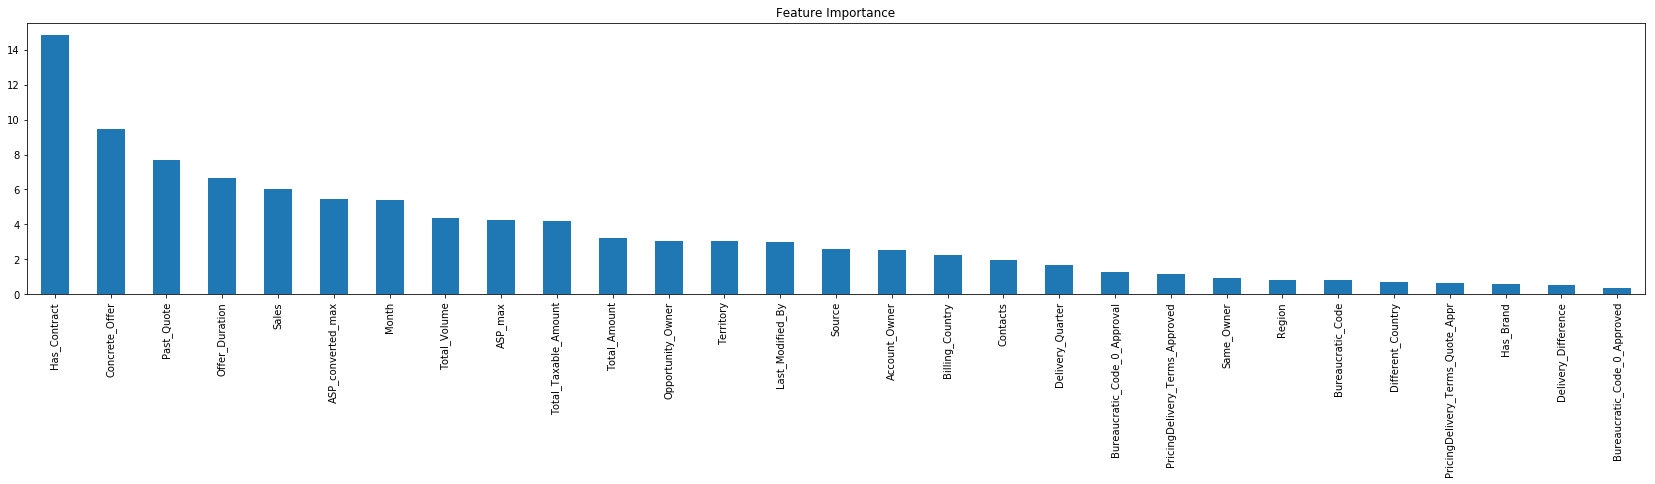

In [23]:
predictors = [x for x in x_test.drop(target, axis = 1).columns]
print len(predictors)
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:29]
plt.rcParams['figure.figsize'] = 29, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [24]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [25]:
bad.Stage.value_counts()

0    60
1    21
Name: Stage, dtype: int64

In [30]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
    
leak = ["Opportunity_ID", "Sales_Contract_No"]
validation.loc[validation.Concrete_Offer.isna(), "Concrete_Offer"] = -100
pred = model.predict_proba(validation.drop(leak, axis = 1))[:,1]

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [31]:
prev = pd.read_csv("acceptable/submission_23.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9897168337174529

In [32]:
prev = pd.read_csv("acceptable/submission_11.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9904160927497901

In [33]:
answer["Opportunity_ID"] = answer["Opportunity_ID"].astype(int)

In [34]:
answer.to_csv("adab_imputer.csv", header = False, index = False)

In [35]:
prev = pd.read_csv("fabri/adab2.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9983711756130415